In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score,KFold, StratifiedKFold

from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline, make_pipeline

import seaborn as sns
from sklearn.neighbors import NearestNeighbors as nn
from imblearn.over_sampling import SMOTE, ADASYN

from sklearn.linear_model import LogisticRegression

from sklearn import metrics

from sklearn.cluster import KMeans

from sklearn.metrics import classification_report, recall_score, roc_auc_score, precision_score, f1_score, auc, balanced_accuracy_score

#from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
#from lightgbm import LGBMClassifier
#from sklearn.metrics import classification_report, recall_score, roc_auc_score, precision_score, f1_score, auc, balanced_accuracy_score


In [2]:
random_state = 123*987*4-1
models_to_average = 50

In [3]:
real_dataset = pd.read_csv("./datasets/real_ds_shortincome.csv")
synt_data_distilgpt2 = pd.read_csv('./datasets/synt_ds_distillgpt2_shortincome_3epochs_temp0.1.csv')
synt_data_gpt2xl = pd.read_csv("./datasets/synt_ds_gpt2xl_shortincome_3epochs_temp0.1.csv")
synt_data_cerebras = pd.read_csv("./datasets/synt_ds_cerebras13_shortincome_3epochs_temp0.1.csv")
synt_data_phi = pd.read_csv("./datasets/synt_ds_phi15_shortincome_3epochs_temp0.1.csv")
control_dataset = pd.read_csv("./datasets/real_ds_shortincome_control.csv")

In [4]:
real_dataset.drop(columns="Unnamed: 0",inplace=True)
synt_data_distilgpt2.drop(columns="Unnamed: 0",inplace=True)
synt_data_gpt2xl.drop(columns="Unnamed: 0",inplace=True)
synt_data_cerebras.drop(columns="Unnamed: 0",inplace=True)
synt_data_phi.drop(columns="Unnamed: 0",inplace=True)
control_dataset.drop(columns="Unnamed: 0",inplace=True)


In [5]:
cols = real_dataset.columns

In [6]:
def strip (x) :
    if isinstance(x,str):
        return x.lstrip()
    else :
        return x

In [7]:
for col in cols :
    real_dataset[col] = real_dataset[col].map(strip) 

In [8]:
for col in cols :
    synt_data_distilgpt2[col] = synt_data_distilgpt2[col].map(strip) 

In [9]:
for col in cols :
    synt_data_gpt2xl[col] = synt_data_gpt2xl[col].map(strip) 

In [10]:
for col in cols :
    synt_data_cerebras[col] = synt_data_cerebras[col].map(strip) 

In [11]:
for col in cols :
    synt_data_phi[col] = synt_data_phi[col].map(strip) 

In [12]:
for col in cols :
    control_dataset[col] = control_dataset[col].map(strip) 

In [13]:
categs = list()
numeric = list()
for col in cols :
    print ('----------------------------------------------------')
    print (col, ':', real_dataset[col].dtype)
    print (len(real_dataset[col].unique()),'uniques values : ' ,real_dataset[col].unique())
    if real_dataset[col].dtype == 'object' :
        if col != 'target' :
            categs.append(col)
    else :
         numeric.append(col)
    

----------------------------------------------------
age : int64
91 uniques values :  [52 39 29 30 15  6 50 21 42 32  8 87 47 45  7  4 17 14 82 19 40 71 49 22
 74 25  2 36 35 18 58 54 24 37 80 73 55  0 62 28 78 41 75 60 69 13 12 61
 44 64  3 43 27 31 46 76 33 23 84 48  1  5 70 16 51 38 72  9 20 56 90 11
 67 26 34 10 57 53 66 77 85 89 68 79 81 65 59 83 88 63 86]
----------------------------------------------------
class_of_worker : object
9 uniques values :  ['Private' 'Self-employed-not incorporated' 'Not in universe'
 'Self-employed-incorporated' 'Local government' 'State government'
 'Federal government' 'Never worked' 'Without pay']
----------------------------------------------------
education : object
17 uniques values :  ['Some college but no degree' 'Bachelors degree(BA AB BS)'
 '7th and 8th grade' 'Children' 'High school graduate' '10th grade'
 'Masters degree(MA MS MEng MEd MSW MBA)'
 'Associates degree-occup /vocational' '11th grade' '5th or 6th grade'
 '9th grade' 'Doctorate

In [14]:
# these features are categorical by definition
numeric.remove('own_business_or_self_employed')
categs.append('own_business_or_self_employed')


In [15]:
numeric

['age',
 'dividends_from_stocks',
 'num_persons_worked_for_employer',
 'weeks_worked_in_year']

In [16]:
categs

['class_of_worker',
 'education',
 'marital_stat',
 'major_occupation_code',
 'race',
 'sex',
 'tax_filer_stat',
 'region_of_previous_residence',
 'detailed_household_summary_in_household',
 'country_of_birth_self',
 'citizenship',
 'own_business_or_self_employed']

In [17]:
target_encoder= {'50000+.': 1, 
                '- 50000.': 0} 

# Data analysis

### Real data 

In [18]:
real_dataset.describe()

age  dividends_from_stocks  num_persons_worked_for_employer  \
count  30000.000000           30000.000000                     30000.000000   
mean      34.438300             188.126267                         1.964933   
std       22.350409            2007.247607                         2.375379   
min        0.000000               0.000000                         0.000000   
25%       15.000000               0.000000                         0.000000   
50%       33.000000               0.000000                         1.000000   
75%       50.000000               0.000000                         4.000000   
max       90.000000           99999.000000                         6.000000   

       own_business_or_self_employed  weeks_worked_in_year  
count                   30000.000000          30000.000000  
mean                        0.171133             23.182433  
std                         0.548383             24.424737  
min                         0.000000              0.000000  
25%                         0.000000              0.000000  
50%                         0.000000              8.000000  
75%                         0.000000             52.000000  
max                         2.000000             52.000000

In [19]:
print(real_dataset.isna().sum().sum())

0


In [20]:
real_dataset['target'].unique()

array(['- 50000.', '50000+.'], dtype=object)

<AxesSubplot:>

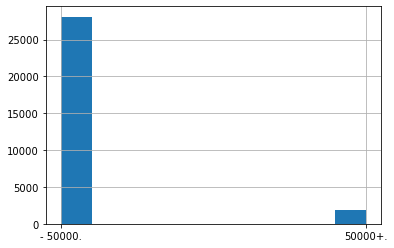

In [21]:
real_dataset['target'].hist()

In [22]:
print(f" Real data for binary classification is imbalanced: {len(real_dataset[real_dataset['target']=='50000+.'])/len(real_dataset)*100:.2f}% and {100-len(real_dataset[real_dataset['target']=='50000+.'])/len(real_dataset)*100:.2f}%")


 Real data for binary classification is imbalanced: 6.30% and 93.70%


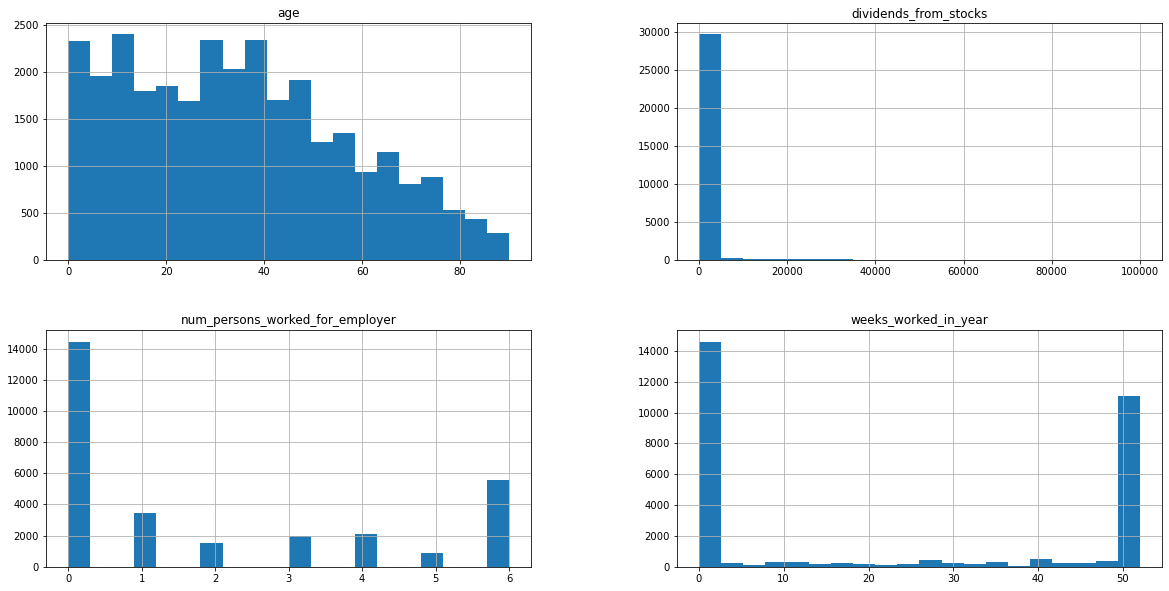

In [23]:
real_dataset[numeric].hist(bins=20, grid=True, figsize=(20, 10), layout=(2, 2))
plt.show()

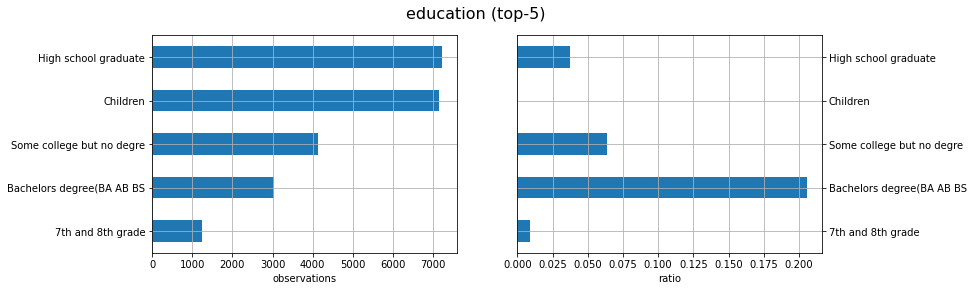

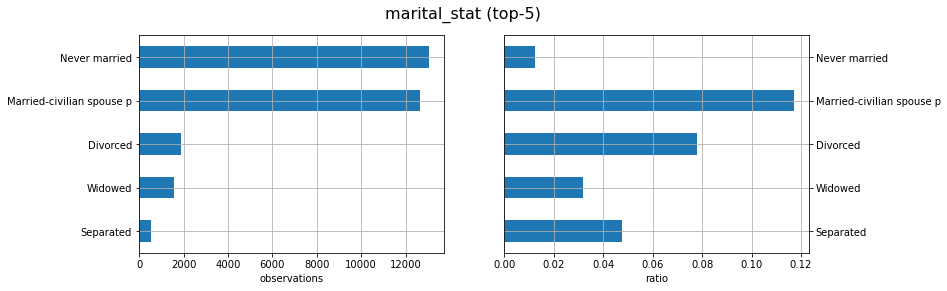

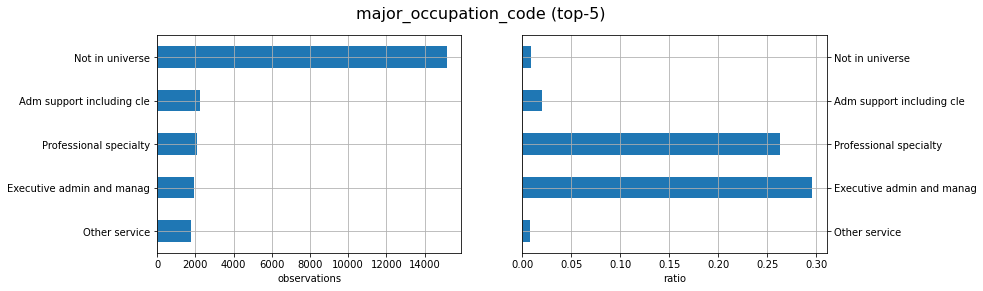

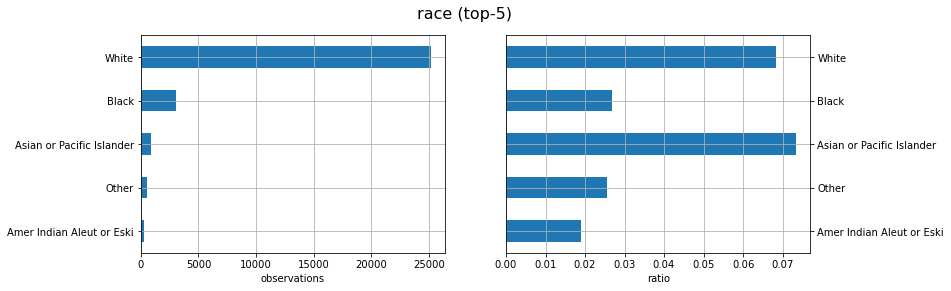

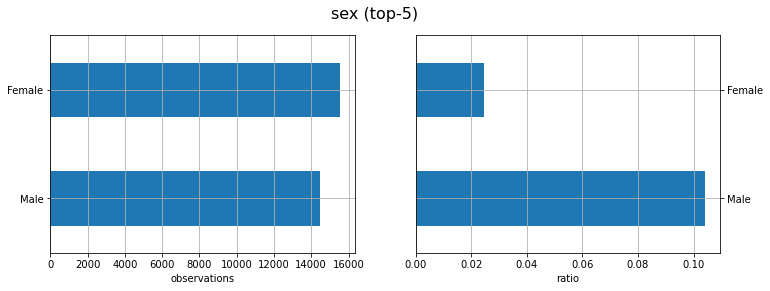

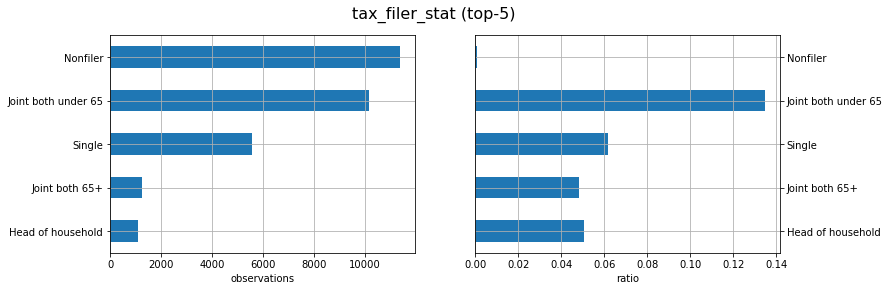

In [24]:
max_len = 25
top = 5

top_pivot = list()

for c in categs:
    top_pivot.append(c)
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(f'{c} (top-{top})', fontsize=16)
    pivot = real_dataset.drop(['target'], axis=1).assign(cnt=1, target=real_dataset['target'].map(target_encoder)).pivot_table(index=c, columns='target', values='cnt',
                                                              aggfunc='count', fill_value=0)
    pivot['num_obs'] = pivot.sum(axis=1)
    pivot['ratio_target'] = pivot[1] / pivot.num_obs
    pivot.sort_values('num_obs', inplace=True)
    pivot = pivot.tail(top)
    pivot.num_obs.plot.barh(ax=ax[0])
    
    labels = []
    for label in ax[0].get_yticklabels():
        text = label.get_text()
        if len(text) > max_len:
            label.set_text(text[:max_len])
        labels.append(label)

    
    ax[0].set_yticklabels(labels)
    ax[0].set_ylabel('')
    ax[0].set_xlabel('observations')
    ax[0].grid()
    
    pivot.ratio_target.plot.barh(ax=ax[1])
    
    labels = []
    for label in ax[1].get_yticklabels():
        text = label.get_text()
        if len(text) > max_len:
            label.set_text(text[:max_len])
        labels.append(label)
    
    ax[1].set_yticklabels(labels)
    ax[1].set_ylabel('')
    ax[1].set_xlabel('ratio')
    ax[1].yaxis.tick_right()
    ax[1].grid()

### DistillGPT

In [25]:
synt_data_distilgpt2.describe()

age  dividends_from_stocks  num_persons_worked_for_employer  \
count  30000.000000                30000.0                     30000.000000   
mean      27.385900                    0.0                         1.530467   
std       22.725564                    0.0                         2.610894   
min        0.000000                    0.0                         0.000000   
25%        7.000000                    0.0                         0.000000   
50%       25.000000                    0.0                         0.000000   
75%       41.000000                    0.0                         6.000000   
max       90.000000                    0.0                         6.000000   

       own_business_or_self_employed  weeks_worked_in_year  
count                        30000.0          30000.000000  
mean                             0.0             13.450133  
std                              0.0             22.769939  
min                              0.0              0.000000  
25%                              0.0              0.000000  
50%                              0.0              0.000000  
75%                              0.0             52.000000  
max                              0.0             52.000000

In [26]:
print(synt_data_distilgpt2.isna().sum().sum())
print(synt_data_distilgpt2.isna().sum())

0
age                                        0
class_of_worker                            0
education                                  0
marital_stat                               0
major_occupation_code                      0
race                                       0
sex                                        0
dividends_from_stocks                      0
tax_filer_stat                             0
region_of_previous_residence               0
detailed_household_summary_in_household    0
num_persons_worked_for_employer            0
country_of_birth_self                      0
citizenship                                0
own_business_or_self_employed              0
weeks_worked_in_year                       0
target                                     0
dtype: int64


In [27]:
synt_data_distilgpt2['target'].unique()

array(['- 50000.', '50000+.'], dtype=object)

<AxesSubplot:>

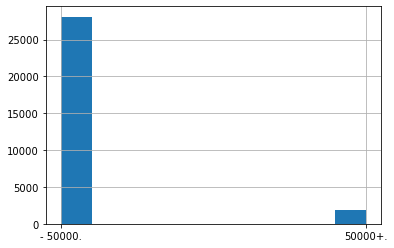

In [28]:
synt_data_distilgpt2['target'].hist()

In [29]:
print(f" Synthetic data for binary classification is imbalanced: {len(synt_data_distilgpt2[synt_data_distilgpt2['target']==' 50000+.'])/len(synt_data_distilgpt2)*100:.2f}% and {100-len(synt_data_distilgpt2[synt_data_distilgpt2['target']==' 50000+.'])/len(synt_data_distilgpt2)*100:.2f}%")


 Synthetic data for binary classification is imbalanced: 0.00% and 100.00%


In [30]:
synt_data_distilgpt2[numeric].hist(bins=20, grid=True, figsize=(20, 10), layout=(2, 4))
plt.show()

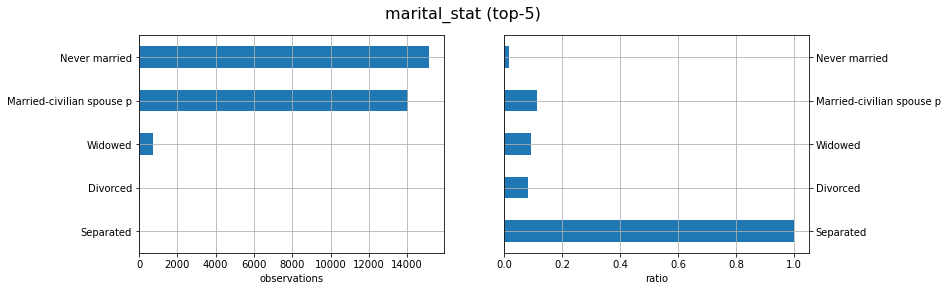

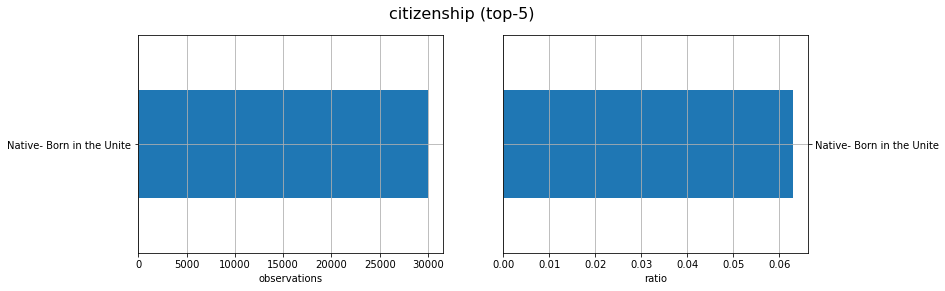

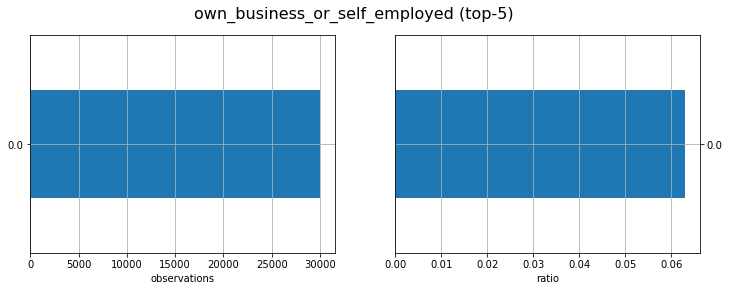

In [31]:
max_len = 25
top = 5

top_pivot = list()

for c in categs:
    top_pivot.append(c)
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(f'{c} (top-{top})', fontsize=16)
    pivot = synt_data_distilgpt2.drop(['target'], axis=1).assign(cnt=1, target=synt_data_distilgpt2['target'].map(target_encoder)).pivot_table(index=c, columns='target', values='cnt',
                                                              aggfunc='count', fill_value=0)
    pivot['num_obs'] = pivot.sum(axis=1)
    pivot['ratio_target'] = pivot[1] / pivot.num_obs
    pivot.sort_values('num_obs', inplace=True)
    pivot = pivot.tail(top)
    pivot.num_obs.plot.barh(ax=ax[0])
    
    labels = []
    for label in ax[0].get_yticklabels():
        text = label.get_text()
        if len(text) > max_len:
            label.set_text(text[:max_len])
        labels.append(label)

    
    ax[0].set_yticklabels(labels)
    ax[0].set_ylabel('')
    ax[0].set_xlabel('observations')
    ax[0].grid()
    
    pivot.ratio_target.plot.barh(ax=ax[1])
    
    labels = []
    for label in ax[1].get_yticklabels():
        text = label.get_text()
        if len(text) > max_len:
            label.set_text(text[:max_len])
        labels.append(label)
    
    ax[1].set_yticklabels(labels)
    ax[1].set_ylabel('')
    ax[1].set_xlabel('ratio')
    ax[1].yaxis.tick_right()
    ax[1].grid()

### GPT2XL 

In [32]:
synt_data_gpt2xl.describe()

age  dividends_from_stocks  num_persons_worked_for_employer  \
count  30000.000000                30000.0                     30000.000000   
mean      19.748500                    0.0                         1.590667   
std       18.188887                    0.0                         2.641719   
min        0.000000                    0.0                         0.000000   
25%        5.000000                    0.0                         0.000000   
50%       12.000000                    0.0                         0.000000   
75%       35.000000                    0.0                         6.000000   
max       90.000000                    0.0                         6.000000   

       own_business_or_self_employed  weeks_worked_in_year  
count                        30000.0          30000.000000  
mean                             0.0             14.076800  
std                              0.0             23.104958  
min                              0.0              0.000000  
25%                              0.0              0.000000  
50%                              0.0              0.000000  
75%                              0.0             52.000000  
max                              0.0             52.000000

In [33]:
print(synt_data_gpt2xl.isna().sum().sum())

0


In [34]:
synt_data_gpt2xl['target'].unique()

array(['- 50000.', '50000+.'], dtype=object)

In [35]:
synt_data_gpt2xl['target'].hist()

<AxesSubplot:>

In [36]:
print(f" Synthetic data for binary classification is imbalanced: {len(synt_data_cerebras[synt_data_gpt2xl['target']=='50000+.'])/len(synt_data_gpt2xl)*100:.2f}% and {100-len(synt_data_gpt2xl[synt_data_gpt2xl['target']=='50000+.'])/len(synt_data_gpt2xl)*100:.2f}%")

 Synthetic data for binary classification is imbalanced: 6.27% and 93.73%


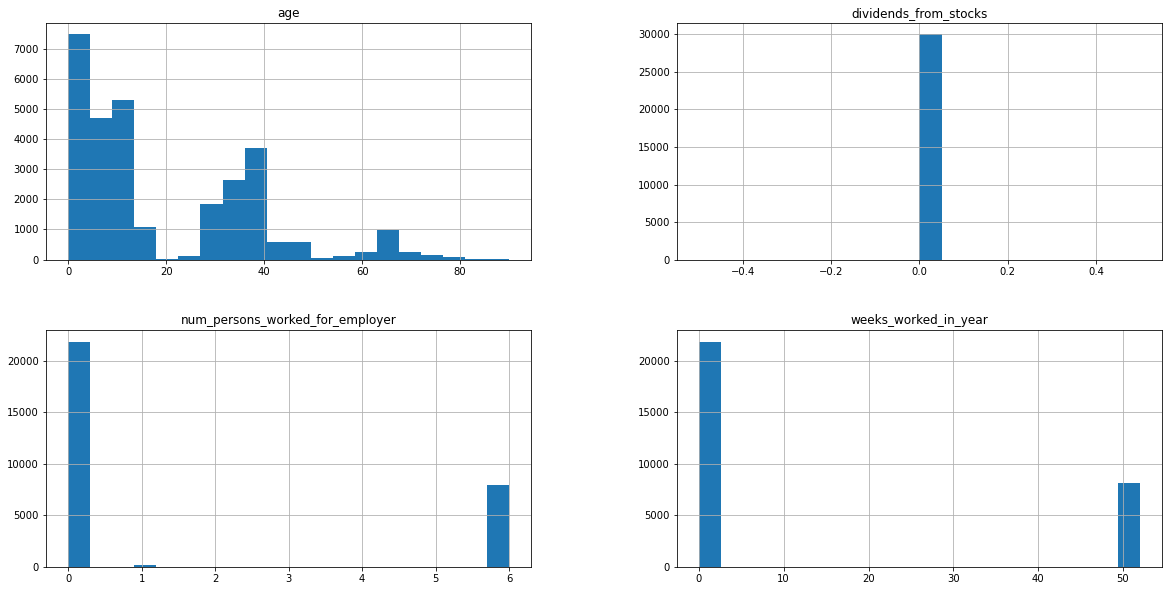

In [37]:
synt_data_gpt2xl[numeric].hist(bins=20, grid=True, figsize=(20, 10), layout=(2, 2))
plt.show()

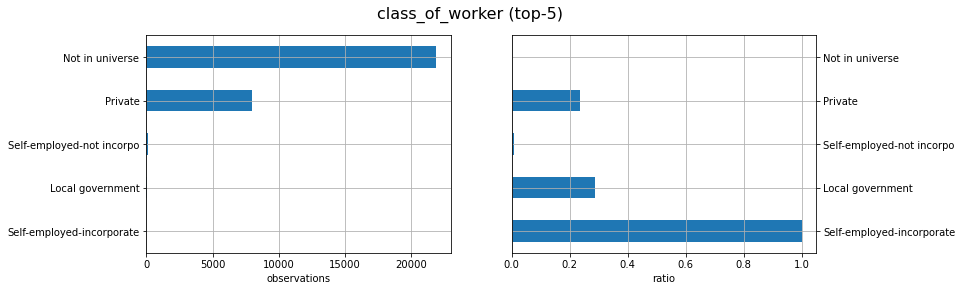

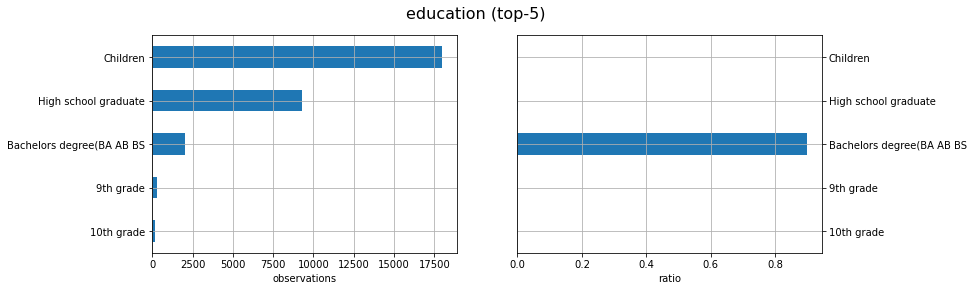

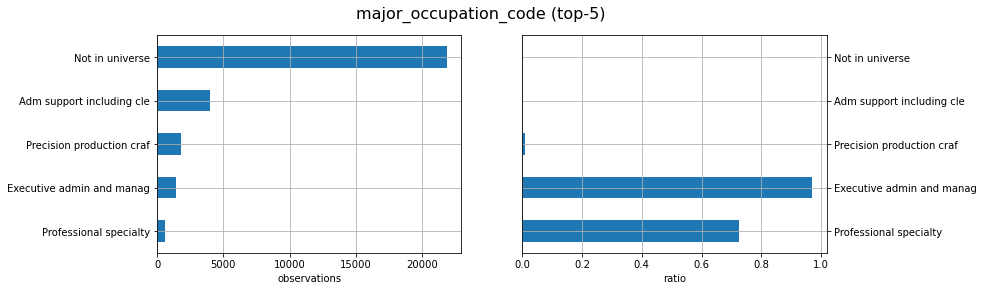

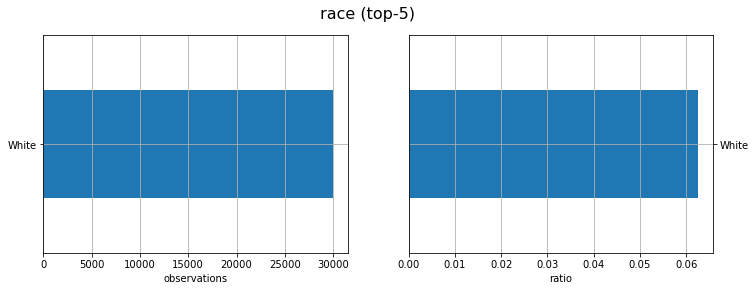

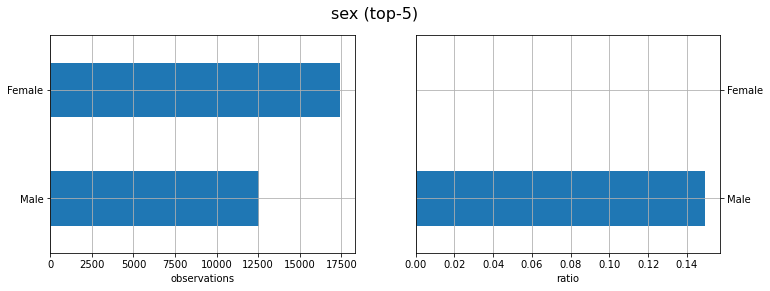

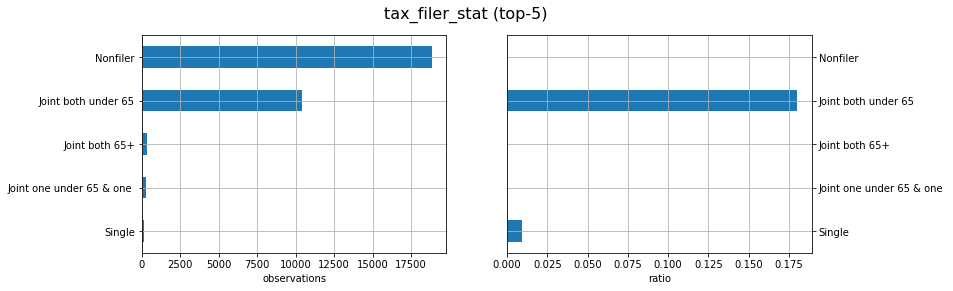

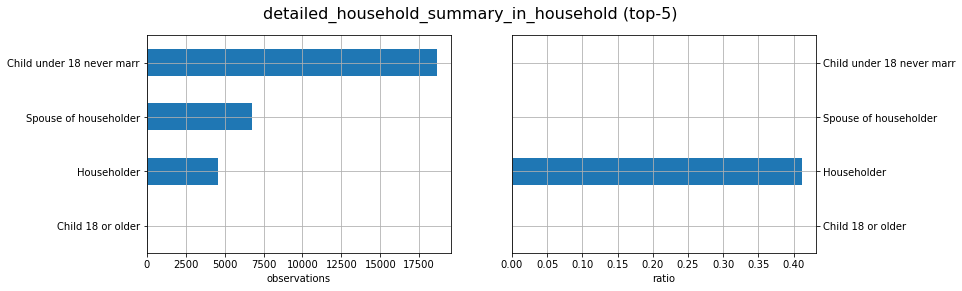

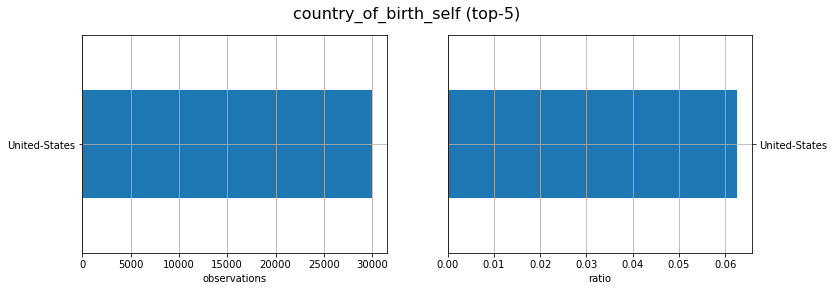

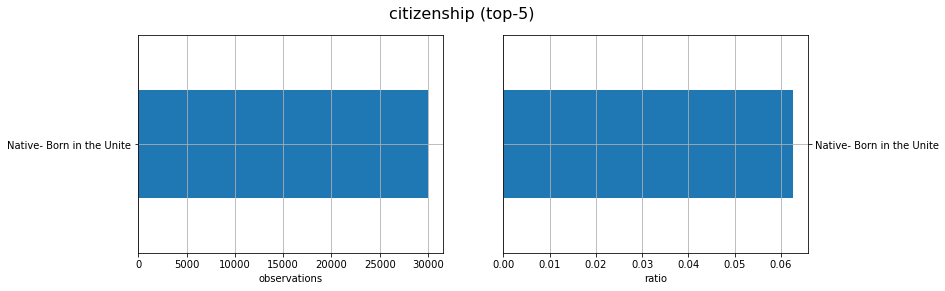

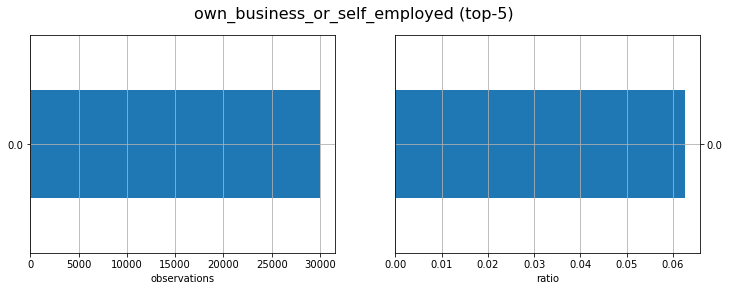

In [38]:
max_len = 25
top = 5

top_pivot = list()

for c in categs:
    top_pivot.append(c)
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(f'{c} (top-{top})', fontsize=16)
    pivot = synt_data_gpt2xl.drop(['target'], axis=1).assign(cnt=1, target=synt_data_gpt2xl['target'].map(target_encoder)).pivot_table(index=c, columns='target', values='cnt',
                                                              aggfunc='count', fill_value=0)
    pivot['num_obs'] = pivot.sum(axis=1)
    pivot['ratio_target'] = pivot[1] / pivot.num_obs
    pivot.sort_values('num_obs', inplace=True)
    pivot = pivot.tail(top)
    pivot.num_obs.plot.barh(ax=ax[0])
    
    labels = []
    for label in ax[0].get_yticklabels():
        text = label.get_text()
        if len(text) > max_len:
            label.set_text(text[:max_len])
        labels.append(label)

    
    ax[0].set_yticklabels(labels)
    ax[0].set_ylabel('')
    ax[0].set_xlabel('observations')
    ax[0].grid()
    
    pivot.ratio_target.plot.barh(ax=ax[1])
    
    labels = []
    for label in ax[1].get_yticklabels():
        text = label.get_text()
        if len(text) > max_len:
            label.set_text(text[:max_len])
        labels.append(label)
    
    ax[1].set_yticklabels(labels)
    ax[1].set_ylabel('')
    ax[1].set_xlabel('ratio')
    ax[1].yaxis.tick_right()
    ax[1].grid()

### Cerebras 

In [39]:
synt_data_cerebras.describe()

age  dividends_from_stocks  num_persons_worked_for_employer  \
count  30000.000000                30000.0                     30000.000000   
mean      19.622933                    0.0                         1.798267   
std       17.469186                    0.0                         2.743420   
min        0.000000                    0.0                         0.000000   
25%        4.000000                    0.0                         0.000000   
50%       12.000000                    0.0                         0.000000   
75%       35.000000                    0.0                         6.000000   
max       90.000000                    0.0                         6.000000   

       own_business_or_self_employed  weeks_worked_in_year  
count                        30000.0          30000.000000  
mean                             0.0             15.825333  
std                              0.0             23.926873  
min                              0.0              0.000000  
25%                              0.0              0.000000  
50%                              0.0              0.000000  
75%                              0.0             52.000000  
max                              0.0             52.000000

In [40]:
print(synt_data_cerebras.isna().sum().sum())

0


In [41]:
synt_data_cerebras['target'].unique()

array(['50000+.', '- 50000.'], dtype=object)

<AxesSubplot:>

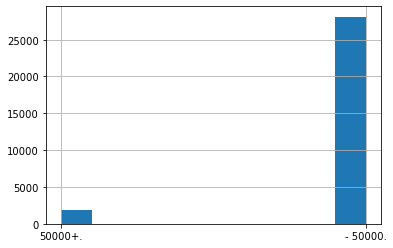

In [42]:
synt_data_cerebras['target'].hist()

In [43]:
print(f" Synthetic data for binary classification is imbalanced: {len(synt_data_cerebras[synt_data_cerebras['target']=='50000+.'])/len(synt_data_cerebras)*100:.2f}% and {100-len(synt_data_cerebras[synt_data_cerebras['target']=='50000+.'])/len(synt_data_cerebras)*100:.2f}%")

 Synthetic data for binary classification is imbalanced: 6.28% and 93.72%


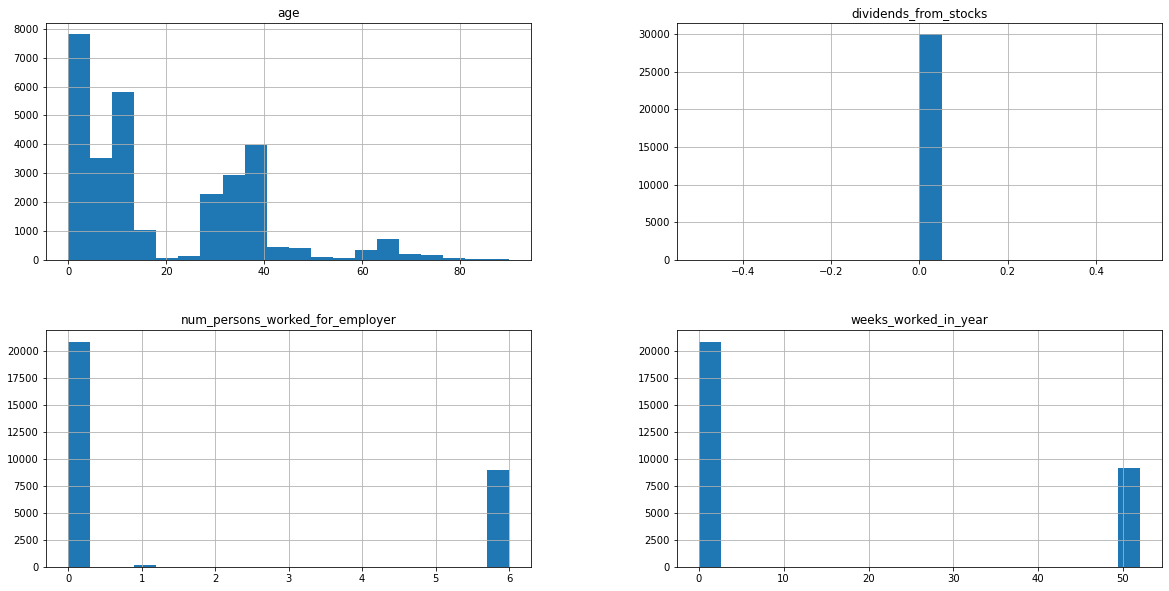

In [44]:
synt_data_cerebras[numeric].hist(bins=20, grid=True, figsize=(20, 10), layout=(2, 2))
plt.show()

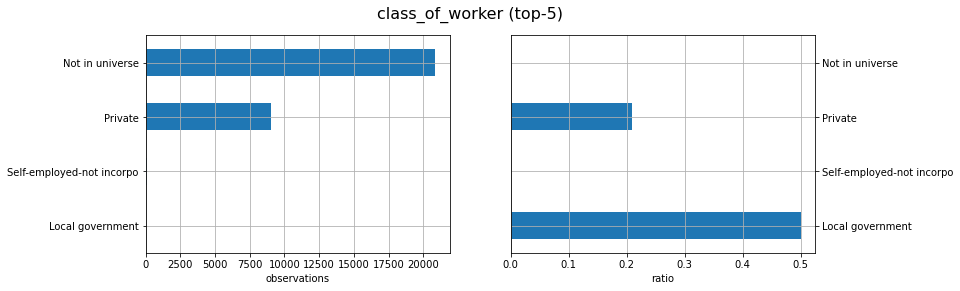

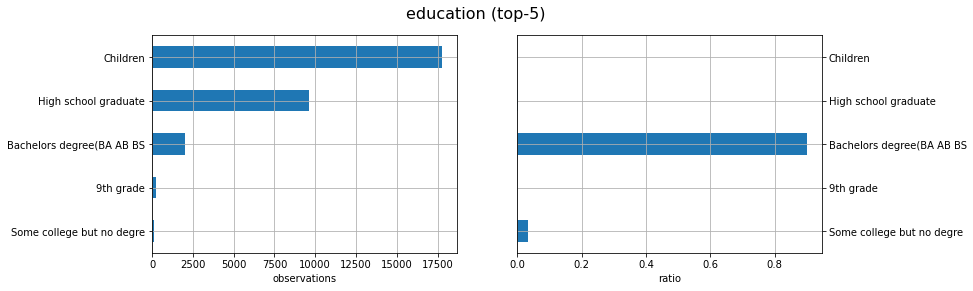

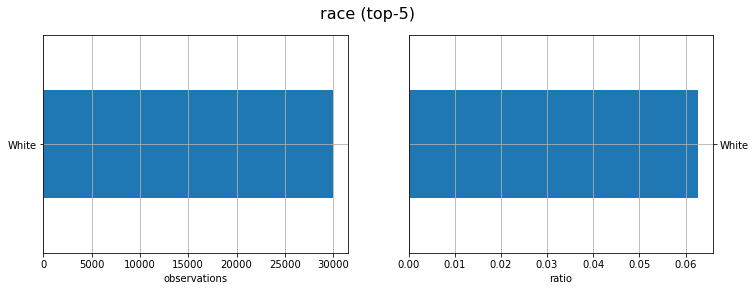

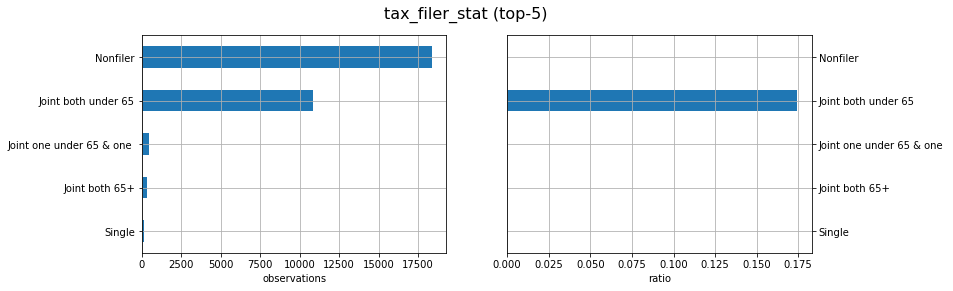

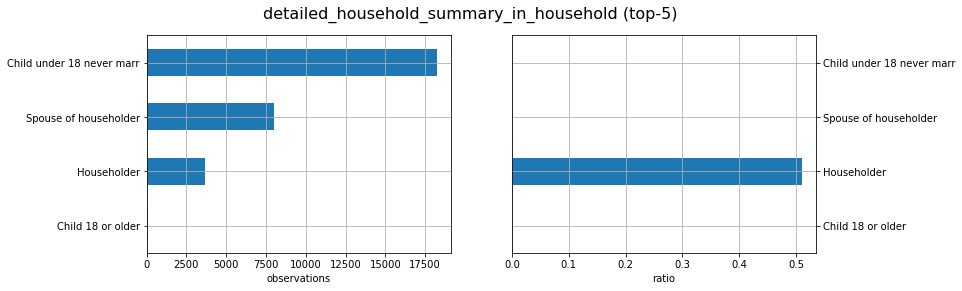

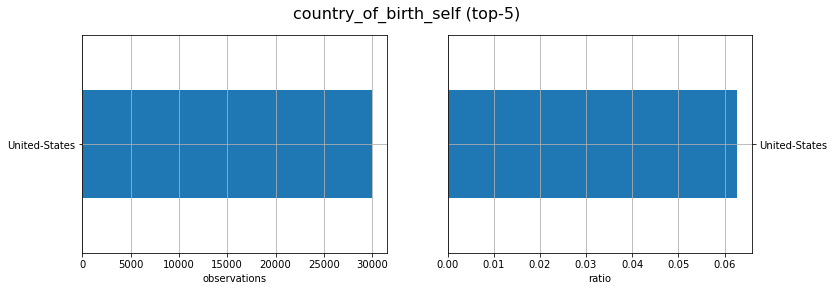

In [45]:
max_len = 25
top = 5

top_pivot = list()

for c in categs:
    top_pivot.append(c)
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(f'{c} (top-{top})', fontsize=16)
    pivot = synt_data_cerebras.drop(['target'], axis=1).assign(cnt=1, target=synt_data_cerebras['target'].map(target_encoder)).pivot_table(index=c, columns='target', values='cnt',
                                                              aggfunc='count', fill_value=0)
    pivot['num_obs'] = pivot.sum(axis=1)
    pivot['ratio_target'] = pivot[1] / pivot.num_obs
    pivot.sort_values('num_obs', inplace=True)
    pivot = pivot.tail(top)
    pivot.num_obs.plot.barh(ax=ax[0])
    
    labels = []
    for label in ax[0].get_yticklabels():
        text = label.get_text()
        if len(text) > max_len:
            label.set_text(text[:max_len])
        labels.append(label)

    
    ax[0].set_yticklabels(labels)
    ax[0].set_ylabel('')
    ax[0].set_xlabel('observations')
    ax[0].grid()
    
    pivot.ratio_target.plot.barh(ax=ax[1])
    
    labels = []
    for label in ax[1].get_yticklabels():
        text = label.get_text()
        if len(text) > max_len:
            label.set_text(text[:max_len])
        labels.append(label)
    
    ax[1].set_yticklabels(labels)
    ax[1].set_ylabel('')
    ax[1].set_xlabel('ratio')
    ax[1].yaxis.tick_right()
    ax[1].grid()

### Phi1.5 

In [46]:
synt_data_phi.describe()

age  dividends_from_stocks  num_persons_worked_for_employer  \
count  30000.00000                30000.0                     30000.000000   
mean      19.83310                    0.0                         1.649467   
std       19.05145                    0.0                         2.671061   
min        0.00000                    0.0                         0.000000   
25%        4.00000                    0.0                         0.000000   
50%       11.00000                    0.0                         0.000000   
75%       35.00000                    0.0                         6.000000   
max       90.00000                    0.0                         6.000000   

       own_business_or_self_employed  weeks_worked_in_year  
count                        30000.0          30000.000000  
mean                             0.0             14.636667  
std                              0.0             23.385399  
min                              0.0              0.000000  
25%                              0.0              0.000000  
50%                              0.0              0.000000  
75%                              0.0             52.000000  
max                              0.0             52.000000

In [47]:
print(synt_data_phi.isna().sum().sum())

0


In [48]:
synt_data_phi['target'].unique()

array(['50000+.', '- 50000.'], dtype=object)

<AxesSubplot:>

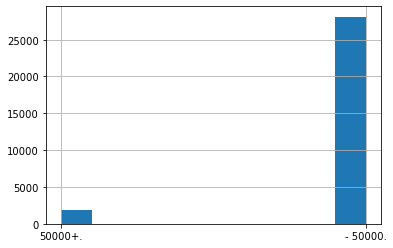

In [49]:
synt_data_phi['target'].hist()

In [50]:
print(f" Synthetic data for binary classification is imbalanced: {len(synt_data_phi[synt_data_phi['target']=='50000+.'])/len(synt_data_phi)*100:.2f}% and {100-len(synt_data_phi[synt_data_phi['target']=='50000+.'])/len(synt_data_phi)*100:.2f}%")

 Synthetic data for binary classification is imbalanced: 6.28% and 93.72%


In [51]:
synt_data_phi[numeric].hist(bins=20, grid=True, figsize=(20, 10), layout=(2, 2))
plt.show()

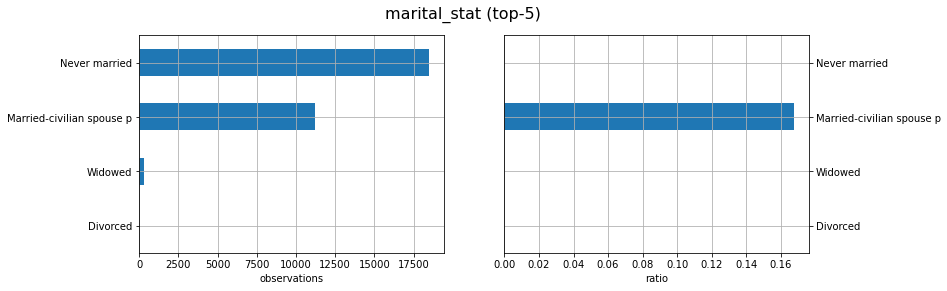

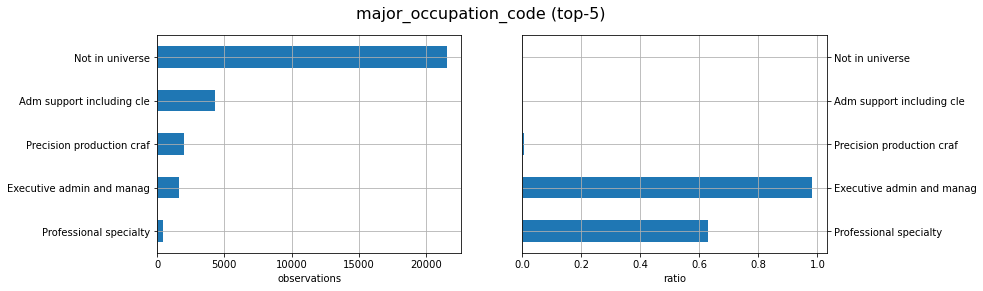

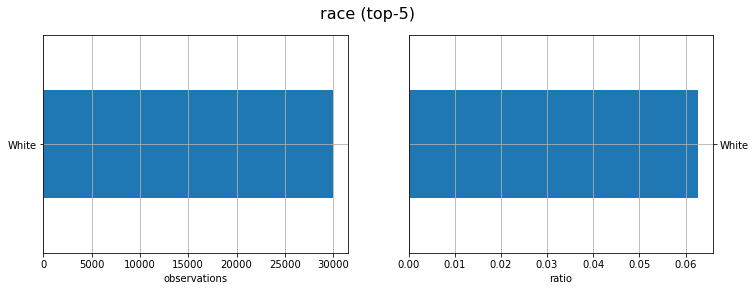

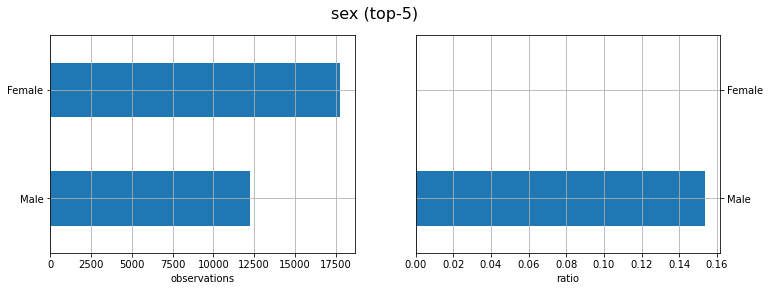

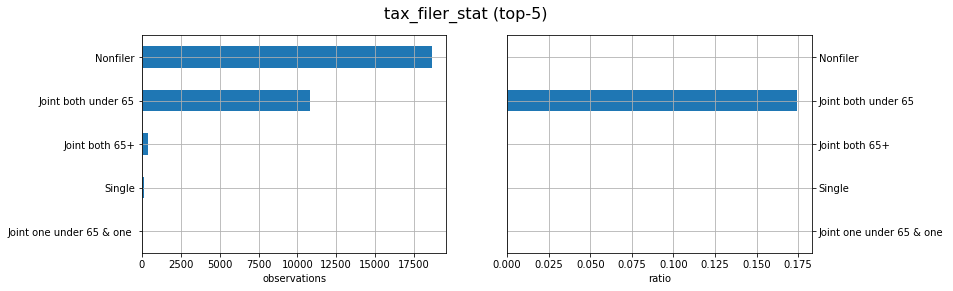

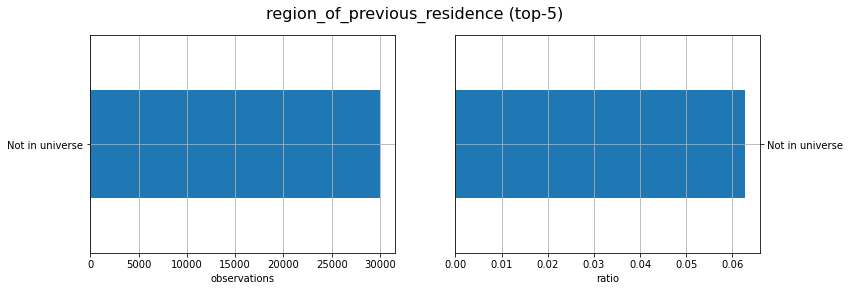

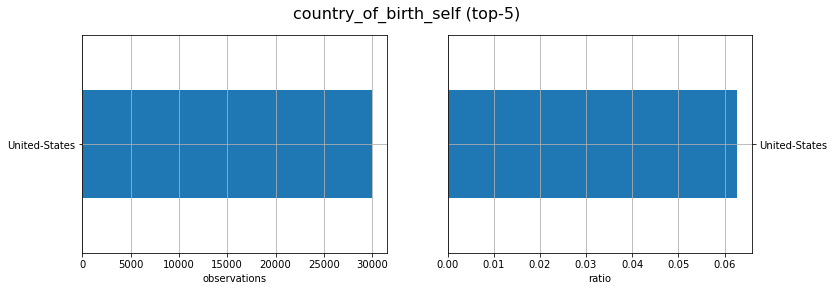

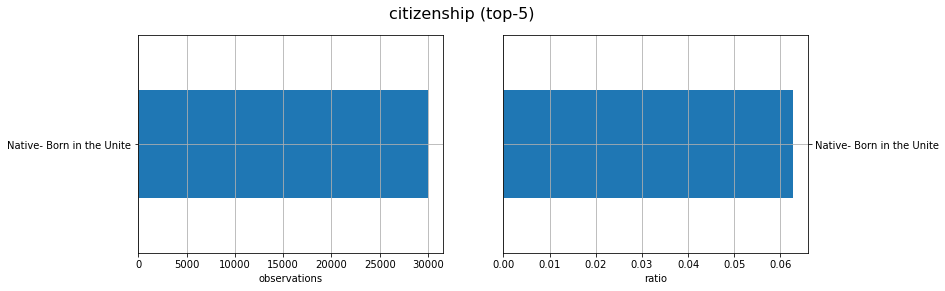

In [52]:
max_len = 25
top = 5

top_pivot = list()

for c in categs:
    top_pivot.append(c)
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(f'{c} (top-{top})', fontsize=16)
    pivot = synt_data_phi.drop(['target'], axis=1).assign(cnt=1, target=synt_data_phi['target'].map(target_encoder)).pivot_table(index=c, columns='target', values='cnt',
                                                              aggfunc='count', fill_value=0)
    pivot['num_obs'] = pivot.sum(axis=1)
    pivot['ratio_target'] = pivot[1] / pivot.num_obs
    pivot.sort_values('num_obs', inplace=True)
    pivot = pivot.tail(top)
    pivot.num_obs.plot.barh(ax=ax[0])
    
    labels = []
    for label in ax[0].get_yticklabels():
        text = label.get_text()
        if len(text) > max_len:
            label.set_text(text[:max_len])
        labels.append(label)

    
    ax[0].set_yticklabels(labels)
    ax[0].set_ylabel('')
    ax[0].set_xlabel('observations')
    ax[0].grid()
    
    pivot.ratio_target.plot.barh(ax=ax[1])
    
    labels = []
    for label in ax[1].get_yticklabels():
        text = label.get_text()
        if len(text) > max_len:
            label.set_text(text[:max_len])
        labels.append(label)
    
    ax[1].set_yticklabels(labels)
    ax[1].set_ylabel('')
    ax[1].set_xlabel('ratio')
    ax[1].yaxis.tick_right()
    ax[1].grid()

### Dataset comparsion

In [53]:
synt_datasets = dict()
synt_datasets['distilgpt2'] = synt_data_distilgpt2
synt_datasets['gpt2xl'] = synt_data_gpt2xl
synt_datasets['cerebras'] = synt_data_cerebras
synt_datasets['phi'] = synt_data_phi

In [54]:
cols_compare = dict()
for col in cols:
    cols_compare[col] = {}
    cols_compare[col]['real'] = real_dataset[col].to_numpy()
    for synt in synt_datasets:
        cols_compare[col][synt] = synt_datasets[synt][col].to_numpy()


In [55]:
all_data = list()
for col in cols :
    all_data.append((col,[x for x in [(i,cols_compare[col][i]) for i in cols_compare[col]]]))

In [56]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('_mpl-gallery')

# make data:
ncols=2
nrows=2

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20))
bplots = list()

i=0
for _, col in enumerate(all_data) :
    col_name = col[0]
    if not(col_name in numeric):
        continue
    col_data = col[1]
    rw = i//ncols
    cl = i%ncols
    i+=1
    axs[rw,cl].set_title(col_name)
     
    bplots.append(axs[rw,cl].boxplot([x[1] for x in col_data],
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=[x[0] for x in col_data]))  # will be used to label x-ticks
           
#fill with colors
colors = ['pink', 'lightblue', 'lightgreen','cyan','magenta','yellow',]
for bplot in bplots:
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

plt.show()

# Binary classification task on rough data

## General data preprocessing

In [57]:
to_encode = [i for i in categs]

In [58]:
to_encode

['class_of_worker',
 'education',
 'marital_stat',
 'major_occupation_code',
 'race',
 'sex',
 'tax_filer_stat',
 'region_of_previous_residence',
 'detailed_household_summary_in_household',
 'country_of_birth_self',
 'citizenship',
 'own_business_or_self_employed']

In [59]:
target_encoder= {' 50000+.': 1, 
                ' - 50000.': 0,
                '50000+.': 1, 
                '- 50000.': 0} 

In [60]:
edu_encoder= {' Children': 1, 
            ' Less than 1st grade': 2, 
            ' 1st 2nd 3rd or 4th grade': 3, 
            ' 5th or 6th grade': 4,
            ' 7th and 8th grade': 5, 
            ' 9th grade': 6, 
            ' 10th grade': 7, 
            ' 11th grade': 8 , 
            ' 12th grade no diploma': 9,
            ' High school graduate': 10, 
            ' Some college but no degree': 11, 
            ' Associates degree-occup /vocational': 12,
            ' Associates degree-academic program': 13, 
            ' Bachelors degree(BA AB BS)' : 14,
            ' Masters degree(MA MS MEng MEd MSW MBA)': 15,
            ' Doctorate degree(PhD EdD)': 16,
            ' Prof school degree (MD DDS DVM LLB JD)': 17,
            'Children': 1, 
            'Less than 1st grade': 2, 
            '1st 2nd 3rd or 4th grade': 3, 
            '5th or 6th grade': 4,
            '7th and 8th grade': 5, 
            '9th grade': 6, 
            '10th grade': 7, 
            '11th grade': 8 , 
            '12th grade no diploma': 9,
            'High school graduate': 10, 
            'Some college but no degree': 11, 
            'Associates degree-occup /vocational': 12,
            'Associates degree-academic program': 13, 
            'Bachelors degree(BA AB BS)' : 14,
            'Masters degree(MA MS MEng MEd MSW MBA)': 15,
            'Doctorate degree(PhD EdD)': 16,
            'Prof school degree (MD DDS DVM LLB JD)': 17}
to_encode.remove('education')

## Real data preprocessing and classification modeling

### Data preprocessing

In [61]:
real_data = real_dataset.copy()

In [62]:
X_tr, X_te, y_tr, y_te = train_test_split(real_data.drop(columns = ['target']),real_data['target'],test_size=0.2, random_state=random_state,stratify=real_data['target'])

In [63]:
X_te_real_validate = X_te.copy()
y_te_real_validate = y_te.copy()

In [64]:
print(real_data['target'].unique(), len(real_data['target'].unique()))

['- 50000.' '50000+.'] 2


In [65]:
y_tr=y_tr.map(target_encoder)
y_te=y_te.map(target_encoder)

In [66]:
print(y_tr.unique(), len(y_tr.unique()))

[0 1] 2


In [67]:
print(real_data['education'].unique(), len(real_data['education'].unique()))

['Some college but no degree' 'Bachelors degree(BA AB BS)'
 '7th and 8th grade' 'Children' 'High school graduate' '10th grade'
 'Masters degree(MA MS MEng MEd MSW MBA)'
 'Associates degree-occup /vocational' '11th grade' '5th or 6th grade'
 '9th grade' 'Doctorate degree(PhD EdD)' '1st 2nd 3rd or 4th grade'
 'Associates degree-academic program' 'Less than 1st grade'
 '12th grade no diploma' 'Prof school degree (MD DDS DVM LLB JD)'] 17


In [68]:
X_tr['education'] = X_tr['education'].map(edu_encoder)
X_te['education'] = X_te['education'].map(edu_encoder)

In [69]:
print(X_tr['education'].unique(), len(X_tr['education'].unique()))

[ 5 11  1 15 10 14  9 12  6  2 13  7  3  8  4 17 16] 17


In [70]:
to_encode_real = to_encode.copy() 

In [71]:
# mean target encoding
for i in to_encode_real.copy():
    codes = X_tr.assign(target = y_tr).groupby(i)['target'].mean().to_dict()
    if min(codes.values()) != 0:
        print ('+',i)
        X_tr[i] = X_tr[i].map(lambda x: codes[x])
        X_te[i] = X_te[i].map(lambda x: codes[x])
        to_encode_real.remove(i)

+ marital_stat
+ race
+ sex
+ tax_filer_stat
+ region_of_previous_residence
+ citizenship
+ own_business_or_self_employed


In [72]:
#frequency encoding 
for i in to_encode_real.copy():
    print ('+',i)
    codes = (X_tr[i].value_counts()/len(X_tr)).to_dict()
    X_tr[i] = X_tr[i].map(codes)
    X_te[i] = X_te[i].map(codes)
    to_encode_real.remove(i)

+ class_of_worker
+ major_occupation_code
+ detailed_household_summary_in_household
+ country_of_birth_self


In [73]:
to_encode_real

[]

In [74]:
print(X_tr.isna().sum().sum())
print(X_te.isna().sum().sum())

0
0


In [75]:
X_tr.dtypes

age                                          int64
class_of_worker                            float64
education                                    int64
marital_stat                               float64
major_occupation_code                      float64
race                                       float64
sex                                        float64
dividends_from_stocks                        int64
tax_filer_stat                             float64
region_of_previous_residence               float64
detailed_household_summary_in_household    float64
num_persons_worked_for_employer              int64
country_of_birth_self                      float64
citizenship                                float64
own_business_or_self_employed              float64
weeks_worked_in_year                         int64
dtype: object

### Features selection

In [76]:
features = list(X_tr.columns)
features.append('target')
matrix = X_tr.assign(target = y_tr)[features].corr(method='spearman')
matrix


age  class_of_worker  education  \
age                                      1.000000        -0.273832   0.554347   
class_of_worker                         -0.273832         1.000000  -0.586404   
education                                0.554347        -0.586404   1.000000   
marital_stat                             0.680123        -0.380808   0.535738   
major_occupation_code                   -0.235530         0.860999  -0.485680   
race                                     0.068959        -0.053021   0.100718   
sex                                     -0.038577        -0.094046   0.005064   
dividends_from_stocks                    0.256355        -0.134686   0.309286   
tax_filer_stat                           0.471370        -0.632230   0.660937   
region_of_previous_residence             0.090736         0.014371   0.001013   
detailed_household_summary_in_household  0.252836        -0.083663   0.108197   
num_persons_worked_for_employer          0.245655        -0.764200   0.587607   
country_of_birth_self                   -0.072291         0.035267  -0.025496   
citizenship                              0.046291        -0.014168   0.065853   
own_business_or_self_employed            0.030568        -0.269053   0.216898   
weeks_worked_in_year                     0.286815        -0.835988   0.604476   
target                                   0.169496        -0.241753   0.304604   

                                         marital_stat  major_occupation_code  \
age                                          0.680123              -0.235530   
class_of_worker                             -0.380808               0.860999   
education                                    0.535738              -0.485680   
marital_stat                                 1.000000              -0.337805   
major_occupation_code                       -0.337805               1.000000   
race                                         0.109519              -0.045462   
sex                                         -0.007314              -0.175800   
dividends_from_stocks                        0.230006              -0.079366   
tax_filer_stat                               0.760664              -0.601035   
region_of_previous_residence                 0.049349               0.022531   
detailed_household_summary_in_household      0.178682              -0.087470   
num_persons_worked_for_employer              0.359423              -0.736346   
country_of_birth_self                       -0.078488               0.064963   
citizenship                                  0.017042               0.017550   
own_business_or_self_employed                0.084303              -0.258446   
weeks_worked_in_year                         0.413837              -0.807133   
target                                       0.200576              -0.180488   

                                             race       sex  \
age                                      0.068959 -0.038577   
class_of_worker                         -0.053021 -0.094046   
education                                0.100718  0.005064   
marital_stat                             0.109519 -0.007314   
major_occupation_code                   -0.045462 -0.175800   
race                                     1.000000  0.022378   
sex                                      0.022378  1.000000   
dividends_from_stocks                    0.081465  0.031495   
tax_filer_stat                           0.114606  0.037119   
region_of_previous_residence             0.022446  0.001121   
detailed_household_summary_in_household  0.012262  0.242139   
num_persons_worked_for_employer          0.036247  0.072372   
country_of_birth_self                   -0.120298  0.014380   
citizenship                              0.001725  0.010086   
own_business_or_self_employed            0.030773  0.036088   
weeks_worked_in_year                     0.062989  0.110199   
target                                   0.056979  0.168318   

           

In [77]:
sns.set(rc={'figure.figsize': (50, 50)})
sns.set(font_scale=0.8)
sns.heatmap(matrix, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Matrix');

In [78]:
del_features = list()
count_features = list(matrix.columns)
count_features.remove('target')

for i in range(len(count_features)):
    for j in range(i+1, len(count_features)):
        feature_1 = matrix.columns[i]
        feature_2 = matrix.columns[j]
        if abs(matrix[feature_1].at[feature_2]) > 0.8:
            if abs(matrix['target'].at[feature_2]) > abs(matrix['target'].at[feature_1]):
                del_features.append(feature_1)
            else:
                del_features.append(feature_2)
                
del_features = np.unique(del_features)
print("The number of features to remove:", len(del_features))
print("The number of features remaining:", len(matrix) - len(del_features) - 1)

The number of features to remove: 3
The number of features remaining: 13


In [79]:
del_features

array(['class_of_worker', 'major_occupation_code',
       'num_persons_worked_for_employer'], dtype='<U31')

In [80]:
for del_feature in del_features:
    count_features.remove(del_feature)
print("The number of features remaining:", len(count_features))

The number of features remaining: 13


In [81]:
real_model_features = count_features.copy()
sorted(real_model_features)

['age',
 'citizenship',
 'country_of_birth_self',
 'detailed_household_summary_in_household',
 'dividends_from_stocks',
 'education',
 'marital_stat',
 'own_business_or_self_employed',
 'race',
 'region_of_previous_residence',
 'sex',
 'tax_filer_stat',
 'weeks_worked_in_year']

### Logistic Regression

In [82]:
#X_tr, X_te_real, y_tr, y_te_real = train_test_split(real_data[count_features],real_data['target'],test_size=0.2, random_state=random_state,stratify=real_data['target'])

In [83]:
X_tr = X_tr[count_features]
X_te = X_te[count_features]

In [84]:
%%time
smt = ADASYN(random_state=random_state)
X_smt, y_smt = smt.fit_resample(X_tr, y_tr)

CPU times: total: 422 ms
Wall time: 472 ms


In [85]:
log_pipe = Pipeline([
    ('Scaler', StandardScaler()),
    ('LR', LogisticRegression())
])

log_parameters = {
    'LR__solver': ['saga'],
    'LR__C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
}


In [86]:
%%time
grid_pipe_log = GridSearchCV(log_pipe, log_parameters, cv=5, scoring='balanced_accuracy', verbose=3)
grid_pipe_log.fit(X_smt, y_smt)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.838 total time=   0.3s
[CV 2/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.823 total time=   0.3s
[CV 3/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.830 total time=   0.4s
[CV 4/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.839 total time=   0.3s
[CV 5/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.825 total time=   0.5s
[CV 1/5] END ......LR__C=0.001, LR__solver=saga;, score=0.848 total time=   0.5s
[CV 2/5] END ......LR__C=0.001, LR__solver=saga;, score=0.845 total time=   0.4s
[CV 3/5] END ......LR__C=0.001, LR__solver=saga;, score=0.840 total time=   0.5s
[CV 4/5] END ......LR__C=0.001, LR__solver=saga;, score=0.854 total time=   0.4s
[CV 5/5] END ......LR__C=0.001, LR__solver=saga;, score=0.835 total time=   0.4s
[CV 1/5] END .......LR__C=0.01, LR__solver=saga;, score=0.852 total time=   0.3s
[CV 2/5] END .......LR__C=0.01, LR__solver=saga;,

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Scaler', StandardScaler()),
                                       ('LR', LogisticRegression())]),
             param_grid={'LR__C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
                         'LR__solver': ['saga']},
             scoring='balanced_accuracy', verbose=3)

In [87]:
print(grid_pipe_log.best_score_)
print(grid_pipe_log.best_estimator_.steps[1][1])

0.846383824896176
LogisticRegression(C=0.1, solver='saga')


In [88]:
y_pred_test = grid_pipe_log.best_estimator_.predict(X_te)

In [89]:
model_results = pd.DataFrame(columns=['Model','Dataset','Balanced_accuracy','Recall', 'Precision', 'ROC_AUC'])
res_test = pd.DataFrame([['LogRegression Real data','Real test',
                        balanced_accuracy_score(y_te, y_pred_test),
                        recall_score(y_te, y_pred_test),
                        precision_score(y_te, y_pred_test),
                        roc_auc_score(y_te, y_pred_test)]],
                        columns=['Model','Dataset','Balanced_accuracy','Recall', 'Precision', 'ROC_AUC'])

model_results = pd.concat([model_results, res_test],axis=0)

C:\Users\AlexeyNeyman\AppData\Local\Temp\ipykernel_13952\616206078.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_results = pd.concat([model_results, res_test],axis=0)


In [90]:
res_test

Model    Dataset  Balanced_accuracy    Recall  Precision  \
0  LogRegression Real data  Real test            0.84528  0.888889   0.231564   

   ROC_AUC  
0  0.84528

In [91]:
model_results

Model    Dataset  Balanced_accuracy    Recall  Precision  \
0  LogRegression Real data  Real test            0.84528  0.888889   0.231564   

   ROC_AUC  
0  0.84528

## DistillGPT2 classification

### Data preprocessing 

In [92]:
synt_data = synt_data_distilgpt2.copy()

In [93]:
X_tr, X_te, y_tr, y_te = train_test_split(synt_data.drop(columns = ['target']),synt_data['target'],test_size=0.2, random_state=random_state,stratify=synt_data['target'])

In [94]:
X_te_real = X_te_real_validate.copy()
y_te_real = y_te_real_validate.copy()

In [95]:
print(synt_data['target'].unique(), len(synt_data['target'].unique()))

['- 50000.' '50000+.'] 2


In [96]:
y_tr=y_tr.map(target_encoder)
y_te=y_te.map(target_encoder)
y_te_real = y_te_real.map(target_encoder) 

In [97]:
print(y_tr.unique(), len(y_tr.unique()))

[0 1] 2


In [98]:
print(synt_data['education'].unique(), len(synt_data['education'].unique()))

['Children' 'High school graduate' '9th grade' '7th and 8th grade'
 'Bachelors degree(BA AB BS)' 'Some college but no degree' '10th grade'
 'Associates degree-occup /vocational'
 'Prof school degree (MD DDS DVM LLB JD)' '11th grade'
 'Masters degree(MA MS MEng MEd MSW MBA)'
 'Associates degree-academic program'] 12


In [99]:
for edu in synt_data['education'].unique():
    if edu in edu_encoder.keys() :
        continue
    else :
        edu_encoder[edu] = 0
        print (edu)
edu_encoder

{' Children': 1,
 ' Less than 1st grade': 2,
 ' 1st 2nd 3rd or 4th grade': 3,
 ' 5th or 6th grade': 4,
 ' 7th and 8th grade': 5,
 ' 9th grade': 6,
 ' 10th grade': 7,
 ' 11th grade': 8,
 ' 12th grade no diploma': 9,
 ' High school graduate': 10,
 ' Some college but no degree': 11,
 ' Associates degree-occup /vocational': 12,
 ' Associates degree-academic program': 13,
 ' Bachelors degree(BA AB BS)': 14,
 ' Masters degree(MA MS MEng MEd MSW MBA)': 15,
 ' Doctorate degree(PhD EdD)': 16,
 ' Prof school degree (MD DDS DVM LLB JD)': 17,
 'Children': 1,
 'Less than 1st grade': 2,
 '1st 2nd 3rd or 4th grade': 3,
 '5th or 6th grade': 4,
 '7th and 8th grade': 5,
 '9th grade': 6,
 '10th grade': 7,
 '11th grade': 8,
 '12th grade no diploma': 9,
 'High school graduate': 10,
 'Some college but no degree': 11,
 'Associates degree-occup /vocational': 12,
 'Associates degree-academic program': 13,
 'Bachelors degree(BA AB BS)': 14,
 'Masters degree(MA MS MEng MEd MSW MBA)': 15,
 'Doctorate degree(PhD E

In [100]:
X_tr['education'] = X_tr['education'].map(edu_encoder)
X_te['education'] = X_te['education'].map(edu_encoder)
X_te_real['education'] = X_te_real['education'].map(edu_encoder)

In [101]:
to_encode_synt = to_encode.copy() 

In [102]:
# mean target encoding
for i in to_encode_synt.copy():
    codes = X_tr.assign(target = y_tr).groupby(i)['target'].mean().to_dict()
    codes_ext = codes.copy()
    for t in X_te[i].unique():
        if not (t in codes_ext.keys()) :
            codes_ext[t] = 0
    for t in X_te_real[i].unique():
        if not (t in codes_ext.keys()) :
            codes_ext[t] = 0
    if min(codes.values()) != 0:
        print ('+',i)
        X_tr[i] = X_tr[i].map(lambda x: codes[x])
        X_te[i] = X_te[i].map(lambda x: codes_ext[x])
        X_te_real[i] = X_te_real[i].map(lambda x: codes_ext[x])
        to_encode_synt.remove(i)

+ race
+ sex
+ region_of_previous_residence
+ country_of_birth_self
+ citizenship
+ own_business_or_self_employed


In [103]:
#frequency encoding 
for i in to_encode_synt.copy():
    print ('+',i)
    codes = (X_tr[i].value_counts()/len(X_tr)).to_dict()
    X_tr[i] = X_tr[i].map(codes)
    X_te[i] = X_te[i].map(codes)
    X_te_real[i] = X_te_real[i].map(codes)
    to_encode_synt.remove(i)

+ class_of_worker
+ marital_stat
+ major_occupation_code
+ tax_filer_stat
+ detailed_household_summary_in_household


In [104]:
print(X_tr.isna().sum())

age                                        0
class_of_worker                            0
education                                  0
marital_stat                               0
major_occupation_code                      0
race                                       0
sex                                        0
dividends_from_stocks                      0
tax_filer_stat                             0
region_of_previous_residence               0
detailed_household_summary_in_household    0
num_persons_worked_for_employer            0
country_of_birth_self                      0
citizenship                                0
own_business_or_self_employed              0
weeks_worked_in_year                       0
dtype: int64


In [105]:
X_tr.dtypes

age                                        float64
class_of_worker                            float64
education                                    int64
marital_stat                               float64
major_occupation_code                      float64
race                                       float64
sex                                        float64
dividends_from_stocks                      float64
tax_filer_stat                             float64
region_of_previous_residence               float64
detailed_household_summary_in_household    float64
num_persons_worked_for_employer            float64
country_of_birth_self                      float64
citizenship                                float64
own_business_or_self_employed              float64
weeks_worked_in_year                       float64
dtype: object

### Features selection 

In [106]:
features = list(X_tr.columns)
features.append('target')
matrix = X_tr.assign(target = y_tr)[features].corr(method='spearman')
matrix


age  class_of_worker  education  \
age                                      1.000000        -0.331859   0.839628   
class_of_worker                         -0.331859         1.000000  -0.595671   
education                                0.839628        -0.595671   1.000000   
marital_stat                            -0.866395         0.502134  -0.878823   
major_occupation_code                   -0.328229         0.986666  -0.598330   
race                                          NaN              NaN        NaN   
sex                                      0.026003        -0.068066   0.031048   
dividends_from_stocks                         NaN              NaN        NaN   
tax_filer_stat                          -0.773982         0.532829  -0.842836   
region_of_previous_residence                  NaN              NaN        NaN   
detailed_household_summary_in_household -0.780874         0.504587  -0.877726   
num_persons_worked_for_employer          0.334074        -0.988364   0.599059   
country_of_birth_self                         NaN              NaN        NaN   
citizenship                                   NaN              NaN        NaN   
own_business_or_self_employed                 NaN              NaN        NaN   
weeks_worked_in_year                     0.334410        -0.989785   0.599295   
target                                   0.208921        -0.166594   0.227524   

                                         marital_stat  major_occupation_code  \
age                                         -0.866395              -0.328229   
class_of_worker                              0.502134               0.986666   
education                                   -0.878823              -0.598330   
marital_stat                                 1.000000               0.492703   
major_occupation_code                        0.492703               1.000000   
race                                              NaN                    NaN   
sex                                         -0.014462              -0.094885   
dividends_from_stocks                             NaN                    NaN   
tax_filer_stat                               0.810161               0.527835   
region_of_previous_residence                      NaN                    NaN   
detailed_household_summary_in_household      0.842673               0.488173   
num_persons_worked_for_employer             -0.505445              -0.976162   
country_of_birth_self                             NaN                    NaN   
citizenship                                       NaN                    NaN   
own_business_or_self_employed                     NaN                    NaN   
weeks_worked_in_year                        -0.505718              -0.977516   
target                                      -0.200318              -0.177978   

                                         race       sex  \
age                                       NaN  0.026003   
class_of_worker                           NaN -0.068066   
education                                 NaN  0.031048   
marital_stat                              NaN -0.014462   
major_occupation_code                     NaN -0.094885   
race                                      NaN       NaN   
sex                                       NaN  1.000000   
dividends_from_stocks                     NaN       NaN   
tax_filer_stat                            NaN -0.024975   
region_of_previous_residence              NaN       NaN   
detailed_household_summary_in_household   NaN  0.187667   
num_persons_worked_for_employer           NaN  0.067231   
country_of_birth_self                     NaN       NaN   
citizenship                               NaN       NaN   
own_business_or_self_employed             NaN       NaN   
weeks_worked_in_year                      NaN  0.067400   
target                                    NaN  0.138245   

                                         dividends_from_stocks  \
age              

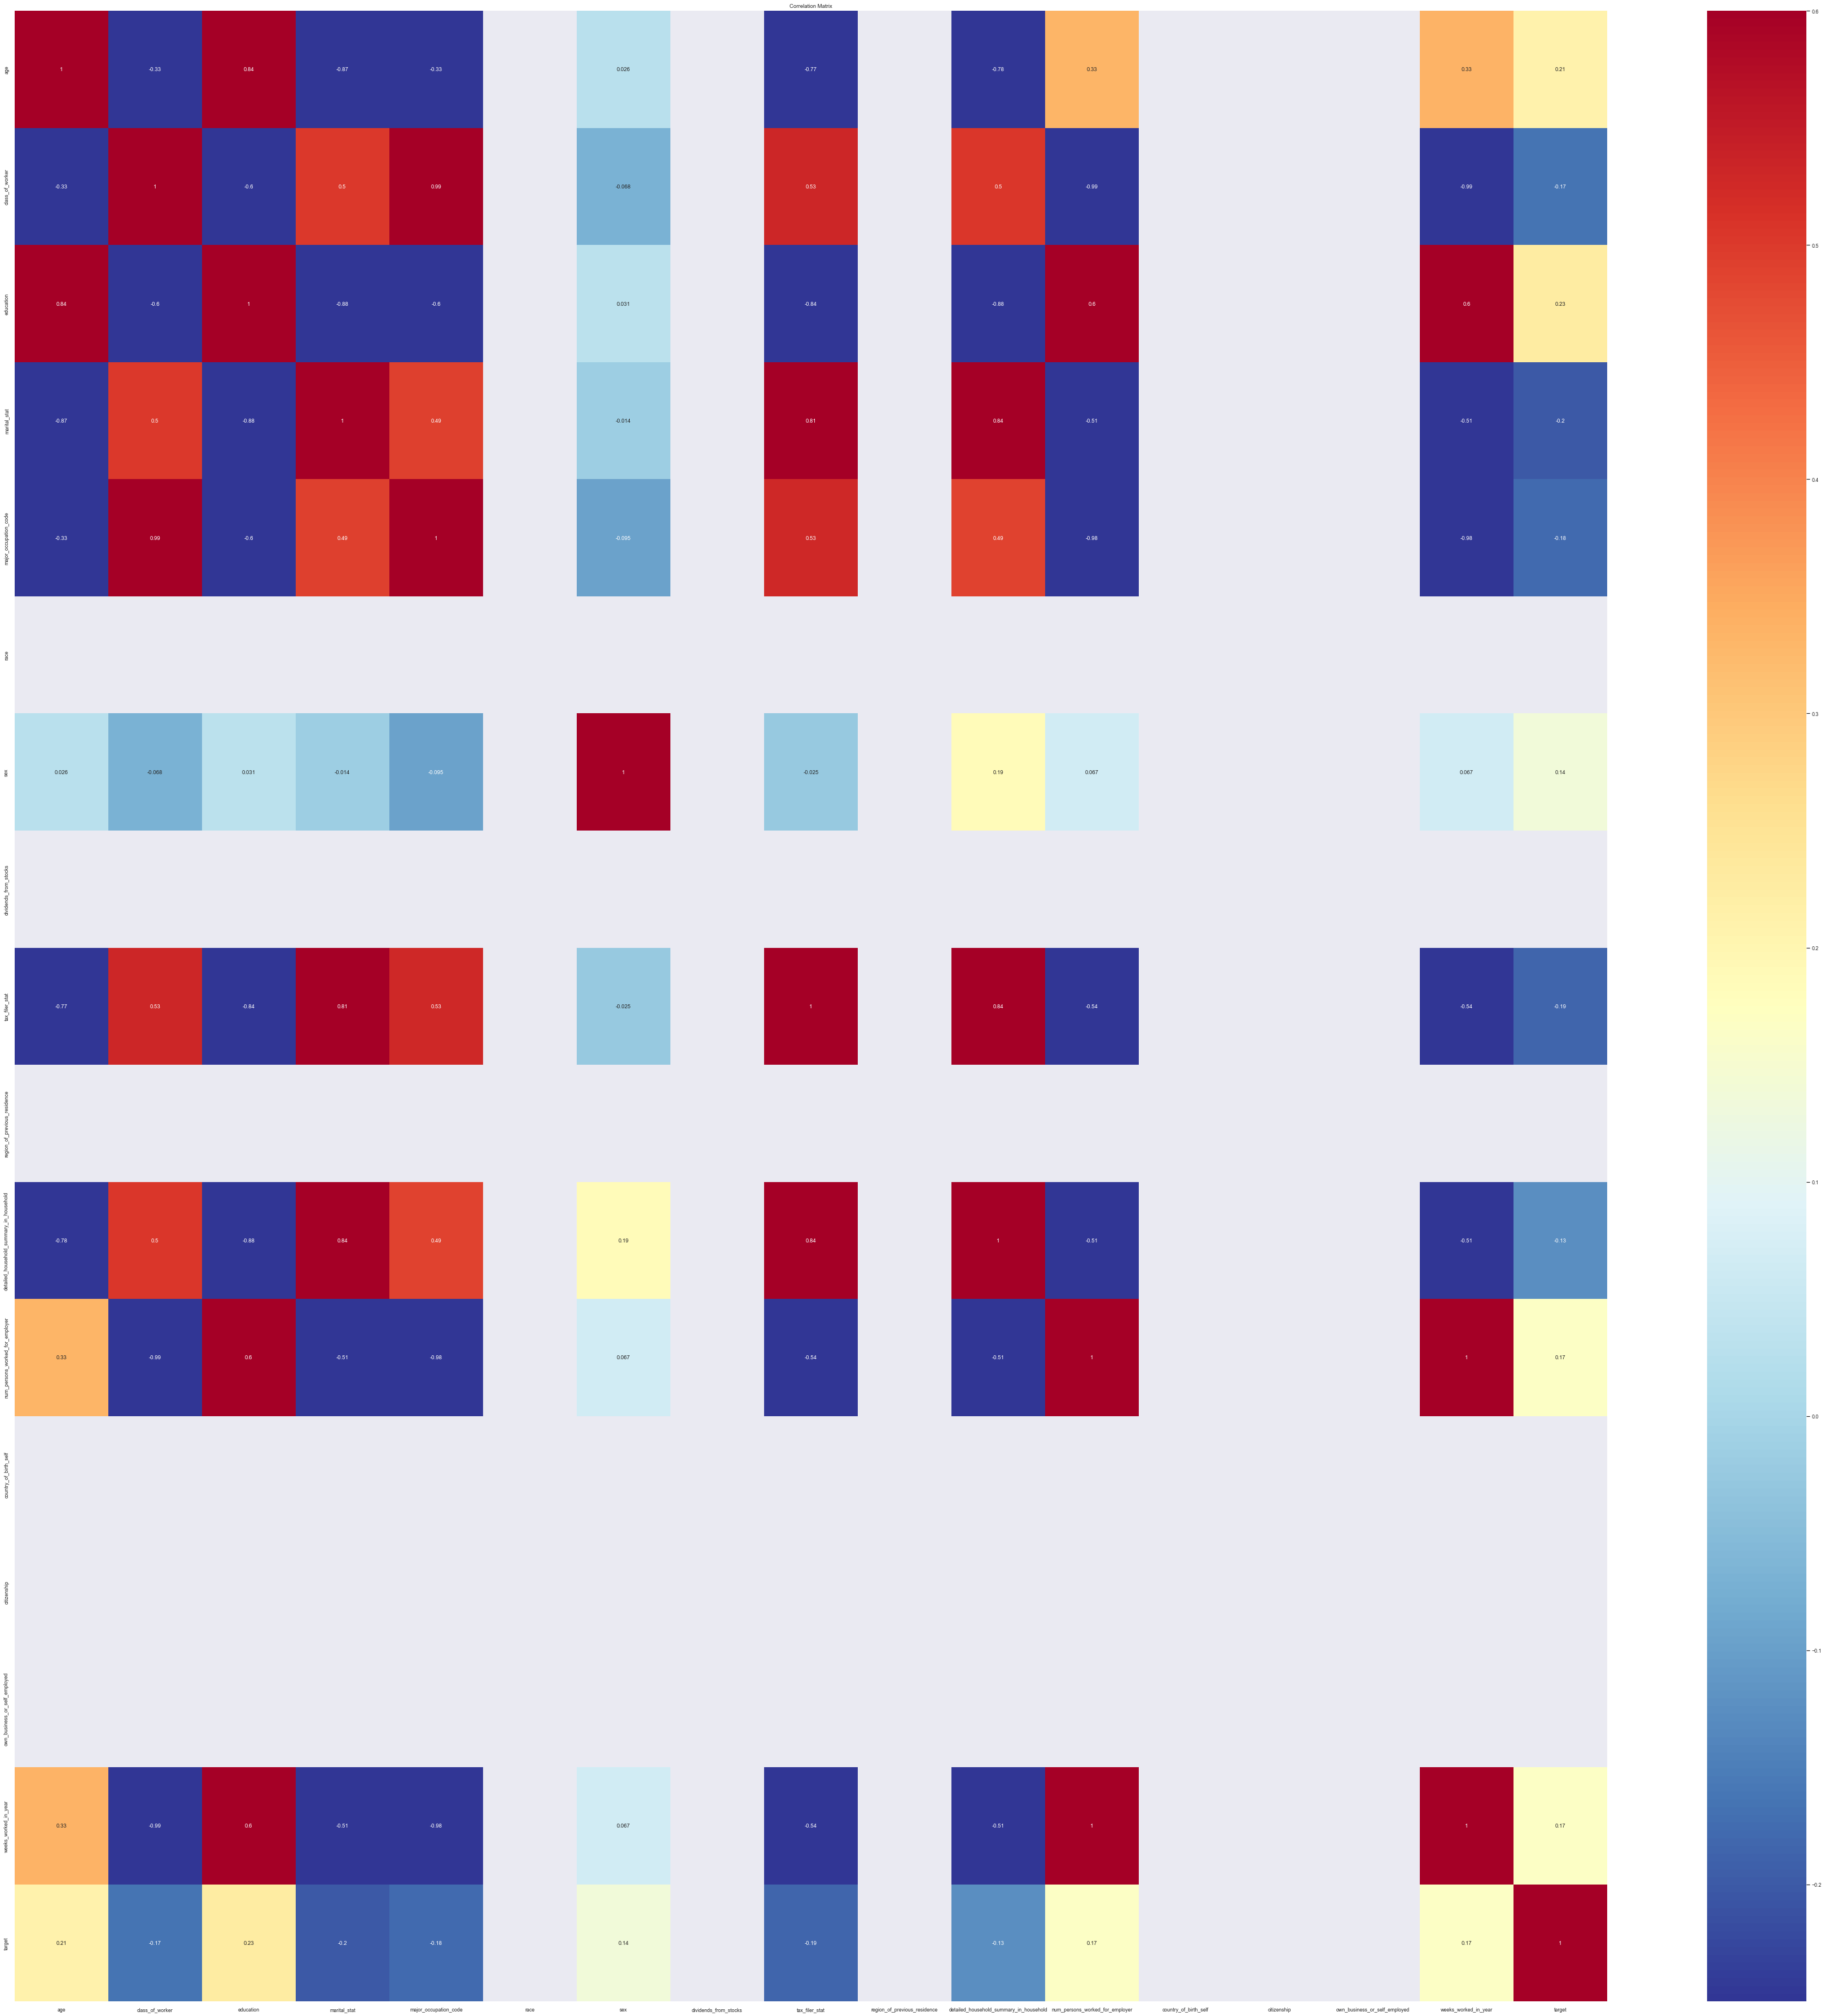

In [107]:
sns.set(rc={'figure.figsize': (50, 50)})
sns.set(font_scale=0.8)
sns.heatmap(matrix, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Matrix');

In [108]:
del_features = list()
count_features = list(matrix.columns)
count_features.remove('target')

for i in range(len(count_features)):
    for j in range(i+1, len(count_features)):
        feature_1 = matrix.columns[i]
        feature_2 = matrix.columns[j]
        if abs(matrix[feature_1].at[feature_2]) > 0.5:
            if abs(matrix['target'].at[feature_2]) > abs(matrix['target'].at[feature_1]):
                del_features.append(feature_1)
            else:
                del_features.append(feature_2)
                
del_features = np.unique(del_features)
print("The number of features to remove:", len(del_features))
print("The number of features remaining:", len(matrix) - len(del_features) - 1)

The number of features to remove: 8
The number of features remaining: 8


In [109]:
del_features

array(['age', 'class_of_worker',
       'detailed_household_summary_in_household', 'major_occupation_code',
       'marital_stat', 'num_persons_worked_for_employer',
       'tax_filer_stat', 'weeks_worked_in_year'], dtype='<U39')

In [110]:
for del_feature in del_features:
    count_features.remove(del_feature)
print("The number of features remaining:", len(count_features))

The number of features remaining: 8


In [111]:
sorted(count_features)

['citizenship',
 'country_of_birth_self',
 'dividends_from_stocks',
 'education',
 'own_business_or_self_employed',
 'race',
 'region_of_previous_residence',
 'sex']

In [112]:
sorted(real_model_features)

['age',
 'citizenship',
 'country_of_birth_self',
 'detailed_household_summary_in_household',
 'dividends_from_stocks',
 'education',
 'marital_stat',
 'own_business_or_self_employed',
 'race',
 'region_of_previous_residence',
 'sex',
 'tax_filer_stat',
 'weeks_worked_in_year']

### Logistic regression 

In [113]:
#X_tr, X_te, y_tr, y_te = train_test_split(synt_data[real_model_features],synt_data['target'],test_size=0.2, random_state=random_state,stratify=synt_data['target'])

In [114]:
X_tr1 = X_tr[count_features]
X_te1 = X_te[count_features]
X_te_real1 = X_te_real[count_features]

X_tr2 = X_tr[real_model_features]
X_te2 = X_te[real_model_features]
X_te_real2 = X_te_real[real_model_features]


In [115]:
X_te1.isna().sum()

education                        0
race                             0
sex                              0
dividends_from_stocks            0
region_of_previous_residence     0
country_of_birth_self            0
citizenship                      0
own_business_or_self_employed    0
dtype: int64

In [116]:
X_te2.isna().sum()

age                                        0
education                                  0
marital_stat                               2
race                                       0
sex                                        0
dividends_from_stocks                      0
tax_filer_stat                             0
region_of_previous_residence               0
detailed_household_summary_in_household    0
country_of_birth_self                      0
citizenship                                0
own_business_or_self_employed              0
weeks_worked_in_year                       0
dtype: int64

In [117]:
X_te_real1.isna().sum()

education                        0
race                             0
sex                              0
dividends_from_stocks            0
region_of_previous_residence     0
country_of_birth_self            0
citizenship                      0
own_business_or_self_employed    0
dtype: int64

In [118]:
X_te_real2.isna().sum()

age                                          0
education                                    0
marital_stat                               165
race                                         0
sex                                          0
dividends_from_stocks                        0
tax_filer_stat                               0
region_of_previous_residence                 0
detailed_household_summary_in_household    273
country_of_birth_self                        0
citizenship                                  0
own_business_or_self_employed                0
weeks_worked_in_year                         0
dtype: int64

In [119]:
sorted(synt_data['citizenship'].unique()) 


['Native- Born in the United States']

In [120]:
sorted(real_data['citizenship'].unique())

['Foreign born- Not a citizen of U S ',
 'Foreign born- U S citizen by naturalization',
 'Native- Born abroad of American Parent(s)',
 'Native- Born in Puerto Rico or U S Outlying',
 'Native- Born in the United States']

In [121]:
X_te1.fillna(0, inplace=True)
X_te_real1.fillna(0, inplace=True)
X_te2.fillna(0, inplace=True)
X_te_real2.fillna(0, inplace=True)

C:\Users\AlexeyNeyman\AppData\Local\Temp\ipykernel_13952\2398710961.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_te1.fillna(0, inplace=True)
C:\Users\AlexeyNeyman\AppData\Local\Temp\ipykernel_13952\2398710961.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_te_real1.fillna(0, inplace=True)
C:\Users\AlexeyNeyman\AppData\Local\Temp\ipykernel_13952\2398710961.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_te2.fillna(0

In [122]:
%%time
smt = ADASYN(random_state=random_state)
X_smt, y_smt = smt.fit_resample(X_tr1, y_tr)

CPU times: total: 562 ms
Wall time: 569 ms


In [123]:
%%time
grid_pipe_log = GridSearchCV(log_pipe, log_parameters, cv=5, scoring='balanced_accuracy', verbose=3)
grid_pipe_log.fit(X_smt, y_smt)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.736 total time=   0.4s
[CV 2/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.721 total time=   0.4s
[CV 3/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.704 total time=   0.4s
[CV 4/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.726 total time=   0.2s
[CV 5/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.712 total time=   0.2s
[CV 1/5] END ......LR__C=0.001, LR__solver=saga;, score=0.736 total time=   0.2s
[CV 2/5] END ......LR__C=0.001, LR__solver=saga;, score=0.721 total time=   0.2s
[CV 3/5] END ......LR__C=0.001, LR__solver=saga;, score=0.704 total time=   0.3s
[CV 4/5] END ......LR__C=0.001, LR__solver=saga;, score=0.732 total time=   0.2s
[CV 5/5] END ......LR__C=0.001, LR__solver=saga;, score=0.712 total time=   0.3s
[CV 1/5] END .......LR__C=0.01, LR__solver=saga;, score=0.736 total time=   0.2s
[CV 2/5] END .......LR__C=0.01, LR__solver=saga;,

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Scaler', StandardScaler()),
                                       ('LR', LogisticRegression())]),
             param_grid={'LR__C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
                         'LR__solver': ['saga']},
             scoring='balanced_accuracy', verbose=3)

In [124]:
print(grid_pipe_log.best_score_)
print(grid_pipe_log.best_estimator_.steps[1][1])

0.7210604025055478
LogisticRegression(C=0.001, solver='saga')


In [125]:
y_pred_test1 = grid_pipe_log.best_estimator_.predict(X_te1)


In [126]:
y_pred_test_real1 = grid_pipe_log.best_estimator_.predict(X_te_real1)

In [127]:
res_test11 = pd.DataFrame([['LogRegression DistillGPT synthetic features','Synth test',
                        balanced_accuracy_score(y_te, y_pred_test1),
                        recall_score(y_te, y_pred_test1),
                        precision_score(y_te, y_pred_test1),
                        roc_auc_score(y_te, y_pred_test1)]],
                        columns=['Model','Dataset','Balanced_accuracy','Recall', 'Precision', 'ROC_AUC'])
res_test_real11 = pd.DataFrame([['LogRegression DistillGPT synthetic features','Real test',
                        balanced_accuracy_score(y_te_real, y_pred_test_real1),
                        recall_score(y_te_real, y_pred_test_real1),
                        precision_score(y_te_real, y_pred_test_real1),
                        roc_auc_score(y_te_real, y_pred_test_real1)]],
                        columns=['Model','Dataset','Balanced_accuracy','Recall', 'Precision', 'ROC_AUC'])

model_results = pd.concat([model_results, res_test11, res_test_real11],axis=0)

In [128]:
res_test11

Model     Dataset  Balanced_accuracy  \
0  LogRegression DistillGPT synthetic features  Synth test           0.690583   

    Recall  Precision   ROC_AUC  
0  0.60582   0.153485  0.690583

In [129]:
res_test_real11

Model    Dataset  Balanced_accuracy  \
0  LogRegression DistillGPT synthetic features  Real test           0.748513   

     Recall  Precision   ROC_AUC  
0  0.952381   0.123288  0.748513

In [130]:
%%time
smt = ADASYN(random_state=random_state)
X_smt, y_smt = smt.fit_resample(X_tr2, y_tr)

CPU times: total: 312 ms
Wall time: 351 ms


In [131]:
%%time
grid_pipe_log = GridSearchCV(log_pipe, log_parameters, cv=5, scoring='balanced_accuracy', verbose=3)
grid_pipe_log.fit(X_smt, y_smt)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.714 total time=   0.3s
[CV 2/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.697 total time=   0.5s
[CV 3/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.673 total time=   0.3s
[CV 4/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.731 total time=   0.4s
[CV 5/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.697 total time=   0.4s
[CV 1/5] END ......LR__C=0.001, LR__solver=saga;, score=0.735 total time=   0.4s
[CV 2/5] END ......LR__C=0.001, LR__solver=saga;, score=0.720 total time=   0.4s
[CV 3/5] END ......LR__C=0.001, LR__solver=saga;, score=0.687 total time=   0.4s
[CV 4/5] END ......LR__C=0.001, LR__solver=saga;, score=0.745 total time=   0.5s
[CV 5/5] END ......LR__C=0.001, LR__solver=saga;, score=0.712 total time=   0.4s
[CV 1/5] END .......LR__C=0.01, LR__solver=saga;, score=0.737 total time=   0.4s
[CV 2/5] END .......LR__C=0.01, LR__solver=saga;,

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Scaler', StandardScaler()),
                                       ('LR', LogisticRegression())]),
             param_grid={'LR__C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
                         'LR__solver': ['saga']},
             scoring='balanced_accuracy', verbose=3)

In [132]:
print(grid_pipe_log.best_score_)
print(grid_pipe_log.best_estimator_.steps[1][1])

0.7198595868666995
LogisticRegression(C=0.001, solver='saga')


In [133]:
y_pred_test2 = grid_pipe_log.best_estimator_.predict(X_te2)


In [134]:
y_pred_test_real2 = grid_pipe_log.best_estimator_.predict(X_te_real2)

In [135]:
res_test12 = pd.DataFrame([['LogRegression DistillGPT real features','Synth test',
                        balanced_accuracy_score(y_te, y_pred_test2),
                        recall_score(y_te, y_pred_test2),
                        precision_score(y_te, y_pred_test2),
                        roc_auc_score(y_te, y_pred_test2)]],
                        columns=['Model','Dataset','Balanced_accuracy','Recall', 'Precision', 'ROC_AUC'])
res_test_real12 = pd.DataFrame([['LogRegression DistillGPT real features','Real test',
                        balanced_accuracy_score(y_te_real, y_pred_test_real2),
                        recall_score(y_te_real, y_pred_test_real2),
                        precision_score(y_te_real, y_pred_test_real2),
                        roc_auc_score(y_te_real, y_pred_test_real2)]],
                        columns=['Model','Dataset','Balanced_accuracy','Recall', 'Precision', 'ROC_AUC'])
model_results = pd.concat([model_results, res_test12, res_test_real12],axis=0)

In [136]:
res_test12

Model     Dataset  Balanced_accuracy  \
0  LogRegression DistillGPT real features  Synth test           0.716307   

    Recall  Precision   ROC_AUC  
0  0.78836   0.129678  0.716307

In [137]:
res_test_real12

Model    Dataset  Balanced_accuracy  \
0  LogRegression DistillGPT real features  Real test           0.745621   

     Recall  Precision   ROC_AUC  
0  0.984127   0.118358  0.745621

## GPT2XL classification

### Data preprocessing 

In [138]:
synt_data = synt_data_gpt2xl.copy()

In [139]:
X_tr, X_te, y_tr, y_te = train_test_split(synt_data.drop(columns = ['target']),synt_data['target'],test_size=0.2, random_state=random_state,stratify=synt_data['target'])

In [140]:
X_te_real = X_te_real_validate.copy()
y_te_real = y_te_real_validate.copy()

In [141]:
print(synt_data['target'].unique(), len(synt_data['target'].unique()))

['- 50000.' '50000+.'] 2


In [142]:
y_tr=y_tr.map(target_encoder)
y_te=y_te.map(target_encoder)
y_te_real = y_te_real.map(target_encoder) 

In [143]:
print(synt_data['education'].unique(), len(synt_data['education'].unique()))

['Children' 'High school graduate' '10th grade' '9th grade'
 'Bachelors degree(BA AB BS)' 'Masters degree(MA MS MEng MEd MSW MBA)'
 '11th grade' 'Some college but no degree' '7th and 8th grade'
 'Prof school degree (MD DDS DVM LLB JD)'] 10


In [144]:
X_tr['education'] = X_tr['education'].map(edu_encoder)
X_te['education'] = X_te['education'].map(edu_encoder)
X_te_real['education'] = X_te_real['education'].map(edu_encoder)

In [145]:
to_encode_synt = to_encode.copy() 

In [146]:
# mean target encoding
for i in to_encode_synt.copy():
    codes = X_tr.assign(target = y_tr).groupby(i)['target'].mean().to_dict()
    codes_ext = codes.copy()
    for t in X_te[i].unique():
        if not (t in codes_ext.keys()) :
            codes_ext[t] = 0
    for t in X_te_real[i].unique():
        if not (t in codes_ext.keys()) :
            codes_ext[t] = 0
    if min(codes.values()) != 0:
        print ('+',i)
        X_tr[i] = X_tr[i].map(lambda x: codes[x])
        X_te[i] = X_te[i].map(lambda x: codes_ext[x])
        X_te_real[i] = X_te_real[i].map(lambda x: codes_ext[x])
        to_encode_synt.remove(i)

+ race
+ sex
+ region_of_previous_residence
+ country_of_birth_self
+ citizenship
+ own_business_or_self_employed


In [147]:
#frequency encoding 
for i in to_encode_synt.copy():
    print ('+',i)
    codes = (X_tr[i].value_counts()/len(X_tr)).to_dict()
    X_tr[i] = X_tr[i].map(codes)
    X_te[i] = X_te[i].map(codes)
    X_te_real[i] = X_te_real[i].map(codes)
    to_encode_synt.remove(i)

+ class_of_worker
+ marital_stat
+ major_occupation_code
+ tax_filer_stat
+ detailed_household_summary_in_household


In [148]:
print(X_tr.isna().sum())

age                                        0
class_of_worker                            0
education                                  0
marital_stat                               0
major_occupation_code                      0
race                                       0
sex                                        0
dividends_from_stocks                      0
tax_filer_stat                             0
region_of_previous_residence               0
detailed_household_summary_in_household    0
num_persons_worked_for_employer            0
country_of_birth_self                      0
citizenship                                0
own_business_or_self_employed              0
weeks_worked_in_year                       0
dtype: int64


In [149]:
X_tr.fillna(0,inplace=True)

In [150]:
X_tr.dtypes

age                                        float64
class_of_worker                            float64
education                                    int64
marital_stat                               float64
major_occupation_code                      float64
race                                       float64
sex                                        float64
dividends_from_stocks                      float64
tax_filer_stat                             float64
region_of_previous_residence               float64
detailed_household_summary_in_household    float64
num_persons_worked_for_employer            float64
country_of_birth_self                      float64
citizenship                                float64
own_business_or_self_employed              float64
weeks_worked_in_year                       float64
dtype: object

### Features selection 

In [151]:
features = list(X_tr.columns)
features.append('target')
matrix = X_tr.assign(target = y_tr)[features].corr(method='spearman')
matrix

age  class_of_worker  education  \
age                                      1.000000        -0.607625   0.849768   
class_of_worker                         -0.607625         1.000000  -0.786647   
education                                0.849768        -0.786647   1.000000   
marital_stat                            -0.842049         0.762020  -0.957287   
major_occupation_code                   -0.608228         0.985227  -0.798286   
race                                          NaN              NaN        NaN   
sex                                     -0.029527        -0.072353  -0.006406   
dividends_from_stocks                         NaN              NaN        NaN   
tax_filer_stat                          -0.822431         0.759932  -0.943751   
region_of_previous_residence                  NaN              NaN        NaN   
detailed_household_summary_in_household -0.829731         0.792755  -0.960938   
num_persons_worked_for_employer          0.606797        -0.995583   0.787904   
country_of_birth_self                         NaN              NaN        NaN   
citizenship                                   NaN              NaN        NaN   
own_business_or_self_employed                 NaN              NaN        NaN   
weeks_worked_in_year                     0.607875        -0.998921   0.788090   
target                                   0.332502        -0.420538   0.476737   

                                         marital_stat  major_occupation_code  \
age                                         -0.842049              -0.608228   
class_of_worker                              0.762020               0.985227   
education                                   -0.957287              -0.798286   
marital_stat                                 1.000000               0.751388   
major_occupation_code                        0.751388               1.000000   
race                                              NaN                    NaN   
sex                                          0.065975              -0.139281   
dividends_from_stocks                             NaN                    NaN   
tax_filer_stat                               0.958636               0.750001   
region_of_previous_residence                      NaN                    NaN   
detailed_household_summary_in_household      0.963001               0.807355   
num_persons_worked_for_employer             -0.761542              -0.983770   
country_of_birth_self                             NaN                    NaN   
citizenship                                       NaN                    NaN   
own_business_or_self_employed                     NaN                    NaN   
weeks_worked_in_year                        -0.762680              -0.985682   
target                                      -0.327216              -0.521759   

                                         race       sex  \
age                                       NaN -0.029527   
class_of_worker                           NaN -0.072353   
education                                 NaN -0.006406   
marital_stat                              NaN  0.065975   
major_occupation_code                     NaN -0.139281   
race                                      NaN       NaN   
sex                                       NaN  1.000000   
dividends_from_stocks                     NaN       NaN   
tax_filer_stat                            NaN  0.059592   
region_of_previous_residence              NaN       NaN   
detailed_household_summary_in_household   NaN -0.069628   
num_persons_worked_for_employer           NaN  0.064670   
country_of_birth_self                     NaN       NaN   
citizenship                               NaN       NaN   
own_business_or_self_employed             NaN       NaN   
weeks_worked_in_year                      NaN  0.069030   
target                                    NaN  0.302595   

                                         dividends_from_stocks  \
age              

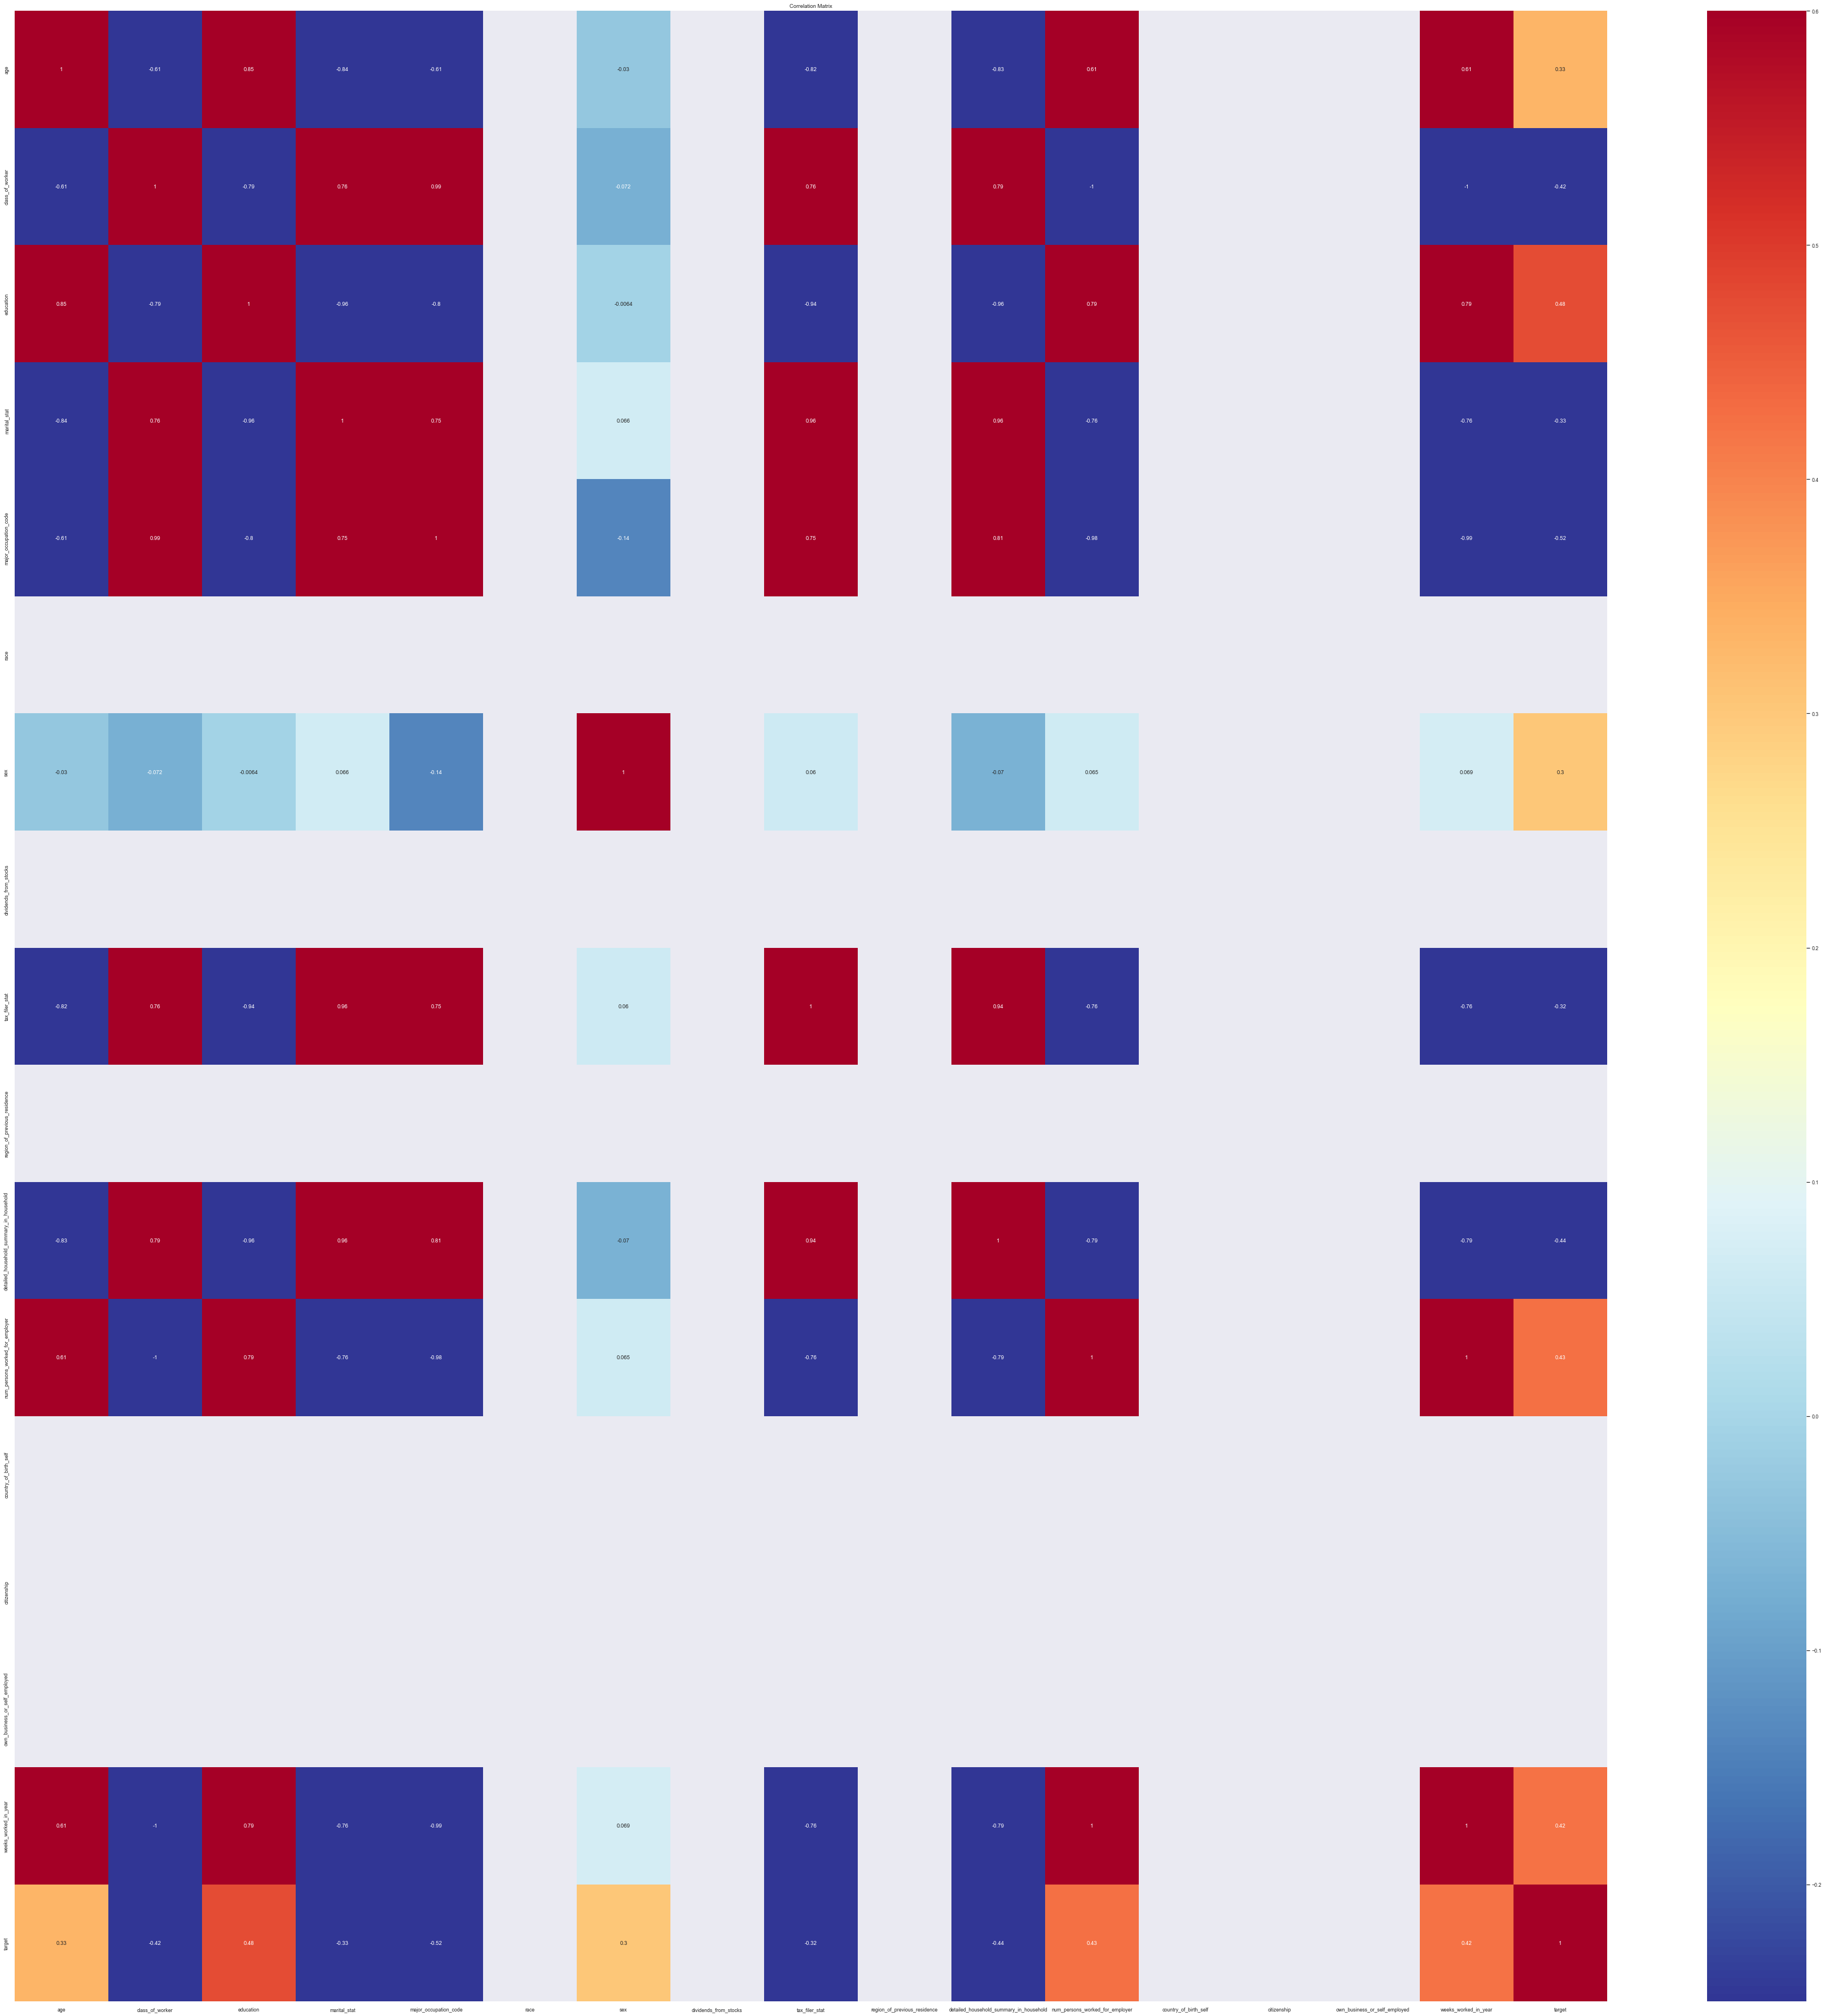

In [152]:
sns.set(rc={'figure.figsize': (50, 50)})
sns.set(font_scale=0.8)
sns.heatmap(matrix, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Matrix');

In [153]:
del_features = list()
count_features = list(matrix.columns)
count_features.remove('target')

for i in range(len(count_features)):
    for j in range(i+1, len(count_features)):
        feature_1 = matrix.columns[i]
        feature_2 = matrix.columns[j]
        if abs(matrix[feature_1].at[feature_2]) > 0.8:
            if abs(matrix['target'].at[feature_2]) > abs(matrix['target'].at[feature_1]):
                del_features.append(feature_1)
            else:
                del_features.append(feature_2)
                
del_features = np.unique(del_features)
print("The number of features to remove:", len(del_features))
print("The number of features remaining:", len(matrix) - len(del_features) - 1)

The number of features to remove: 7
The number of features remaining: 9


In [154]:
del_features

array(['age', 'class_of_worker',
       'detailed_household_summary_in_household', 'marital_stat',
       'num_persons_worked_for_employer', 'tax_filer_stat',
       'weeks_worked_in_year'], dtype='<U39')

In [155]:
for del_feature in del_features:
    count_features.remove(del_feature)
print("The number of features remaining:", len(count_features))

The number of features remaining: 9


In [156]:
sorted(count_features)

['citizenship',
 'country_of_birth_self',
 'dividends_from_stocks',
 'education',
 'major_occupation_code',
 'own_business_or_self_employed',
 'race',
 'region_of_previous_residence',
 'sex']

In [157]:
sorted(real_model_features)

['age',
 'citizenship',
 'country_of_birth_self',
 'detailed_household_summary_in_household',
 'dividends_from_stocks',
 'education',
 'marital_stat',
 'own_business_or_self_employed',
 'race',
 'region_of_previous_residence',
 'sex',
 'tax_filer_stat',
 'weeks_worked_in_year']

### Logistic regression 

In [158]:
X_tr1 = X_tr[count_features]
X_te1 = X_te[count_features]
X_te_real1 = X_te_real[count_features]

X_tr2 = X_tr[real_model_features]
X_te2 = X_te[real_model_features]
X_te_real2 = X_te_real[real_model_features]


In [159]:
X_te2.isna().sum()

age                                        0
education                                  0
marital_stat                               0
race                                       0
sex                                        0
dividends_from_stocks                      0
tax_filer_stat                             1
region_of_previous_residence               0
detailed_household_summary_in_household    0
country_of_birth_self                      0
citizenship                                0
own_business_or_self_employed              0
weeks_worked_in_year                       0
dtype: int64

In [160]:
sorted(synt_data['country_of_birth_self'].unique()) 

['United-States']

In [161]:
sorted(real_data['country_of_birth_self'].unique()) 

['?',
 'Cambodia',
 'Canada',
 'China',
 'Columbia',
 'Cuba',
 'Dominican-Republic',
 'Ecuador',
 'El-Salvador',
 'England',
 'France',
 'Germany',
 'Greece',
 'Guatemala',
 'Haiti',
 'Holand-Netherlands',
 'Honduras',
 'Hong Kong',
 'Hungary',
 'India',
 'Iran',
 'Ireland',
 'Italy',
 'Jamaica',
 'Japan',
 'Laos',
 'Mexico',
 'Nicaragua',
 'Outlying-U S (Guam USVI etc)',
 'Panama',
 'Peru',
 'Philippines',
 'Poland',
 'Portugal',
 'Puerto-Rico',
 'Scotland',
 'South Korea',
 'Taiwan',
 'Thailand',
 'Trinadad&Tobago',
 'United-States',
 'Vietnam',
 'Yugoslavia']

In [162]:
X_te_real1.fillna(0, inplace=True)
X_te_real2.fillna(0, inplace=True)
X_te1.fillna(0, inplace=True)
X_te2.fillna(0, inplace=True)

C:\Users\AlexeyNeyman\AppData\Local\Temp\ipykernel_13952\839306755.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_te_real1.fillna(0, inplace=True)
C:\Users\AlexeyNeyman\AppData\Local\Temp\ipykernel_13952\839306755.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_te_real2.fillna(0, inplace=True)
C:\Users\AlexeyNeyman\AppData\Local\Temp\ipykernel_13952\839306755.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_te1.fillna

In [163]:
%%time
smt = ADASYN(random_state=random_state)
X_smt, y_smt = smt.fit_resample(X_tr1, y_tr)

CPU times: total: 312 ms
Wall time: 308 ms


In [164]:
%%time
grid_pipe_log = GridSearchCV(log_pipe, log_parameters, cv=5, scoring='balanced_accuracy', verbose=3)
grid_pipe_log.fit(X_smt, y_smt)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.959 total time=   0.3s
[CV 2/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.956 total time=   0.2s
[CV 3/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.960 total time=   0.3s
[CV 4/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.960 total time=   0.2s
[CV 5/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.963 total time=   0.2s
[CV 1/5] END ......LR__C=0.001, LR__solver=saga;, score=0.961 total time=   0.2s
[CV 2/5] END ......LR__C=0.001, LR__solver=saga;, score=0.959 total time=   0.2s
[CV 3/5] END ......LR__C=0.001, LR__solver=saga;, score=0.955 total time=   0.2s
[CV 4/5] END ......LR__C=0.001, LR__solver=saga;, score=0.963 total time=   0.2s
[CV 5/5] END ......LR__C=0.001, LR__solver=saga;, score=0.965 total time=   0.3s
[CV 1/5] END .......LR__C=0.01, LR__solver=saga;, score=0.963 total time=   0.2s
[CV 2/5] END .......LR__C=0.01, LR__solver=saga;,

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Scaler', StandardScaler()),
                                       ('LR', LogisticRegression())]),
             param_grid={'LR__C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
                         'LR__solver': ['saga']},
             scoring='balanced_accuracy', verbose=3)

In [165]:
print(grid_pipe_log.best_score_)
print(grid_pipe_log.best_estimator_.steps[1][1])

0.9605044133264181
LogisticRegression(C=0.001, solver='saga')


In [166]:
y_pred_test1 = grid_pipe_log.best_estimator_.predict(X_te1)
y_pred_test_real1 = grid_pipe_log.best_estimator_.predict(X_te_real1)

In [167]:
res_test21 = pd.DataFrame([['LogRegression GPT2xl synthetic features','Synth test',
                        balanced_accuracy_score(y_te, y_pred_test1),
                        recall_score(y_te, y_pred_test1),
                        precision_score(y_te, y_pred_test1),
                        roc_auc_score(y_te, y_pred_test1)]],
                        columns=['Model','Dataset','Balanced_accuracy','Recall', 'Precision', 'ROC_AUC'])
res_test_real21 = pd.DataFrame([['LogRegression GPT2xl synthetic features','Real test',
                        balanced_accuracy_score(y_te_real, y_pred_test_real1),
                        recall_score(y_te_real, y_pred_test_real1),
                        precision_score(y_te_real, y_pred_test_real1),
                        roc_auc_score(y_te_real, y_pred_test_real1)]],
                        columns=['Model','Dataset','Balanced_accuracy','Recall', 'Precision', 'ROC_AUC'])

model_results = pd.concat([model_results, res_test21, res_test_real21],axis=0)

In [168]:
res_test21

Model     Dataset  Balanced_accuracy  \
0  LogRegression GPT2xl synthetic features  Synth test           0.965149   

   Recall  Precision   ROC_AUC  
0     1.0   0.489583  0.965149

In [169]:
res_test_real21

Model    Dataset  Balanced_accuracy  \
0  LogRegression GPT2xl synthetic features  Real test           0.796213   

    Recall  Precision   ROC_AUC  
0  0.84127   0.185207  0.796213

In [170]:
%%time
smt = ADASYN(random_state=random_state)
X_smt, y_smt = smt.fit_resample(X_tr2, y_tr)

CPU times: total: 344 ms
Wall time: 357 ms


In [171]:
%%time
grid_pipe_log = GridSearchCV(log_pipe, log_parameters, cv=5, scoring='balanced_accuracy', verbose=3)
grid_pipe_log.fit(X_smt, y_smt)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.950 total time=   0.3s
[CV 2/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.951 total time=   0.2s
[CV 3/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.950 total time=   0.3s
[CV 4/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.952 total time=   0.2s
[CV 5/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.955 total time=   0.3s
[CV 1/5] END ......LR__C=0.001, LR__solver=saga;, score=0.954 total time=   0.2s
[CV 2/5] END ......LR__C=0.001, LR__solver=saga;, score=0.953 total time=   0.2s
[CV 3/5] END ......LR__C=0.001, LR__solver=saga;, score=0.955 total time=   0.2s
[CV 4/5] END ......LR__C=0.001, LR__solver=saga;, score=0.956 total time=   0.2s
[CV 5/5] END ......LR__C=0.001, LR__solver=saga;, score=0.960 total time=   0.2s
[CV 1/5] END .......LR__C=0.01, LR__solver=saga;, score=0.963 total time=   0.2s
[CV 2/5] END .......LR__C=0.01, LR__solver=saga;,

C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END ..........LR__C=1, LR__solver=saga;, score=0.981 total time=   2.2s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END ..........LR__C=1, LR__solver=saga;, score=0.979 total time=   2.1s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END ..........LR__C=1, LR__solver=saga;, score=0.984 total time=   2.1s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END ..........LR__C=1, LR__solver=saga;, score=0.984 total time=   2.2s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END ..........LR__C=1, LR__solver=saga;, score=0.971 total time=   2.0s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END .........LR__C=10, LR__solver=saga;, score=0.981 total time=   2.2s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END .........LR__C=10, LR__solver=saga;, score=0.978 total time=   2.2s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END .........LR__C=10, LR__solver=saga;, score=0.984 total time=   2.1s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END .........LR__C=10, LR__solver=saga;, score=0.984 total time=   2.1s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END .........LR__C=10, LR__solver=saga;, score=0.971 total time=   2.0s
CPU times: total: 34.6 s
Wall time: 34.8 s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Scaler', StandardScaler()),
                                       ('LR', LogisticRegression())]),
             param_grid={'LR__C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
                         'LR__solver': ['saga']},
             scoring='balanced_accuracy', verbose=3)

In [172]:
print(grid_pipe_log.best_score_)
print(grid_pipe_log.best_estimator_.steps[1][1])

0.9798167383734979
LogisticRegression(C=1, solver='saga')


In [173]:
y_pred_test2 = grid_pipe_log.best_estimator_.predict(X_te2)
y_pred_test_real2 = grid_pipe_log.best_estimator_.predict(X_te_real2)

In [174]:
res_test22 = pd.DataFrame([['LogRegression GPT2xl real features','Synth test',
                        balanced_accuracy_score(y_te, y_pred_test2),
                        recall_score(y_te, y_pred_test2),
                        precision_score(y_te, y_pred_test2),
                        roc_auc_score(y_te, y_pred_test2)]],
                        columns=['Model','Dataset','Balanced_accuracy','Recall', 'Precision', 'ROC_AUC'])
res_test_real22 = pd.DataFrame([['LogRegression GPT2xl real features','Real test',
                        balanced_accuracy_score(y_te_real, y_pred_test_real2),
                        recall_score(y_te_real, y_pred_test_real2),
                        precision_score(y_te_real, y_pred_test_real2),
                        roc_auc_score(y_te_real, y_pred_test_real2)]],
                        columns=['Model','Dataset','Balanced_accuracy','Recall', 'Precision', 'ROC_AUC'])
model_results = pd.concat([model_results, res_test22, res_test_real22],axis=0)

In [175]:
res_test22

Model     Dataset  Balanced_accuracy   Recall  \
0  LogRegression GPT2xl real features  Synth test           0.985068  0.99734   

   Precision   ROC_AUC  
0   0.710227  0.985068

In [176]:
res_test_real22

Model    Dataset  Balanced_accuracy   Recall  \
0  LogRegression GPT2xl real features  Real test           0.816627  0.78836   

   Precision   ROC_AUC  
0   0.254701  0.816627

## Cerebras classification

### Data preprocessing 

In [177]:
synt_data = synt_data_cerebras.copy()

In [178]:
X_tr, X_te, y_tr, y_te = train_test_split(synt_data.drop(columns = ['target']),synt_data['target'],test_size=0.2, random_state=random_state,stratify=synt_data['target'])

In [179]:
X_te_real = X_te_real_validate.copy()
y_te_real = y_te_real_validate.copy()

In [180]:
print(synt_data['target'].unique(), len(synt_data['target'].unique()))

['50000+.' '- 50000.'] 2


In [181]:
y_tr=y_tr.map(target_encoder)
y_te=y_te.map(target_encoder)
y_te_real = y_te_real.map(target_encoder) 

In [182]:
print(synt_data['education'].unique(), len(synt_data['education'].unique()))

['Bachelors degree(BA AB BS)' 'High school graduate' 'Children'
 '10th grade' '11th grade' '7th and 8th grade' '9th grade'
 'Masters degree(MA MS MEng MEd MSW MBA)' 'Some college but no degree'
 'Prof school degree (MD DDS DVM LLB JD)' 'Doctorate degree(PhD EdD)'] 11


In [183]:
X_tr['education'] = X_tr['education'].map(edu_encoder)
X_te['education'] = X_te['education'].map(edu_encoder)
X_te_real['education'] = X_te_real['education'].map(edu_encoder)

In [184]:
to_encode_synt = to_encode.copy() 

In [185]:
# mean target encoding
for i in to_encode_synt.copy():
    codes = X_tr.assign(target = y_tr).groupby(i)['target'].mean().to_dict()
    codes_ext = codes.copy()
    for t in X_te[i].unique():
        if not (t in codes_ext.keys()) :
            codes_ext[t] = 0
    for t in X_te_real[i].unique():
        if not (t in codes_ext.keys()) :
            codes_ext[t] = 0
    if min(codes.values()) != 0:
        print ('+',i)
        X_tr[i] = X_tr[i].map(lambda x: codes[x])
        X_te[i] = X_te[i].map(lambda x: codes_ext[x])
        X_te_real[i] = X_te_real[i].map(lambda x: codes_ext[x])
        to_encode_synt.remove(i)

+ race
+ sex
+ region_of_previous_residence
+ country_of_birth_self
+ citizenship
+ own_business_or_self_employed


In [186]:
#frequency encoding 
for i in to_encode_synt.copy():
    print ('+',i)
    codes = (X_tr[i].value_counts()/len(X_tr)).to_dict()
    X_tr[i] = X_tr[i].map(codes)
    X_te[i] = X_te[i].map(codes)
    X_te_real[i] = X_te_real[i].map(codes)
    to_encode_synt.remove(i)

+ class_of_worker
+ marital_stat
+ major_occupation_code
+ tax_filer_stat
+ detailed_household_summary_in_household


In [187]:
print(X_tr.isna().sum())

age                                        0
class_of_worker                            0
education                                  0
marital_stat                               0
major_occupation_code                      0
race                                       0
sex                                        0
dividends_from_stocks                      0
tax_filer_stat                             0
region_of_previous_residence               0
detailed_household_summary_in_household    0
num_persons_worked_for_employer            0
country_of_birth_self                      0
citizenship                                0
own_business_or_self_employed              0
weeks_worked_in_year                       0
dtype: int64


In [188]:
X_tr.dtypes

age                                        float64
class_of_worker                            float64
education                                    int64
marital_stat                               float64
major_occupation_code                      float64
race                                       float64
sex                                        float64
dividends_from_stocks                      float64
tax_filer_stat                             float64
region_of_previous_residence               float64
detailed_household_summary_in_household    float64
num_persons_worked_for_employer            float64
country_of_birth_self                      float64
citizenship                                float64
own_business_or_self_employed              float64
weeks_worked_in_year                       float64
dtype: object

### Features selection 

In [189]:
features = list(X_tr.columns)
features.append('target')
matrix = X_tr.assign(target = y_tr)[features].corr(method='spearman')
matrix

age  class_of_worker  education  \
age                                      1.000000        -0.649559   0.851506   
class_of_worker                         -0.649559         1.000000  -0.821311   
education                                0.851506        -0.821311   1.000000   
marital_stat                            -0.847883         0.803809  -0.960950   
major_occupation_code                   -0.650604         0.983134  -0.835130   
race                                          NaN              NaN        NaN   
sex                                     -0.105368         0.038618  -0.087030   
dividends_from_stocks                         NaN              NaN        NaN   
tax_filer_stat                          -0.837951         0.786548  -0.951377   
region_of_previous_residence                  NaN              NaN        NaN   
detailed_household_summary_in_household -0.837104         0.823306  -0.970944   
num_persons_worked_for_employer          0.648896        -0.996022   0.822148   
country_of_birth_self                         NaN              NaN        NaN   
citizenship                                   NaN              NaN        NaN   
own_business_or_self_employed                 NaN              NaN        NaN   
weeks_worked_in_year                     0.649802        -0.999059   0.822485   
target                                   0.335365        -0.388747   0.476973   

                                         marital_stat  major_occupation_code  \
age                                         -0.847883              -0.650604   
class_of_worker                              0.803809               0.983134   
education                                   -0.960950              -0.835130   
marital_stat                                 1.000000               0.789914   
major_occupation_code                        0.789914               1.000000   
race                                              NaN                    NaN   
sex                                          0.158838              -0.043032   
dividends_from_stocks                             NaN                    NaN   
tax_filer_stat                               0.966066               0.774673   
region_of_previous_residence                      NaN                    NaN   
detailed_household_summary_in_household      0.962808               0.841481   
num_persons_worked_for_employer             -0.803499              -0.981198   
country_of_birth_self                             NaN                    NaN   
citizenship                                       NaN                    NaN   
own_business_or_self_employed                     NaN                    NaN   
weeks_worked_in_year                        -0.804518              -0.983325   
target                                      -0.319191              -0.505993   

                                         race       sex  \
age                                       NaN -0.105368   
class_of_worker                           NaN  0.038618   
education                                 NaN -0.087030   
marital_stat                              NaN  0.158838   
major_occupation_code                     NaN -0.043032   
race                                      NaN       NaN   
sex                                       NaN  1.000000   
dividends_from_stocks                     NaN       NaN   
tax_filer_stat                            NaN  0.157843   
region_of_previous_residence              NaN       NaN   
detailed_household_summary_in_household   NaN  0.025335   
num_persons_worked_for_employer           NaN -0.046653   
country_of_birth_self                     NaN       NaN   
citizenship                               NaN       NaN   
own_business_or_self_employed             NaN       NaN   
weeks_worked_in_year                      NaN -0.042202   
target                                    NaN  0.321025   

                                         dividends_from_stocks  \
age              

In [190]:
sns.set(rc={'figure.figsize': (50, 50)})
sns.set(font_scale=0.8)
sns.heatmap(matrix, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Matrix');

In [191]:
del_features = list()
count_features = list(matrix.columns)
count_features.remove('target')

for i in range(len(count_features)):
    for j in range(i+1, len(count_features)):
        feature_1 = matrix.columns[i]
        feature_2 = matrix.columns[j]
        if abs(matrix[feature_1].at[feature_2]) > 0.8:
            if abs(matrix['target'].at[feature_2]) > abs(matrix['target'].at[feature_1]):
                del_features.append(feature_1)
            else:
                del_features.append(feature_2)
                
del_features = np.unique(del_features)
print("The number of features to remove:", len(del_features))
print("The number of features remaining:", len(matrix) - len(del_features) - 1)

The number of features to remove: 8
The number of features remaining: 8


In [192]:
del_features

array(['age', 'class_of_worker',
       'detailed_household_summary_in_household', 'education',
       'marital_stat', 'num_persons_worked_for_employer',
       'tax_filer_stat', 'weeks_worked_in_year'], dtype='<U39')

In [193]:
for del_feature in del_features:
    count_features.remove(del_feature)
print("The number of features remaining:", len(count_features))

The number of features remaining: 8


In [194]:
sorted(count_features)

['citizenship',
 'country_of_birth_self',
 'dividends_from_stocks',
 'major_occupation_code',
 'own_business_or_self_employed',
 'race',
 'region_of_previous_residence',
 'sex']

In [195]:
sorted(real_model_features)

['age',
 'citizenship',
 'country_of_birth_self',
 'detailed_household_summary_in_household',
 'dividends_from_stocks',
 'education',
 'marital_stat',
 'own_business_or_self_employed',
 'race',
 'region_of_previous_residence',
 'sex',
 'tax_filer_stat',
 'weeks_worked_in_year']

### Logistic regression 

In [196]:
X_tr1 = X_tr[count_features]
X_te1 = X_te[count_features]
X_te_real1 = X_te_real[count_features]

X_tr2 = X_tr[real_model_features]
X_te2 = X_te[real_model_features]
X_te_real2 = X_te_real[real_model_features]


In [197]:
X_te_real2.isna().sum()

age                                          0
education                                    0
marital_stat                               549
race                                         0
sex                                          0
dividends_from_stocks                        0
tax_filer_stat                               0
region_of_previous_residence                 0
detailed_household_summary_in_household    482
country_of_birth_self                        0
citizenship                                  0
own_business_or_self_employed                0
weeks_worked_in_year                         0
dtype: int64

In [198]:
sorted(synt_data['citizenship'].unique()) 

['Native- Born in the United States']

In [199]:
sorted(real_data['citizenship'].unique()) 

['Foreign born- Not a citizen of U S ',
 'Foreign born- U S citizen by naturalization',
 'Native- Born abroad of American Parent(s)',
 'Native- Born in Puerto Rico or U S Outlying',
 'Native- Born in the United States']

In [200]:
X_te1.fillna(0, inplace=True)
X_te_real1.fillna(0, inplace=True)
X_te2.fillna(0, inplace=True)
X_te_real2.fillna(0, inplace=True)
X_tr1.fillna(0, inplace=True)
X_tr2.fillna(0, inplace=True)

C:\Users\AlexeyNeyman\AppData\Local\Temp\ipykernel_13952\3402496439.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_te1.fillna(0, inplace=True)
C:\Users\AlexeyNeyman\AppData\Local\Temp\ipykernel_13952\3402496439.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_te_real1.fillna(0, inplace=True)
C:\Users\AlexeyNeyman\AppData\Local\Temp\ipykernel_13952\3402496439.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_te2.fillna(0

In [201]:
%%time
smt = ADASYN(random_state=random_state)
X_smt, y_smt = smt.fit_resample(X_tr1, y_tr)

CPU times: total: 219 ms
Wall time: 229 ms


In [202]:
%%time
grid_pipe_log = GridSearchCV(log_pipe, log_parameters, cv=5, scoring='balanced_accuracy', verbose=3)
grid_pipe_log.fit(X_smt, y_smt)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.940 total time=   0.2s
[CV 2/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.962 total time=   0.1s
[CV 3/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.969 total time=   0.2s
[CV 4/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.968 total time=   0.2s
[CV 5/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.967 total time=   0.1s
[CV 1/5] END ......LR__C=0.001, LR__solver=saga;, score=0.925 total time=   0.2s
[CV 2/5] END ......LR__C=0.001, LR__solver=saga;, score=0.952 total time=   0.2s
[CV 3/5] END ......LR__C=0.001, LR__solver=saga;, score=0.969 total time=   0.2s
[CV 4/5] END ......LR__C=0.001, LR__solver=saga;, score=0.968 total time=   0.1s
[CV 5/5] END ......LR__C=0.001, LR__solver=saga;, score=0.967 total time=   0.2s
[CV 1/5] END .......LR__C=0.01, LR__solver=saga;, score=0.924 total time=   0.2s
[CV 2/5] END .......LR__C=0.01, LR__solver=saga;,

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Scaler', StandardScaler()),
                                       ('LR', LogisticRegression())]),
             param_grid={'LR__C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
                         'LR__solver': ['saga']},
             scoring='balanced_accuracy', verbose=3)

In [203]:
print(grid_pipe_log.best_score_)
print(grid_pipe_log.best_estimator_.steps[1][1])

0.9694347323465291
LogisticRegression(C=0.1, solver='saga')


In [204]:
y_pred_test1 = grid_pipe_log.best_estimator_.predict(X_te1)
y_pred_test_real1 = grid_pipe_log.best_estimator_.predict(X_te_real1)

In [205]:
res_test31 = pd.DataFrame([['LogRegression Cerebras synthetic features','Synth test',
                        balanced_accuracy_score(y_te, y_pred_test1),
                        recall_score(y_te, y_pred_test1),
                        precision_score(y_te, y_pred_test1),
                        roc_auc_score(y_te, y_pred_test1)]],
                        columns=['Model','Dataset','Balanced_accuracy','Recall', 'Precision', 'ROC_AUC'])
res_test_real31 = pd.DataFrame([['LogRegression Cerebras synthetic features','Real test',
                        balanced_accuracy_score(y_te_real, y_pred_test_real1),
                        recall_score(y_te_real, y_pred_test_real1),
                        precision_score(y_te_real, y_pred_test_real1),
                        roc_auc_score(y_te_real, y_pred_test_real1)]],
                        columns=['Model','Dataset','Balanced_accuracy','Recall', 'Precision', 'ROC_AUC'])

model_results = pd.concat([model_results, res_test31, res_test_real31],axis=0)

In [206]:
res_test31

Model     Dataset  Balanced_accuracy  \
0  LogRegression Cerebras synthetic features  Synth test           0.968078   

   Recall  Precision   ROC_AUC  
0     1.0   0.512228  0.968078

In [207]:
res_test_real31

Model    Dataset  Balanced_accuracy  \
0  LogRegression Cerebras synthetic features  Real test           0.757644   

     Recall  Precision   ROC_AUC  
0  0.896825   0.136473  0.757644

In [208]:
%%time
smt = ADASYN(random_state=random_state)
X_smt, y_smt = smt.fit_resample(X_tr2, y_tr)

CPU times: total: 344 ms
Wall time: 328 ms


In [209]:
%%time
grid_pipe_log = GridSearchCV(log_pipe, log_parameters, cv=5, scoring='balanced_accuracy', verbose=3)
grid_pipe_log.fit(X_smt, y_smt)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.969 total time=   0.2s
[CV 2/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.969 total time=   0.3s
[CV 3/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.965 total time=   0.3s
[CV 4/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.966 total time=   0.2s
[CV 5/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.962 total time=   0.3s
[CV 1/5] END ......LR__C=0.001, LR__solver=saga;, score=0.973 total time=   0.2s
[CV 2/5] END ......LR__C=0.001, LR__solver=saga;, score=0.967 total time=   0.2s
[CV 3/5] END ......LR__C=0.001, LR__solver=saga;, score=0.970 total time=   0.2s
[CV 4/5] END ......LR__C=0.001, LR__solver=saga;, score=0.970 total time=   0.2s
[CV 5/5] END ......LR__C=0.001, LR__solver=saga;, score=0.968 total time=   0.2s
[CV 1/5] END .......LR__C=0.01, LR__solver=saga;, score=0.976 total time=   0.2s
[CV 2/5] END .......LR__C=0.01, LR__solver=saga;,

C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END ..........LR__C=1, LR__solver=saga;, score=0.983 total time=   2.1s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END ..........LR__C=1, LR__solver=saga;, score=0.977 total time=   2.3s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END ..........LR__C=1, LR__solver=saga;, score=0.979 total time=   2.3s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END ..........LR__C=1, LR__solver=saga;, score=0.981 total time=   2.2s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END ..........LR__C=1, LR__solver=saga;, score=0.977 total time=   2.3s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END .........LR__C=10, LR__solver=saga;, score=0.983 total time=   2.1s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END .........LR__C=10, LR__solver=saga;, score=0.977 total time=   2.4s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END .........LR__C=10, LR__solver=saga;, score=0.981 total time=   2.5s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END .........LR__C=10, LR__solver=saga;, score=0.981 total time=   2.2s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END .........LR__C=10, LR__solver=saga;, score=0.979 total time=   2.2s
CPU times: total: 35.8 s
Wall time: 36.1 s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Scaler', StandardScaler()),
                                       ('LR', LogisticRegression())]),
             param_grid={'LR__C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
                         'LR__solver': ['saga']},
             scoring='balanced_accuracy', verbose=3)

In [210]:
print(grid_pipe_log.best_score_)
print(grid_pipe_log.best_estimator_.steps[1][1])

0.9801266789091645
LogisticRegression(C=10, solver='saga')


In [211]:
y_pred_test2 = grid_pipe_log.best_estimator_.predict(X_te2)
y_pred_test_real2 = grid_pipe_log.best_estimator_.predict(X_te_real2)

In [212]:
res_test32 = pd.DataFrame([['LogRegression Cerebras real features','Synth test',
                        balanced_accuracy_score(y_te, y_pred_test2),
                        recall_score(y_te, y_pred_test2),
                        precision_score(y_te, y_pred_test2),
                        roc_auc_score(y_te, y_pred_test2)]],
                        columns=['Model','Dataset','Balanced_accuracy','Recall', 'Precision', 'ROC_AUC'])
res_test_real32 = pd.DataFrame([['LogRegression Cerebras real features','Real test',
                        balanced_accuracy_score(y_te_real, y_pred_test_real2),
                        recall_score(y_te_real, y_pred_test_real2),
                        precision_score(y_te_real, y_pred_test_real2),
                        roc_auc_score(y_te_real, y_pred_test_real2)]],
                        columns=['Model','Dataset','Balanced_accuracy','Recall', 'Precision', 'ROC_AUC'])
model_results = pd.concat([model_results, res_test32, res_test_real32],axis=0)

In [213]:
res_test32

Model     Dataset  Balanced_accuracy  \
0  LogRegression Cerebras real features  Synth test           0.978037   

   Recall  Precision   ROC_AUC  
0     1.0   0.604167  0.978037

In [214]:
res_test_real32

Model    Dataset  Balanced_accuracy  \
0  LogRegression Cerebras real features  Real test           0.808613   

     Recall  Precision   ROC_AUC  
0  0.769841   0.253264  0.808613

## Phi1.5 classification

### Data preprocessing 

In [215]:
synt_data = synt_data_phi.copy()

In [216]:
X_tr, X_te, y_tr, y_te = train_test_split(synt_data.drop(columns = ['target']),synt_data['target'],test_size=0.2, random_state=random_state,stratify=synt_data['target'])

In [217]:
X_te_real = X_te_real_validate.copy()
y_te_real = y_te_real_validate.copy()

In [218]:
print(synt_data['target'].unique(), len(synt_data['target'].unique()))

['50000+.' '- 50000.'] 2


In [219]:
y_tr=y_tr.map(target_encoder)
y_te=y_te.map(target_encoder)
y_te_real = y_te_real.map(target_encoder) 

In [220]:
print(synt_data['education'].unique(), len(synt_data['education'].unique()))

['Bachelors degree(BA AB BS)' 'Children' 'High school graduate'
 '9th grade' '7th and 8th grade' '10th grade' 'Some college but no degree'
 '11th grade' 'Masters degree(MA MS MEng MEd MSW MBA)'
 'Prof school degree (MD DDS DVM LLB JD)'] 10


In [221]:
X_tr['education'] = X_tr['education'].map(edu_encoder)
X_te['education'] = X_te['education'].map(edu_encoder)
X_te_real['education'] = X_te_real['education'].map(edu_encoder)

In [222]:
to_encode_synt = to_encode.copy() 

In [223]:
# mean target encoding
for i in to_encode_synt.copy():
    codes = X_tr.assign(target = y_tr).groupby(i)['target'].mean().to_dict()
    codes_ext = codes.copy()
    for t in X_te[i].unique():
        if not (t in codes_ext.keys()) :
            codes_ext[t] = 0
    for t in X_te_real[i].unique():
        if not (t in codes_ext.keys()) :
            codes_ext[t] = 0
    if min(codes.values()) != 0:
        print ('+',i)
        X_tr[i] = X_tr[i].map(lambda x: codes[x])
        X_te[i] = X_te[i].map(lambda x: codes_ext[x])
        X_te_real[i] = X_te_real[i].map(lambda x: codes_ext[x])
        to_encode_synt.remove(i)

+ race
+ sex
+ region_of_previous_residence
+ country_of_birth_self
+ citizenship
+ own_business_or_self_employed


In [224]:
#frequency encoding 
for i in to_encode_synt.copy():
    print ('+',i)
    codes = (X_tr[i].value_counts()/len(X_tr)).to_dict()
    X_tr[i] = X_tr[i].map(codes)
    X_te[i] = X_te[i].map(codes)
    X_te_real[i] = X_te_real[i].map(codes)
    to_encode_synt.remove(i)

+ class_of_worker
+ marital_stat
+ major_occupation_code
+ tax_filer_stat
+ detailed_household_summary_in_household


In [225]:
print(X_tr.isna().sum())

age                                        0
class_of_worker                            0
education                                  0
marital_stat                               0
major_occupation_code                      0
race                                       0
sex                                        0
dividends_from_stocks                      0
tax_filer_stat                             0
region_of_previous_residence               0
detailed_household_summary_in_household    0
num_persons_worked_for_employer            0
country_of_birth_self                      0
citizenship                                0
own_business_or_self_employed              0
weeks_worked_in_year                       0
dtype: int64


In [226]:
#X_tr.fillna(0,inplace=True)

In [227]:
X_tr.dtypes

age                                        float64
class_of_worker                            float64
education                                    int64
marital_stat                               float64
major_occupation_code                      float64
race                                       float64
sex                                        float64
dividends_from_stocks                      float64
tax_filer_stat                             float64
region_of_previous_residence               float64
detailed_household_summary_in_household    float64
num_persons_worked_for_employer            float64
country_of_birth_self                      float64
citizenship                                float64
own_business_or_self_employed              float64
weeks_worked_in_year                       float64
dtype: object

### Features selection 

In [228]:
features = list(X_tr.columns)
features.append('target')
matrix = X_tr.assign(target = y_tr)[features].corr(method='spearman')
matrix

age  class_of_worker  education  \
age                                      1.000000        -0.601048   0.846174   
class_of_worker                         -0.601048         1.000000  -0.795759   
education                                0.846174        -0.795759   1.000000   
marital_stat                            -0.845085         0.766676  -0.957502   
major_occupation_code                   -0.604004         0.984181  -0.809168   
race                                          NaN              NaN        NaN   
sex                                     -0.003032        -0.084396   0.020124   
dividends_from_stocks                         NaN              NaN        NaN   
tax_filer_stat                          -0.820584         0.780878  -0.947863   
region_of_previous_residence                  NaN              NaN        NaN   
detailed_household_summary_in_household -0.831391         0.795076  -0.965523   
num_persons_worked_for_employer          0.600134        -0.994308   0.797520   
country_of_birth_self                         NaN              NaN        NaN   
citizenship                                   NaN              NaN        NaN   
own_business_or_self_employed                 NaN              NaN        NaN   
weeks_worked_in_year                     0.601399        -0.998600   0.797763   
target                                   0.322927        -0.409099   0.479315   

                                         marital_stat  major_occupation_code  \
age                                         -0.845085              -0.604004   
class_of_worker                              0.766676               0.984181   
education                                   -0.957502              -0.809168   
marital_stat                                 1.000000               0.755836   
major_occupation_code                        0.755836               1.000000   
race                                              NaN                    NaN   
sex                                          0.044353              -0.158503   
dividends_from_stocks                             NaN                    NaN   
tax_filer_stat                               0.953724               0.770120   
region_of_previous_residence                      NaN                    NaN   
detailed_household_summary_in_household      0.956621               0.811861   
num_persons_worked_for_employer             -0.766192              -0.982377   
country_of_birth_self                             NaN                    NaN   
citizenship                                       NaN                    NaN   
own_business_or_self_employed                     NaN                    NaN   
weeks_worked_in_year                        -0.767557              -0.984754   
target                                      -0.323144              -0.520273   

                                         race       sex  \
age                                       NaN -0.003032   
class_of_worker                           NaN -0.084396   
education                                 NaN  0.020124   
marital_stat                              NaN  0.044353   
major_occupation_code                     NaN -0.158503   
race                                      NaN       NaN   
sex                                       NaN  1.000000   
dividends_from_stocks                     NaN       NaN   
tax_filer_stat                            NaN  0.028194   
region_of_previous_residence              NaN       NaN   
detailed_household_summary_in_household   NaN -0.091718   
num_persons_worked_for_employer           NaN  0.074397   
country_of_birth_self                     NaN       NaN   
citizenship                               NaN       NaN   
own_business_or_self_employed             NaN       NaN   
weeks_worked_in_year                      NaN  0.079802   
target                                    NaN  0.312439   

                                         dividends_from_stocks  \
age              

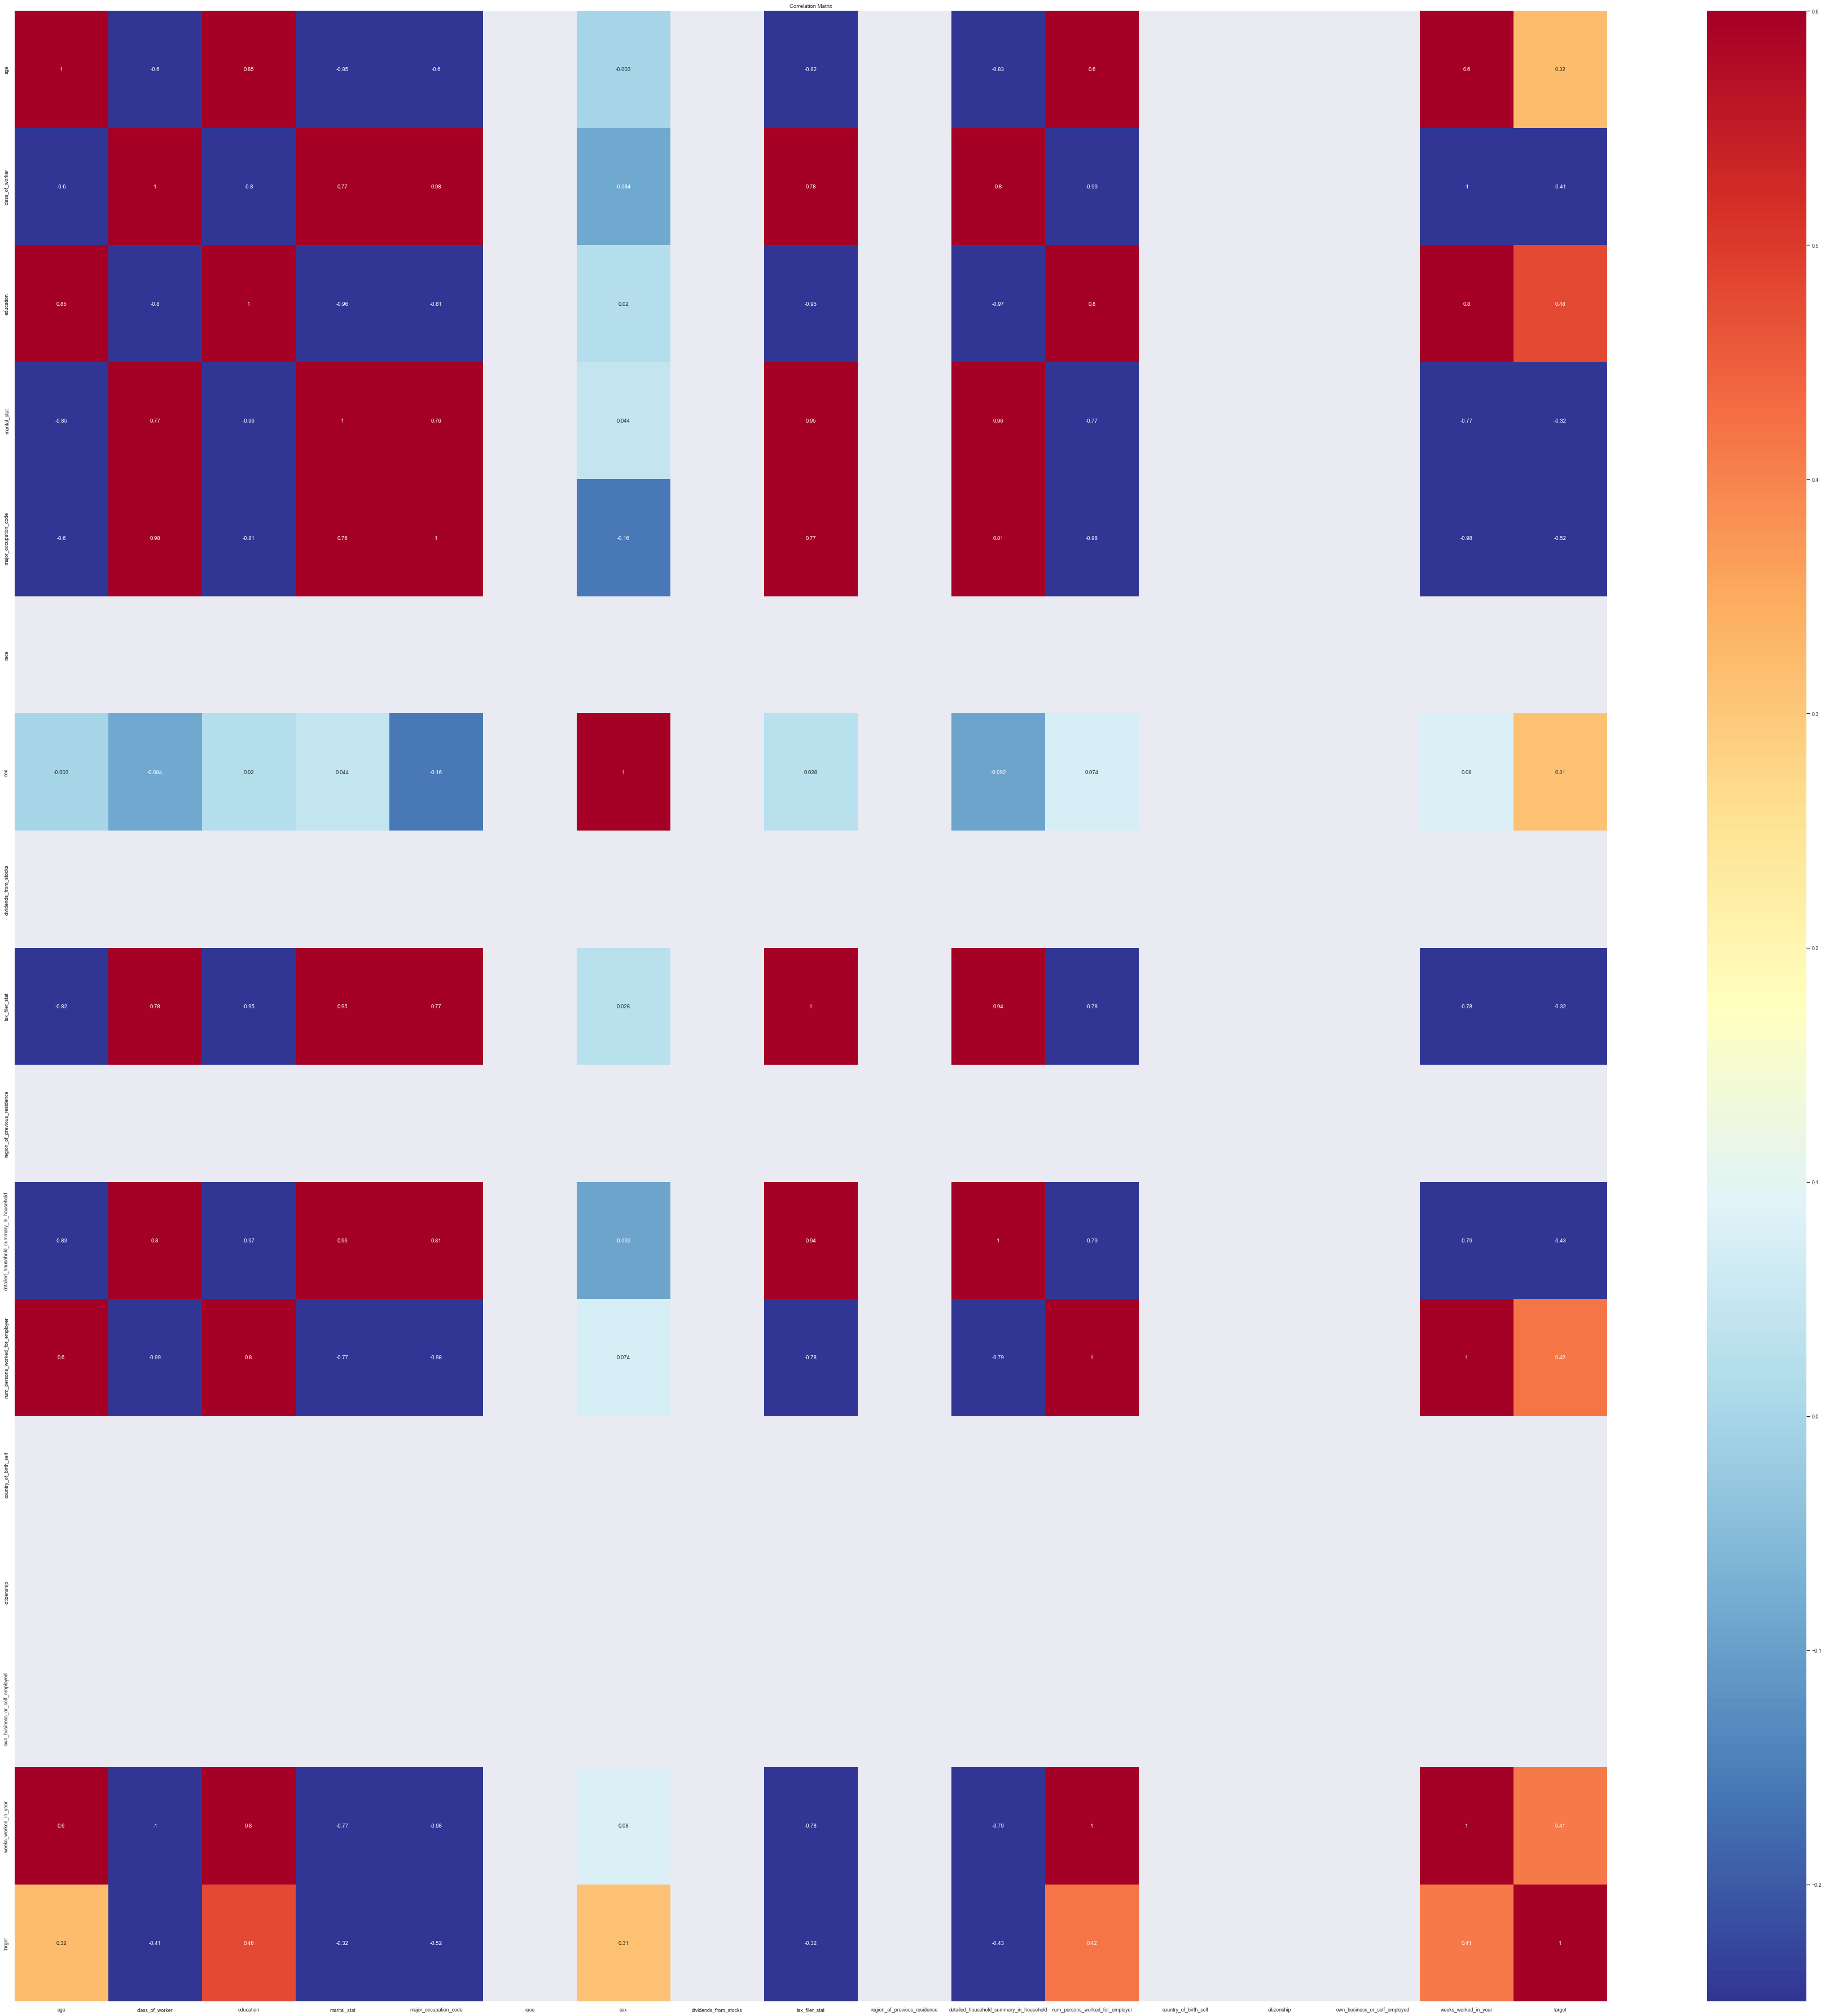

In [229]:
sns.set(rc={'figure.figsize': (50, 50)})
sns.set(font_scale=0.8)
sns.heatmap(matrix, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Matrix');

In [230]:
del_features = list()
count_features = list(matrix.columns)
count_features.remove('target')

for i in range(len(count_features)):
    for j in range(i+1, len(count_features)):
        feature_1 = matrix.columns[i]
        feature_2 = matrix.columns[j]
        if abs(matrix[feature_1].at[feature_2]) > 0.8:
            if abs(matrix['target'].at[feature_2]) > abs(matrix['target'].at[feature_1]):
                del_features.append(feature_1)
            else:
                del_features.append(feature_2)
                
del_features = np.unique(del_features)
print("The number of features to remove:", len(del_features))
print("The number of features remaining:", len(matrix) - len(del_features) - 1)

The number of features to remove: 8
The number of features remaining: 8


In [231]:
del_features

array(['age', 'class_of_worker',
       'detailed_household_summary_in_household', 'education',
       'marital_stat', 'num_persons_worked_for_employer',
       'tax_filer_stat', 'weeks_worked_in_year'], dtype='<U39')

In [232]:
for del_feature in del_features:
    count_features.remove(del_feature)
print("The number of features remaining:", len(count_features))

The number of features remaining: 8


In [233]:
sorted(count_features)

['citizenship',
 'country_of_birth_self',
 'dividends_from_stocks',
 'major_occupation_code',
 'own_business_or_self_employed',
 'race',
 'region_of_previous_residence',
 'sex']

In [234]:
sorted(real_model_features)

['age',
 'citizenship',
 'country_of_birth_self',
 'detailed_household_summary_in_household',
 'dividends_from_stocks',
 'education',
 'marital_stat',
 'own_business_or_self_employed',
 'race',
 'region_of_previous_residence',
 'sex',
 'tax_filer_stat',
 'weeks_worked_in_year']

### Logistic regression 

In [235]:
X_tr1 = X_tr[count_features]
X_te1 = X_te[count_features]
X_te_real1 = X_te_real[count_features]

X_tr2 = X_tr[real_model_features]
X_te2 = X_te[real_model_features]
X_te_real2 = X_te_real[real_model_features]


In [236]:
X_te2.isna().sum()

age                                        0
education                                  0
marital_stat                               0
race                                       0
sex                                        0
dividends_from_stocks                      0
tax_filer_stat                             1
region_of_previous_residence               0
detailed_household_summary_in_household    0
country_of_birth_self                      0
citizenship                                0
own_business_or_self_employed              0
weeks_worked_in_year                       0
dtype: int64

In [237]:
sorted(synt_data['country_of_birth_self'].unique()) 

['United-States']

In [238]:
sorted(real_data['country_of_birth_self'].unique()) 

['?',
 'Cambodia',
 'Canada',
 'China',
 'Columbia',
 'Cuba',
 'Dominican-Republic',
 'Ecuador',
 'El-Salvador',
 'England',
 'France',
 'Germany',
 'Greece',
 'Guatemala',
 'Haiti',
 'Holand-Netherlands',
 'Honduras',
 'Hong Kong',
 'Hungary',
 'India',
 'Iran',
 'Ireland',
 'Italy',
 'Jamaica',
 'Japan',
 'Laos',
 'Mexico',
 'Nicaragua',
 'Outlying-U S (Guam USVI etc)',
 'Panama',
 'Peru',
 'Philippines',
 'Poland',
 'Portugal',
 'Puerto-Rico',
 'Scotland',
 'South Korea',
 'Taiwan',
 'Thailand',
 'Trinadad&Tobago',
 'United-States',
 'Vietnam',
 'Yugoslavia']

In [239]:
X_te1.fillna(0, inplace=True)
X_te_real1.fillna(0, inplace=True)
X_te2.fillna(0, inplace=True)
X_te_real2.fillna(0, inplace=True)
X_tr1.fillna(0, inplace=True)
X_tr2.fillna(0, inplace=True)

C:\Users\AlexeyNeyman\AppData\Local\Temp\ipykernel_13952\3402496439.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_te1.fillna(0, inplace=True)
C:\Users\AlexeyNeyman\AppData\Local\Temp\ipykernel_13952\3402496439.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_te_real1.fillna(0, inplace=True)
C:\Users\AlexeyNeyman\AppData\Local\Temp\ipykernel_13952\3402496439.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_te2.fillna(0

In [240]:
%%time
smt = ADASYN(random_state=random_state)
X_smt, y_smt = smt.fit_resample(X_tr1, y_tr)

CPU times: total: 250 ms
Wall time: 270 ms


In [241]:
%%time
grid_pipe_log = GridSearchCV(log_pipe, log_parameters, cv=5, scoring='balanced_accuracy', verbose=3)
grid_pipe_log.fit(X_smt, y_smt)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.878 total time=   0.2s
[CV 2/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.967 total time=   0.1s
[CV 3/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.962 total time=   0.1s
[CV 4/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.926 total time=   0.1s
[CV 5/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.960 total time=   0.2s
[CV 1/5] END ......LR__C=0.001, LR__solver=saga;, score=0.860 total time=   0.2s
[CV 2/5] END ......LR__C=0.001, LR__solver=saga;, score=0.967 total time=   0.2s
[CV 3/5] END ......LR__C=0.001, LR__solver=saga;, score=0.962 total time=   0.2s
[CV 4/5] END ......LR__C=0.001, LR__solver=saga;, score=0.907 total time=   0.1s
[CV 5/5] END ......LR__C=0.001, LR__solver=saga;, score=0.960 total time=   0.1s
[CV 1/5] END .......LR__C=0.01, LR__solver=saga;, score=0.836 total time=   0.2s
[CV 2/5] END .......LR__C=0.01, LR__solver=saga;,

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Scaler', StandardScaler()),
                                       ('LR', LogisticRegression())]),
             param_grid={'LR__C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
                         'LR__solver': ['saga']},
             scoring='balanced_accuracy', verbose=3)

In [242]:
print(grid_pipe_log.best_score_)
print(grid_pipe_log.best_estimator_.steps[1][1])

0.9384441540341311
LogisticRegression(C=0.0001, solver='saga')


In [243]:
y_pred_test1 = grid_pipe_log.best_estimator_.predict(X_te1)
y_pred_test_real1 = grid_pipe_log.best_estimator_.predict(X_te_real1)

In [244]:
res_test41 = pd.DataFrame([['LogRegression Phi1.5 synthetic features','Synth test',
                        balanced_accuracy_score(y_te, y_pred_test1),
                        recall_score(y_te, y_pred_test1),
                        precision_score(y_te, y_pred_test1),
                        roc_auc_score(y_te, y_pred_test1)]],
                        columns=['Model','Dataset','Balanced_accuracy','Recall', 'Precision', 'ROC_AUC'])
res_test_real41 = pd.DataFrame([['LogRegression Phi1.5 synthetic features','Real test',
                        balanced_accuracy_score(y_te_real, y_pred_test_real1),
                        recall_score(y_te_real, y_pred_test_real1),
                        precision_score(y_te_real, y_pred_test_real1),
                        roc_auc_score(y_te_real, y_pred_test_real1)]],
                        columns=['Model','Dataset','Balanced_accuracy','Recall', 'Precision', 'ROC_AUC'])

model_results = pd.concat([model_results, res_test41, res_test_real41],axis=0)

In [245]:
res_test41

Model     Dataset  Balanced_accuracy  \
0  LogRegression Phi1.5 synthetic features  Synth test           0.960883   

     Recall  Precision   ROC_AUC  
0  0.997347   0.469413  0.960883

In [246]:
res_test_real41

Model    Dataset  Balanced_accuracy  \
0  LogRegression Phi1.5 synthetic features  Real test            0.74246   

     Recall  Precision  ROC_AUC  
0  0.703704   0.177807  0.74246

In [247]:
%%time
smt = ADASYN(random_state=random_state)
X_smt, y_smt = smt.fit_resample(X_tr2, y_tr)

CPU times: total: 344 ms
Wall time: 373 ms


In [248]:
%%time
grid_pipe_log = GridSearchCV(log_pipe, log_parameters, cv=5, scoring='balanced_accuracy', verbose=3)
grid_pipe_log.fit(X_smt, y_smt)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.946 total time=   0.2s
[CV 2/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.952 total time=   0.3s
[CV 3/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.946 total time=   0.3s
[CV 4/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.951 total time=   0.2s
[CV 5/5] END .....LR__C=0.0001, LR__solver=saga;, score=0.947 total time=   0.2s
[CV 1/5] END ......LR__C=0.001, LR__solver=saga;, score=0.955 total time=   0.4s
[CV 2/5] END ......LR__C=0.001, LR__solver=saga;, score=0.957 total time=   0.5s
[CV 3/5] END ......LR__C=0.001, LR__solver=saga;, score=0.954 total time=   0.3s
[CV 4/5] END ......LR__C=0.001, LR__solver=saga;, score=0.936 total time=   0.3s
[CV 5/5] END ......LR__C=0.001, LR__solver=saga;, score=0.953 total time=   0.3s
[CV 1/5] END .......LR__C=0.01, LR__solver=saga;, score=0.948 total time=   0.3s
[CV 2/5] END .......LR__C=0.01, LR__solver=saga;,

C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END ..........LR__C=1, LR__solver=saga;, score=0.942 total time=   3.0s
[CV 2/5] END ..........LR__C=1, LR__solver=saga;, score=0.968 total time=   1.6s
[CV 3/5] END ..........LR__C=1, LR__solver=saga;, score=0.963 total time=   1.0s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END ..........LR__C=1, LR__solver=saga;, score=0.935 total time=   2.4s
[CV 5/5] END ..........LR__C=1, LR__solver=saga;, score=0.962 total time=   1.6s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END .........LR__C=10, LR__solver=saga;, score=0.938 total time=   2.5s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END .........LR__C=10, LR__solver=saga;, score=0.969 total time=   2.5s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END .........LR__C=10, LR__solver=saga;, score=0.963 total time=   2.3s


C:\Conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END .........LR__C=10, LR__solver=saga;, score=0.934 total time=   2.6s
[CV 5/5] END .........LR__C=10, LR__solver=saga;, score=0.963 total time=   2.7s
CPU times: total: 31.7 s
Wall time: 33 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Scaler', StandardScaler()),
                                       ('LR', LogisticRegression())]),
             param_grid={'LR__C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
                         'LR__solver': ['saga']},
             scoring='balanced_accuracy', verbose=3)

In [249]:
print(grid_pipe_log.best_score_)
print(grid_pipe_log.best_estimator_.steps[1][1])

0.954097546107524
LogisticRegression(C=0.1, solver='saga')


In [250]:
y_pred_test2 = grid_pipe_log.best_estimator_.predict(X_te2)
y_pred_test_real2 = grid_pipe_log.best_estimator_.predict(X_te_real2)

In [251]:
res_test42 = pd.DataFrame([['LogRegression Phi1.5 real features','Synth test',
                        balanced_accuracy_score(y_te, y_pred_test2),
                        recall_score(y_te, y_pred_test2),
                        precision_score(y_te, y_pred_test2),
                        roc_auc_score(y_te, y_pred_test2)]],
                        columns=['Model','Dataset','Balanced_accuracy','Recall', 'Precision', 'ROC_AUC'])
res_test_real42 = pd.DataFrame([['LogRegression Phi1.5 real features','Real test',
                        balanced_accuracy_score(y_te_real, y_pred_test_real2),
                        recall_score(y_te_real, y_pred_test_real2),
                        precision_score(y_te_real, y_pred_test_real2),
                        roc_auc_score(y_te_real, y_pred_test_real2)]],
                        columns=['Model','Dataset','Balanced_accuracy','Recall', 'Precision', 'ROC_AUC'])
model_results = pd.concat([model_results, res_test42, res_test_real42],axis=0)

In [252]:
res_test42

Model     Dataset  Balanced_accuracy  \
0  LogRegression Phi1.5 real features  Synth test           0.961149   

     Recall  Precision   ROC_AUC  
0  0.997347   0.471178  0.961149

In [253]:
res_test_real42

Model    Dataset  Balanced_accuracy    Recall  \
0  LogRegression Phi1.5 real features  Real test            0.81048  0.791005   

   Precision  ROC_AUC  
0   0.238247  0.81048

## Modelling result

In [254]:
model_results

Model     Dataset  Balanced_accuracy  \
0                      LogRegression Real data   Real test           0.845280   
0  LogRegression DistillGPT synthetic features  Synth test           0.690583   
0  LogRegression DistillGPT synthetic features   Real test           0.748513   
0       LogRegression DistillGPT real features  Synth test           0.716307   
0       LogRegression DistillGPT real features   Real test           0.745621   
0      LogRegression GPT2xl synthetic features  Synth test           0.965149   
0      LogRegression GPT2xl synthetic features   Real test           0.796213   
0           LogRegression GPT2xl real features  Synth test           0.985068   
0           LogRegression GPT2xl real features   Real test           0.816627   
0    LogRegression Cerebras synthetic features  Synth test           0.968078   
0    LogRegression Cerebras synthetic features   Real test           0.757644   
0         LogRegression Cerebras real features  Synth test           0.978037   
0         LogRegression Cerebras real features   Real test           0.808613   
0      LogRegression Phi1.5 synthetic features  Synth test           0.960883   
0      LogRegression Phi1.5 synthetic features   Real test           0.742460   
0           LogRegression Phi1.5 real features  Synth test           0.961149   
0           LogRegression Phi1.5 real features   Real test           0.810480   

     Recall  Precision   ROC_AUC  
0  0.888889   0.231564  0.845280  
0  0.605820   0.153485  0.690583  
0  0.952381   0.123288  0.748513  
0  0.788360   0.129678  0.716307  
0  0.984127   0.118358  0.745621  
0  1.000000   0.489583  0.965149  
0  0.841270   0.185207  0.796213  
0  0.997340   0.710227  0.985068  
0  0.788360   0.254701  0.816627  
0  1.000000   0.512228  0.968078  
0  0.896825   0.136473  0.757644  
0  1.000000   0.604167  0.978037  
0  0.769841   0.253264  0.808613  
0  0.997347   0.469413  0.960883  
0  0.703704   0.177807  0.742460  
0  0.997347   0.471178  0.961149  
0  0.791005   0.238247  0.810480

In [255]:
model_results.to_csv('model_results_shortincome_temp0.1.csv')

# Privacy metrics

In [256]:
from pandas import DataFrame, Series
from typing import List, Tuple, Dict, Callable
import scipy.stats as ss
from sklearn.neighbors import NearestNeighbors
from scipy.stats import mannwhitneyu, chisquare, ks_2samp



In [257]:
privacy_results = pd.DataFrame(columns=['Model','95% bound','DCRn ratio','NNDR ratio','DCRn median', 'NNDR median'])

In [258]:
# bound value to determine quantiles
dcr_quantile = 0.95
# how many bins should be created for privacy histograms
privacy_number_of_bins = 30
#to avoid devision by zero
smoothing_factor = 1e-8
#test sample ratio
ratio = 0.3
control_size = 9000

random_state = 12*13*99*17-1

In [259]:
tgt_train = real_dataset.copy()

In [260]:
tgt_test = control_dataset.copy()

In [261]:
def create_hamming (df, columns) :
    hamming = dict()
    for i,col in enumerate(columns) :
        hamming[col] = create_hamming_dic(df, col)
    return hamming

def create_hamming_dic (df, column):
    hamming_dic = dict()
    keys = sorted(df[column].unique())
    for i, key in enumerate(keys):
        code = i+1
        hamming_dic[key] = code
    return hamming_dic    

def map_column_humming(df, column, hamming) :
    df[column] = df[column].map(hamming[column])  
    return df[column]

def map_humming (df, hamming) :
    keys = hamming.keys()
    for col in df.columns :
        if col in keys:
            df[col] = map_column_humming(df, col, hamming)
    df.fillna(0) 
    return df
def normal_coeff (df, columns) :
    coeff = list()
    for col in columns :
        coeff.append(df[col].max())
    return coeff

In [262]:
for_hmm_columns = categs.copy()
for_hmm_columns.append('target')
for_norm_columns = numeric.copy()
hmm_train = tgt_train.copy()
hmm_train = hmm_train[for_norm_columns+for_hmm_columns]
hmm_test = tgt_test.copy()
hmm_test = hmm_test[for_norm_columns+for_hmm_columns]

In [263]:
hmm = create_hamming(hmm_train, for_hmm_columns)

In [264]:
hmm_train = map_humming(hmm_train,hmm)

In [265]:
norm_weights = normal_coeff(hmm_train, for_norm_columns)  

In [266]:
norm_weights

[90, 99999, 6, 52]

In [267]:
def get_mixed_distance (x,y, norm_weights) :
    distance = 0
    for i in range(len(norm_weights)) :  #first numeric fields  
        distance += abs(x[i]-y[i])/norm_weights[i]
    for i in range(len(norm_weights), len(x)) :  # next categorical fields
        if x[i] != y[i] :
            distance += 1
    return distance        

In [268]:
def get_2_neighbors_for_vector (vector, base, norm_weights) :
    k1 = -1 
    k2 = -1
    d1 = -1
    d2 = -1
    for i, basis in enumerate(base) :
        curr_distance = get_mixed_distance (vector, basis, norm_weights)
        if k1 < 0 :
            k1 = i
            d1 = curr_distance
        elif k2 < 0 :
            if curr_distance < d1 :
                k2 = k1*1
                d2 = d1*1
                k1 = i
                d1 = curr_distance
            else :
                k2 = i
                d2 = curr_distance
        else :
            if curr_distance < d1 :
                k2 = k1*1
                d2 = d1*1
                k1 = i
                d1 = curr_distance
            elif curr_distance < d2 :
                k2 = i
                d2 = curr_distance
    return np.array([[k1,k2],[d1,d2]])

In [269]:
def get_2_neighbors_mixed (vectors, base, norm_weights, trace = 0) :
    neighbors = list()
    if trace > 0 :
        print(len(vectors),':', end='')
    for i, vector in enumerate(vectors):
        neighbors.append(get_2_neighbors_for_vector (vector, base, norm_weights)) 
        if trace > 0 and i%trace == 0 :
            print(i, '-' , end='')
    print (len(vectors))
    return np.array(neighbors)

## Real data privacy

In [270]:
hmm_test = map_humming(hmm_test,hmm)

In [271]:
nbs = get_2_neighbors_mixed(vectors=hmm_test.to_numpy(),base=hmm_train.to_numpy(),norm_weights=norm_weights,trace=250)

9000 :0 -250 -500 -750 -1000 -1250 -1500 -1750 -2000 -2250 -2500 -2750 -3000 -3250 -3500 -3750 -4000 -4250 -4500 -4750 -5000 -5250 -5500 -5750 -6000 -6250 -6500 -6750 -7000 -7250 -7500 -7750 -8000 -8250 -8500 -8750 -9000


In [272]:
print('Stats : mean, std, max, min, amount')
dcr_real = np.array([d[0] for d in [x[1] for x in [i for i in nbs]]])
dcr2_real = np.array([d[1] for d in [x[1] for x in [i for i in nbs]]])
nndr_real = dcr_real / np.maximum(dcr2_real, smoothing_factor) 
print('NNDR stats', nndr_real.mean(), nndr_real.std(), nndr_real.max(), nndr_real.min(), len (nndr_real))
baseline_dcr = dcr_real
bound = np.quantile(baseline_dcr[~np.isnan(baseline_dcr)], dcr_quantile)
dcr_real_norm = np.where(dcr_real <= bound, dcr_real / bound, 1)
print('nDCR stats', dcr_real_norm.mean(), dcr_real_norm.std(), dcr_real_norm.max(), dcr_real_norm.min(), len(dcr_real_norm))
print('DCR Bound',dcr_quantile,'% =',bound)

Stats : mean, std, max, min, amount
NNDR stats 0.48010248609410033 0.4123699359575158 1.0 0.0 9000
nDCR stats 0.22862066371959058 0.31746840509738666 1.0 0.0 9000
DCR Bound 0.95 % = 2.1444444444444444


In [273]:
real_privacy = pd.DataFrame(zip(dcr_real,dcr_real_norm,nndr_real),columns=['Distance to Closest Record (DCR) for RealData','Normal Distance to Closest Record (nDCR) for RealData','Nearest Neighbor Distance Ratio (NNDR) for RealData'])
real_privacy.hist(bins=privacy_number_of_bins, grid=True, figsize=(20, 5), layout=(1, 3))

array([[<AxesSubplot:title={'center':'Distance to Closest Record (DCR) for RealData'}>,
        <AxesSubplot:title={'center':'Normal Distance to Closest Record (nDCR) for RealData'}>,
        <AxesSubplot:title={'center':'Nearest Neighbor Distance Ratio (NNDR) for RealData'}>]],
      dtype=object)

In [274]:
def calc_dcr_ratio(real_dcr:np.array, synt_dcr:np.array):
    med_real = np.median(real_dcr) 
    ordered_synt = np.sort(synt_dcr)
    middle = len(ordered_synt)//2
    if ordered_synt[middle] <= med_real :
        for i in range(middle) :
            if (i == middle) or (ordered_synt[middle+i+1] >= med_real) :
                break
        first_median_synt = middle + i
    else:
        for i in range(middle) :
            if (i == middle) or (ordered_synt[middle-i-1] < med_real) :
                break
        first_median_synt = middle - i
    return (len(ordered_synt)-first_median_synt)/max(first_median_synt,smoothing_factor)

In [275]:
def calc_nndr_ratio(real_nndr:np.array, synt_nndr:np.array):
    med_real = np.median(real_nndr) 
    ordered_synt = np.sort(synt_nndr)
    middle = len(ordered_synt)//2
    if ordered_synt[middle] <= med_real :
        for i in range(middle) :
            if (i == middle) or (ordered_synt[middle+i+1] >= med_real) :
                break
        first_median_synt = middle + i
    else:
        for i in range(middle) :
            if (i == middle) or (ordered_synt[middle-i-1] < med_real) :
                break
        first_median_synt = middle - i
    return (len(ordered_synt)-first_median_synt)/max(first_median_synt,smoothing_factor)

In [276]:
calc_dcr_ratio(dcr_real_norm,dcr_real_norm.copy())

1.0

In [277]:
calc_nndr_ratio(nndr_real,nndr_real.copy())

1.0

In [278]:
res_privacy = pd.DataFrame([['Real dataset', bound,
                        calc_dcr_ratio(dcr_real_norm,dcr_real_norm.copy()),
                        calc_nndr_ratio(nndr_real,nndr_real.copy()),
                        np.median(dcr_real_norm),
                        np.median(nndr_real),
                        dcr_real_norm.min()    ]],
                        columns=['Model','95% bound','DCRn ratio','NNDR ratio','DCRn median', 'NNDR median','Minimal distance'])

privacy_results = pd.concat([privacy_results, res_privacy],axis=0)

C:\Users\AlexeyNeyman\AppData\Local\Temp\ipykernel_13952\106412619.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  privacy_results = pd.concat([privacy_results, res_privacy],axis=0)


## DistillGPT2 privacy

In [279]:
syn_test1 = synt_data_distilgpt2.sample(n=control_size) 

In [280]:
hmm_test1 = syn_test1.copy()
hmm_test1 = hmm_test1[for_norm_columns+for_hmm_columns]

In [281]:
hmm_test1 = map_humming(hmm_test1,hmm)

In [282]:
nbs1 = get_2_neighbors_mixed(vectors=hmm_test1.to_numpy()[:10000],base=hmm_train.to_numpy()[:10000],norm_weights=norm_weights,trace=250)

9000 :0 -250 -500 -750 -1000 -1250 -1500 -1750 -2000 -2250 -2500 -2750 -3000 -3250 -3500 -3750 -4000 -4250 -4500 -4750 -5000 -5250 -5500 -5750 -6000 -6250 -6500 -6750 -7000 -7250 -7500 -7750 -8000 -8250 -8500 -8750 -9000


In [283]:
print('Stats : mean, std, max, min, amount')
dcr_synt1 = np.array([d[0] for d in [x[1] for x in [i for i in nbs1]]])
dcr2_synt1 = np.array([d[1] for d in [x[1] for x in [i for i in nbs1]]])
nndr_synt1 = dcr_synt1 / np.maximum(dcr2_synt1, smoothing_factor) 
print('NNDR stats', nndr_synt1.mean(), nndr_synt1.std(), nndr_synt1.max(), nndr_synt1.min(), len (nndr_synt1))
dcr_synt_norm1 = np.where(dcr_synt1 <= bound, dcr_synt1 / bound, 1)
print('nDCR stats', dcr_synt_norm1.mean(), dcr_synt_norm1.std(), dcr_synt_norm1.max(), dcr_synt_norm1.min(), len(dcr_synt_norm1))

baseline_dcr = dcr_synt1
bound1 = np.quantile(baseline_dcr[~np.isnan(baseline_dcr)], dcr_quantile)
print('DCR Bound',dcr_quantile,'% =',bound1)

Stats : mean, std, max, min, amount
NNDR stats 0.2239394335172322 0.3597790440997712 1.0 0.0 9000
nDCR stats 0.024663578116450754 0.09067044540335933 0.9493523432643654 0.0 9000
DCR Bound 0.95 % = 0.2222522225222252


array([[<AxesSubplot:title={'center':'Distance to Closest Record (DCR) for DistillGPT synthetics '}>,
        <AxesSubplot:title={'center':'Normal Distance to Closest Record (nDCR) for DistillGPT synthetics'}>,
        <AxesSubplot:title={'center':'Nearest Neighbor Distance Ratio (NNDR) for DistillGPT synthetics'}>]],
      dtype=object)

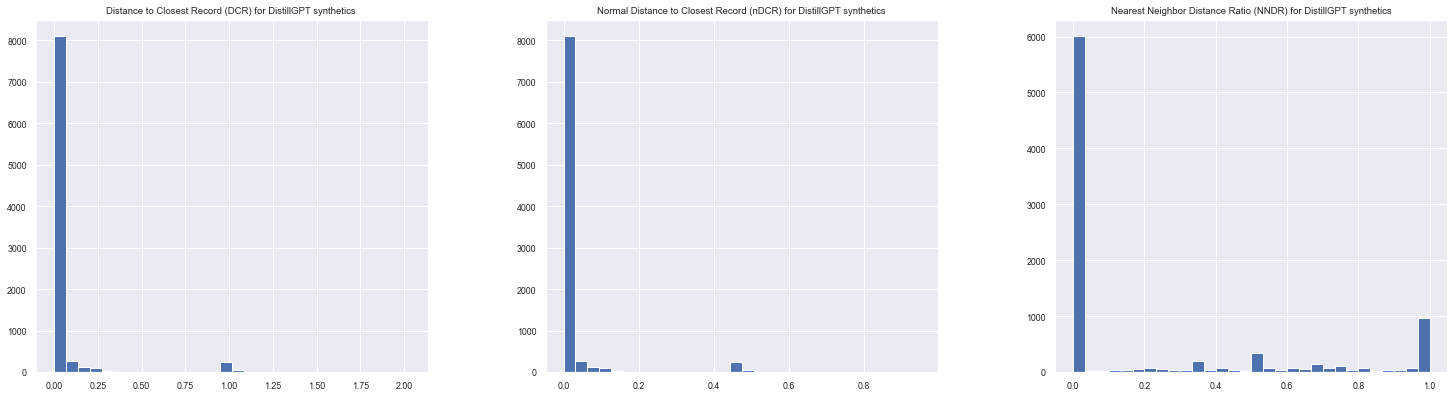

In [284]:
synt_privacy = pd.DataFrame(zip(dcr_synt1,dcr_synt_norm1,nndr_synt1),columns=['Distance to Closest Record (DCR) for DistillGPT synthetics ','Normal Distance to Closest Record (nDCR) for DistillGPT synthetics','Nearest Neighbor Distance Ratio (NNDR) for DistillGPT synthetics'])
synt_privacy.hist(bins=privacy_number_of_bins, grid=True, figsize=(20, 5), layout=(1, 3))

In [285]:
fig, ax = plt.subplots(figsize=(20, 20))
plt.xlabel("nDCR")
plt.ylabel("NNDR")
#ax.scatter(cols_compare['Longitude']['gpt2xl'], cols_compare['Latitude']['gpt2xl'],c='lightgreen', label='gpt2xl', alpha=0.1, edgecolors='lightgreen')
#ax.scatter(cols_compare['Longitude']['cerebras'], cols_compare['Latitude']['cerebras'],c='cyan', label='cerebras', alpha=0.5, edgecolors='cyan')
ax.scatter(dcr_synt_norm1, nndr_synt1, c='lightblue', label='DistilledGPT', alpha=0.5, edgecolors='lightblue')
ax.scatter(dcr_real_norm, nndr_real, c='pink', label='Real', alpha=0.5, edgecolors='black')
plt.show()

In [286]:
calc_dcr_ratio(dcr_real_norm,dcr_synt_norm1)

0.12163509471585245

In [287]:
calc_nndr_ratio(nndr_real,nndr_synt1)

0.2635125649305068

In [288]:
stat, p_value = mannwhitneyu(dcr_real_norm, dcr_synt_norm1)
print(f" Mann-Whitney U rank test for nDCR: statistic={stat:.8f}, p-value={p_value:.8f}")
stat, p_value = mannwhitneyu(nndr_real, nndr_synt1)
print(f" Mann-Whitney U rank test for NNDR: statistic={stat:.6f}, p-value={p_value:.6f}")

stat, p_value = ks_2samp(dcr_real_norm, dcr_synt_norm1)
print(f" Kolmogorov-Smirnov Test for nDCR: statistic={stat:.8f}, p-value={p_value:.8f}")
stat, p_value = ks_2samp(nndr_real, nndr_synt1)
print(f" Kolmogorov-Smirnov Test for NNDR: statistic={stat:.6f}, p-value={p_value:.6f}")

 Mann-Whitney U rank test for nDCR: statistic=59336461.50000000, p-value=0.00000000
 Mann-Whitney U rank test for NNDR: statistic=54458075.500000, p-value=0.000000
 Kolmogorov-Smirnov Test for nDCR: statistic=0.39700000, p-value=0.00000000
 Kolmogorov-Smirnov Test for NNDR: statistic=0.337333, p-value=0.000000


In [289]:
res_privacy = pd.DataFrame([['DistillGPT2', bound1,
                        calc_dcr_ratio(dcr_real_norm,dcr_synt_norm1),
                        calc_nndr_ratio(nndr_real,nndr_synt1),
                        np.median(dcr_synt_norm1),
                        np.median(nndr_synt1),
                        dcr_synt_norm1.min()    ]],
                        columns=['Model','95% bound','DCRn ratio','NNDR ratio','DCRn median', 'NNDR median','Minimal distance'])

privacy_results = pd.concat([privacy_results, res_privacy],axis=0)

## GPT2XL privacy

In [290]:
syn_test1 = synt_data_gpt2xl.sample(n=control_size) 

In [291]:
hmm_test1 = syn_test1.copy()
hmm_test1 = hmm_test1[for_norm_columns+for_hmm_columns]

In [292]:
hmm_test1 = map_humming(hmm_test1,hmm)

In [293]:
nbs2 = get_2_neighbors_mixed(vectors=hmm_test1.to_numpy(),base=hmm_train.to_numpy(),norm_weights=norm_weights,trace=250)

9000 :0 -250 -500 -750 -1000 -1250 -1500 -1750 -2000 -2250 -2500 -2750 -3000 -3250 -3500 -3750 -4000 -4250 -4500 -4750 -5000 -5250 -5500 -5750 -6000 -6250 -6500 -6750 -7000 -7250 -7500 -7750 -8000 -8250 -8500 -8750 -9000


In [294]:
print('Stats : mean, std, max, min, amount')
dcr_synt2 = np.array([d[0] for d in [x[1] for x in [i for i in nbs2]]])
dcr2_synt2 = np.array([d[1] for d in [x[1] for x in [i for i in nbs2]]])
nndr_synt2 = dcr_synt2 / np.maximum(dcr2_synt2, smoothing_factor) 
print('NNDR stats', nndr_synt2.mean(), nndr_synt2.std(), nndr_synt2.max(), nndr_synt2.min(), len (nndr_synt2))
dcr_synt_norm2 = np.where(dcr_synt2 <= bound, dcr_synt2 / bound, 1)
print('nDCR stats', dcr_synt_norm2.mean(), dcr_synt_norm2.std(), dcr_synt_norm2.max(), dcr_synt_norm2.min(), len (dcr_synt_norm2))

baseline_dcr = dcr_synt2
bound2 = np.quantile(baseline_dcr[~np.isnan(baseline_dcr)], dcr_quantile)
print('DCR Bound',dcr_quantile,'% =',bound2)

Stats : mean, std, max, min, amount
NNDR stats 0.06577647073181521 0.23680154203358392 1.0 0.0 9000
nDCR stats 0.000472650166916177 0.002117057291140582 0.07772020725388601 0.0 9000
DCR Bound 0.95 % = 0.011111111111111112


array([[<AxesSubplot:title={'center':'Distance to Closest Record (DCR) for GPTxl synthetics '}>,
        <AxesSubplot:title={'center':'Normal Distance to Closest Record (nDCR) for GPTxl synthetics'}>,
        <AxesSubplot:title={'center':'Nearest Neighbor Distance Ratio (NNDR) for GPT2xl synthetics'}>]],
      dtype=object)

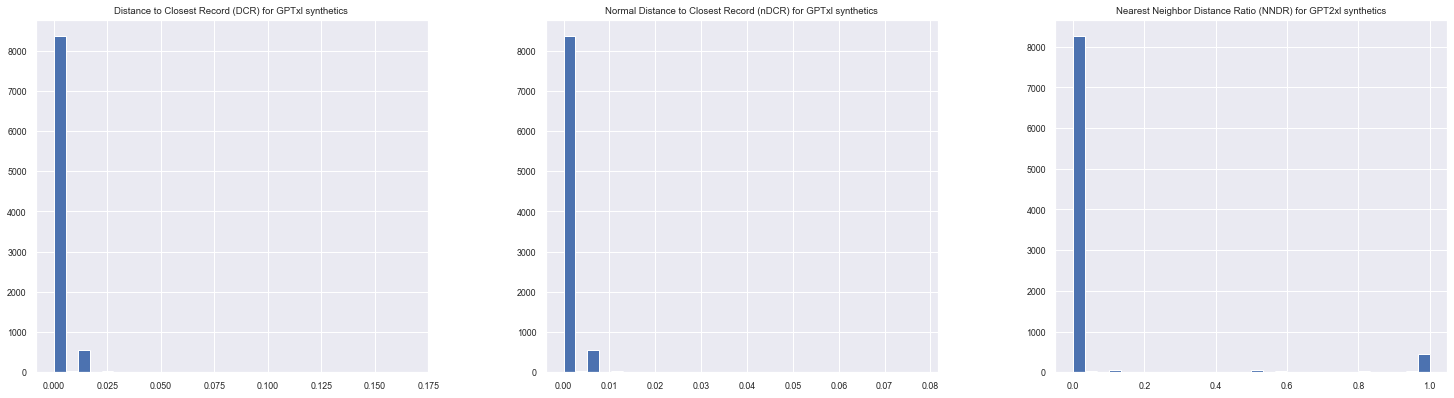

In [295]:
synt_privacy = pd.DataFrame(zip(dcr_synt2,dcr_synt_norm2,nndr_synt2),columns=['Distance to Closest Record (DCR) for GPTxl synthetics ','Normal Distance to Closest Record (nDCR) for GPTxl synthetics','Nearest Neighbor Distance Ratio (NNDR) for GPT2xl synthetics'])
synt_privacy.hist(bins=privacy_number_of_bins, grid=True, figsize=(20, 5), layout=(1, 3))

In [296]:
fig, ax = plt.subplots(figsize=(20, 20))
plt.xlabel("nDCR")
plt.ylabel("NNDR")
ax.scatter(dcr_synt_norm2, nndr_synt2, c='lightgreen', label='GPT2xl', alpha=0.5, edgecolors='lightgreen')
ax.scatter(dcr_real_norm, nndr_real, c='pink', label='Real', alpha=0.5, edgecolors='black')
plt.show()

In [297]:
calc_dcr_ratio(dcr_real_norm,dcr_synt_norm2)

0.0008896797153024911

In [298]:
calc_nndr_ratio(nndr_real,nndr_synt2)

0.06812247804414906

In [299]:
stat, p_value = mannwhitneyu(dcr_real_norm, dcr_synt_norm2)
print(f" Mann-Whitney U rank test for nDCR: statistic={stat:.8f}, p-value={p_value:.8f}")
stat, p_value = mannwhitneyu(nndr_real, nndr_synt2)
print(f" Mann-Whitney U rank test for NNDR: statistic={stat:.6f}, p-value={p_value:.6f}")
print ('')


print ('')
stat, p_value = ks_2samp(dcr_real_norm, dcr_synt_norm2)
print(f" Kolmogorov-Smirnov Test for nDCR: statistic={stat:.8f}, p-value={p_value:.8f}")
stat, p_value = ks_2samp(nndr_real, nndr_synt2)
print(f" Kolmogorov-Smirnov Test for NNDR: statistic={stat:.6f}, p-value={p_value:.6f}")

 Mann-Whitney U rank test for nDCR: statistic=66475171.00000000, p-value=0.00000000
 Mann-Whitney U rank test for NNDR: statistic=63741085.000000, p-value=0.000000


 Kolmogorov-Smirnov Test for nDCR: statistic=0.59300000, p-value=0.00000000
 Kolmogorov-Smirnov Test for NNDR: statistic=0.592556, p-value=0.000000


In [300]:
res_privacy = pd.DataFrame([['GPT2xl', bound2,
                        calc_dcr_ratio(dcr_real_norm,dcr_synt_norm2),
                        calc_nndr_ratio(nndr_real,nndr_synt2),
                        np.median(dcr_synt_norm2),
                        np.median(nndr_synt2),
                        dcr_synt_norm2.min()    ]],
                        columns=['Model','95% bound','DCRn ratio','NNDR ratio','DCRn median', 'NNDR median','Minimal distance'])

privacy_results = pd.concat([privacy_results, res_privacy],axis=0)

## Cerebras privacy

In [301]:
syn_test1 = synt_data_cerebras.sample(n=control_size) 

In [302]:
hmm_test1 = syn_test1.copy()
hmm_test1 = hmm_test1[for_norm_columns+for_hmm_columns]

In [303]:
hmm_test1 = map_humming(hmm_test1,hmm)

In [304]:
nbs3 = get_2_neighbors_mixed(vectors=hmm_test1.to_numpy(),base=hmm_train.to_numpy(),norm_weights=norm_weights,trace=250)

9000 :0 -250 -500 -750 -1000 -1250 -1500 -1750 -2000 -2250 -2500 -2750 -3000 -3250 -3500 -3750 -4000 -4250 -4500 -4750 -5000 -5250 -5500 -5750 -6000 -6250 -6500 -6750 -7000 -7250 -7500 -7750 -8000 -8250 -8500 -8750 -9000


In [305]:
print('Stats : mean, std, max, min, amount')
dcr_synt3 = np.array([d[0] for d in [x[1] for x in [i for i in nbs3]]])
dcr2_synt3 = np.array([d[1] for d in [x[1] for x in [i for i in nbs3]]])
nndr_synt3 = dcr_synt3 / np.maximum(dcr2_synt3, smoothing_factor) 
print('NNDR stats', nndr_synt3.mean(), nndr_synt3.std(), nndr_synt3.max(), nndr_synt3.min(), len (nndr_synt3))
dcr_synt_norm3 = np.where(dcr_synt3 <= bound, dcr_synt3 / bound, 1)
print('nDCR stats', dcr_synt_norm3.mean(), dcr_synt_norm3.std(), dcr_synt_norm3.max(), dcr_synt_norm3.min(), len (dcr_synt_norm3))

baseline_dcr = dcr_synt3
bound3 = np.quantile(baseline_dcr[~np.isnan(baseline_dcr)], dcr_quantile)
print('DCR Bound',dcr_quantile,'% =',bound3)

Stats : mean, std, max, min, amount
NNDR stats 0.08166351345516533 0.2677361163329449 1.0 0.0 9000
nDCR stats 0.0004939525003061908 0.0019746717175166397 0.10761259465922679 0.0 9000
DCR Bound 0.95 % = 0.011111111111111112


array([[<AxesSubplot:title={'center':'Distance to Closest Record (DCR) for Cerebras synthetics '}>,
        <AxesSubplot:title={'center':'Normal Distance to Closest Record (nDCR) for Cerebras synthetics'}>,
        <AxesSubplot:title={'center':'Nearest Neighbor Distance Ratio (NNDR) for Cerebras synthetics'}>]],
      dtype=object)

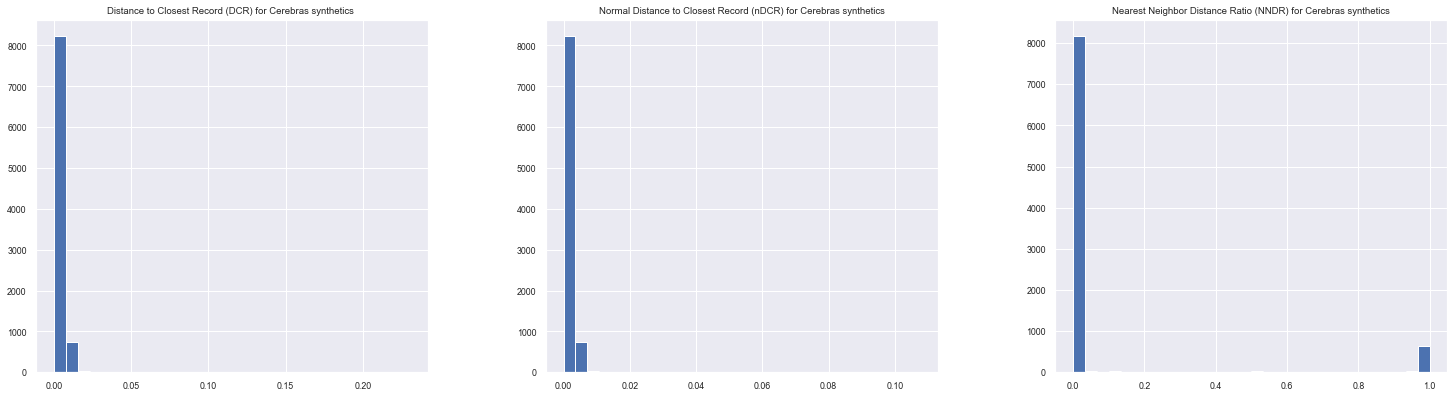

In [306]:
synt_privacy = pd.DataFrame(zip(dcr_synt3,dcr_synt_norm3,nndr_synt3),columns=['Distance to Closest Record (DCR) for Cerebras synthetics ','Normal Distance to Closest Record (nDCR) for Cerebras synthetics','Nearest Neighbor Distance Ratio (NNDR) for Cerebras synthetics'])
synt_privacy.hist(bins=privacy_number_of_bins, grid=True, figsize=(20, 5), layout=(1, 3))

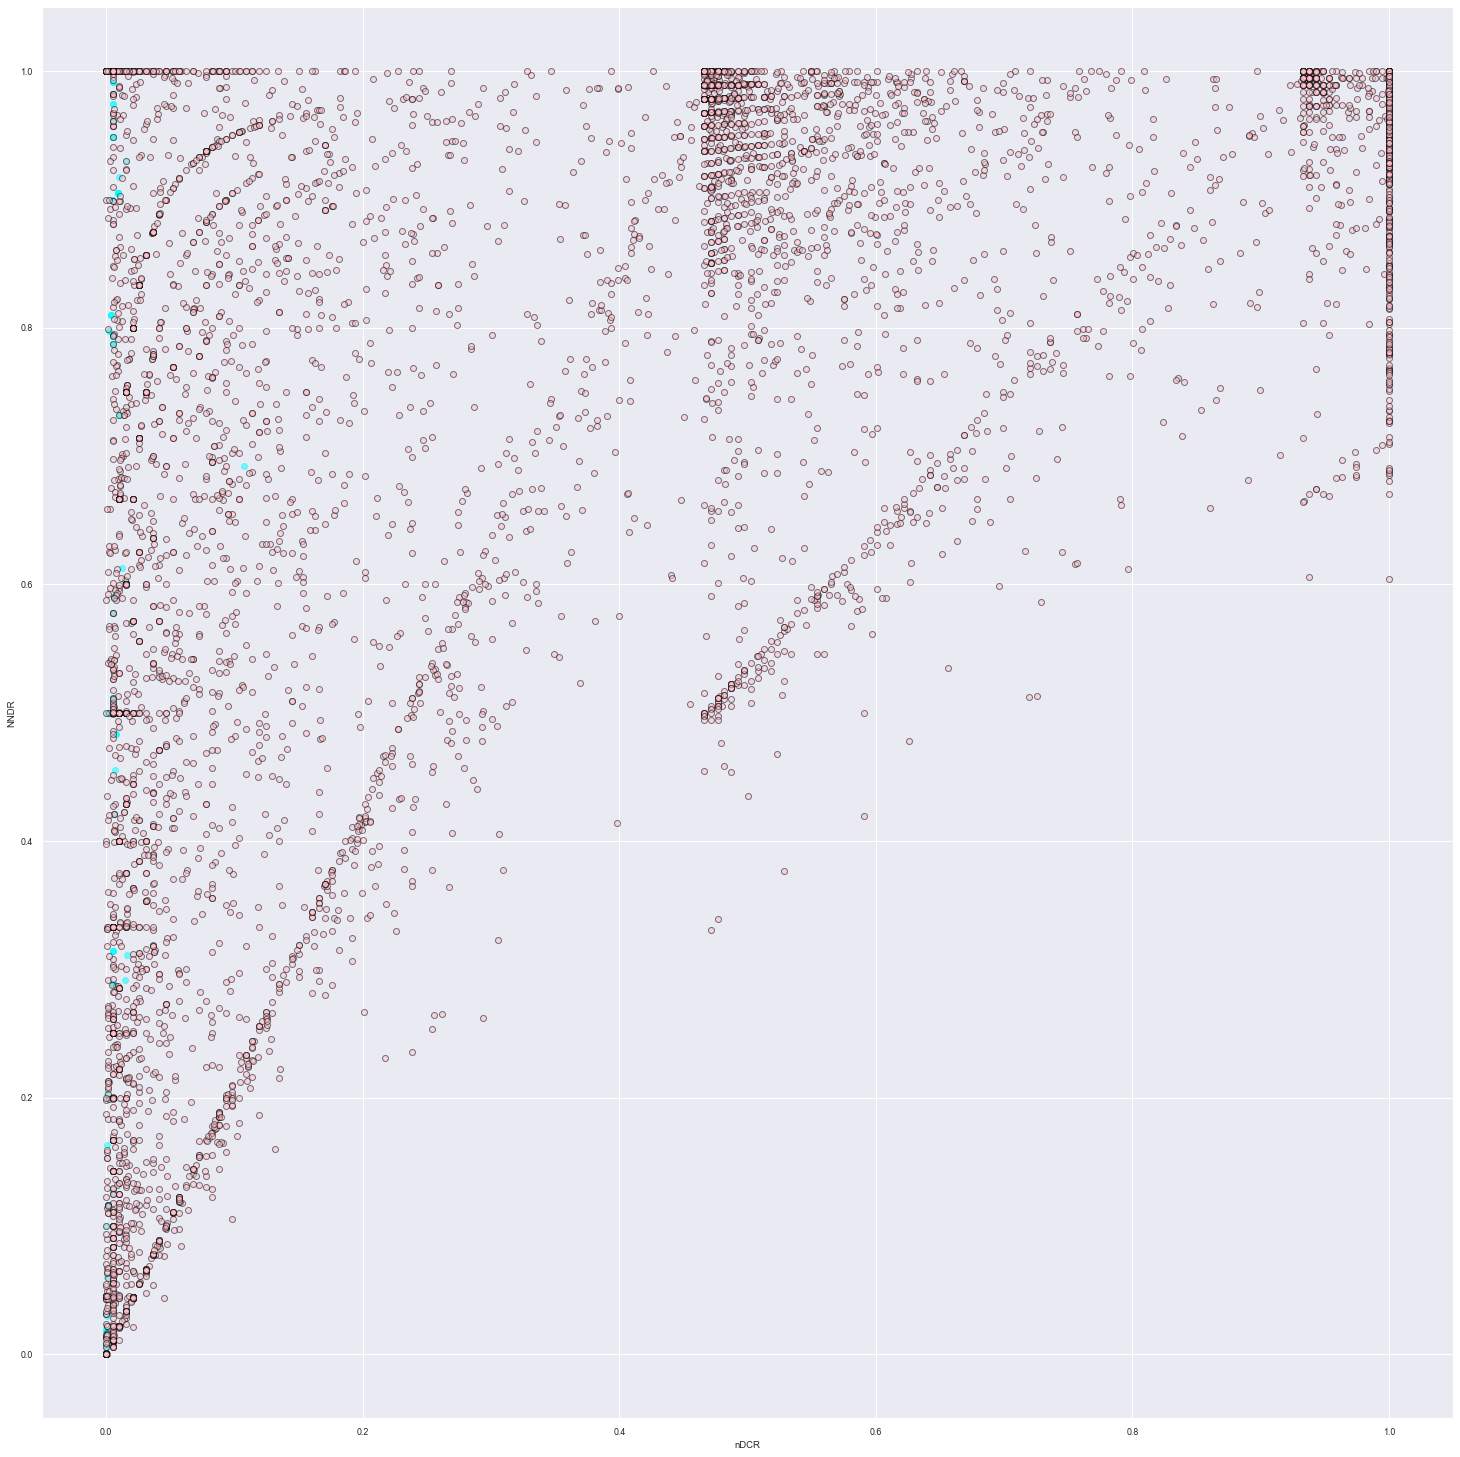

In [307]:
fig, ax = plt.subplots(figsize=(20, 20))
plt.xlabel("nDCR")
plt.ylabel("NNDR")
ax.scatter(dcr_synt_norm3, nndr_synt3, c='cyan', label='Cerebras', alpha=0.5, edgecolors='cyan')
ax.scatter(dcr_real_norm, nndr_real, c='pink', label='Real', alpha=0.5, edgecolors='black')
plt.show()

In [308]:
calc_dcr_ratio(dcr_real_norm,dcr_synt_norm3)

0.0002222716159146477

In [309]:
calc_nndr_ratio(nndr_real,nndr_synt3)

0.08735048930772019

In [310]:
stat, p_value = mannwhitneyu(dcr_real_norm, dcr_synt_norm3)
print(f" Mann-Whitney U rank test for nDCR: statistic={stat:.8f}, p-value={p_value:.8f}")
stat, p_value = mannwhitneyu(nndr_real, nndr_synt3)
print(f" Mann-Whitney U rank test for NNDR: statistic={stat:.6f}, p-value={p_value:.6f}")
print ('')


print ('')
stat, p_value = ks_2samp(dcr_real_norm, dcr_synt_norm3)
print(f" Kolmogorov-Smirnov Test for nDCR: statistic={stat:.8f}, p-value={p_value:.8f}")
stat, p_value = ks_2samp(nndr_real, nndr_synt3)
print(f" Kolmogorov-Smirnov Test for NNDR: statistic={stat:.6f}, p-value={p_value:.6f}")

 Mann-Whitney U rank test for nDCR: statistic=66334875.00000000, p-value=0.00000000
 Mann-Whitney U rank test for NNDR: statistic=62673770.500000, p-value=0.000000


 Kolmogorov-Smirnov Test for nDCR: statistic=0.59311111, p-value=0.00000000
 Kolmogorov-Smirnov Test for NNDR: statistic=0.583333, p-value=0.000000


In [311]:
res_privacy = pd.DataFrame([['Cerebras', bound3,
                        calc_dcr_ratio(dcr_real_norm,dcr_synt_norm3),
                        calc_nndr_ratio(nndr_real,nndr_synt3),
                        np.median(dcr_synt_norm3),
                        np.median(nndr_synt3),
                        dcr_synt_norm3.min()    ]],
                        columns=['Model','95% bound','DCRn ratio','NNDR ratio','DCRn median', 'NNDR median','Minimal distance'])

privacy_results = pd.concat([privacy_results, res_privacy],axis=0)

## Phi-1.5 privacy

In [312]:
syn_test1 = synt_data_phi.sample(n=control_size) 

In [313]:
hmm_test1 = syn_test1.copy()
hmm_test1 = hmm_test1[for_norm_columns+for_hmm_columns]

In [314]:
hmm_test1 = map_humming(hmm_test1,hmm)

In [315]:
nbs4 = get_2_neighbors_mixed(vectors=hmm_test1.to_numpy(),base=hmm_train.to_numpy(),norm_weights=norm_weights,trace=250)

9000 :0 -250 -500 -750 -1000 -1250 -1500 -1750 -2000 -2250 -2500 -2750 -3000 -3250 -3500 -3750 -4000 -4250 -4500 -4750 -5000 -5250 -5500 -5750 -6000 -6250 -6500 -6750 -7000 -7250 -7500 -7750 -8000 -8250 -8500 -8750 -9000


In [316]:
print('Stats : mean, std, max, min, amount')
dcr_synt4 = np.array([d[0] for d in [x[1] for x in [i for i in nbs4]]])
dcr2_synt4 = np.array([d[1] for d in [x[1] for x in [i for i in nbs4]]])
nndr_synt4 = dcr_synt4 / np.maximum(dcr2_synt4, smoothing_factor) 
print('NNDR stats', nndr_synt4.mean(), nndr_synt4.std(), nndr_synt4.max(), nndr_synt4.min(), len (nndr_synt4))
dcr_synt_norm4 = np.where(dcr_synt4 <= bound, dcr_synt4 / bound, 1)
print('nDCR stats', dcr_synt_norm4.mean(), dcr_synt_norm4.std(), dcr_synt_norm4.max(), dcr_synt_norm4.min(), len (dcr_synt_norm4))

baseline_dcr = dcr_synt4
bound4 = np.quantile(baseline_dcr[~np.isnan(baseline_dcr)], dcr_quantile)
print('DCR Bound',dcr_quantile,'% =',bound4)

Stats : mean, std, max, min, amount
NNDR stats 0.07238488038958635 0.24990275153344058 1.0 0.0 9000
nDCR stats 0.00047270247712441254 0.0018189639251803462 0.04663212435233161 0.0 9000
DCR Bound 0.95 % = 0.011111111111111112


In [317]:
synt_privacy = pd.DataFrame(zip(dcr_synt4,dcr_synt_norm4,nndr_synt4),columns=['Distance to Closest Record (DCR) for Phi1.5 synthetics ','Normal Distance to Closest Record (nDCR) for Phi1.5 synthetics','Nearest Neighbor Distance Ratio (NNDR) for Phi1.5 synthetics'])
synt_privacy.hist(bins=privacy_number_of_bins, grid=True, figsize=(20, 5), layout=(1, 3))

array([[<AxesSubplot:title={'center':'Distance to Closest Record (DCR) for Phi1.5 synthetics '}>,
        <AxesSubplot:title={'center':'Normal Distance to Closest Record (nDCR) for Phi1.5 synthetics'}>,
        <AxesSubplot:title={'center':'Nearest Neighbor Distance Ratio (NNDR) for Phi1.5 synthetics'}>]],
      dtype=object)

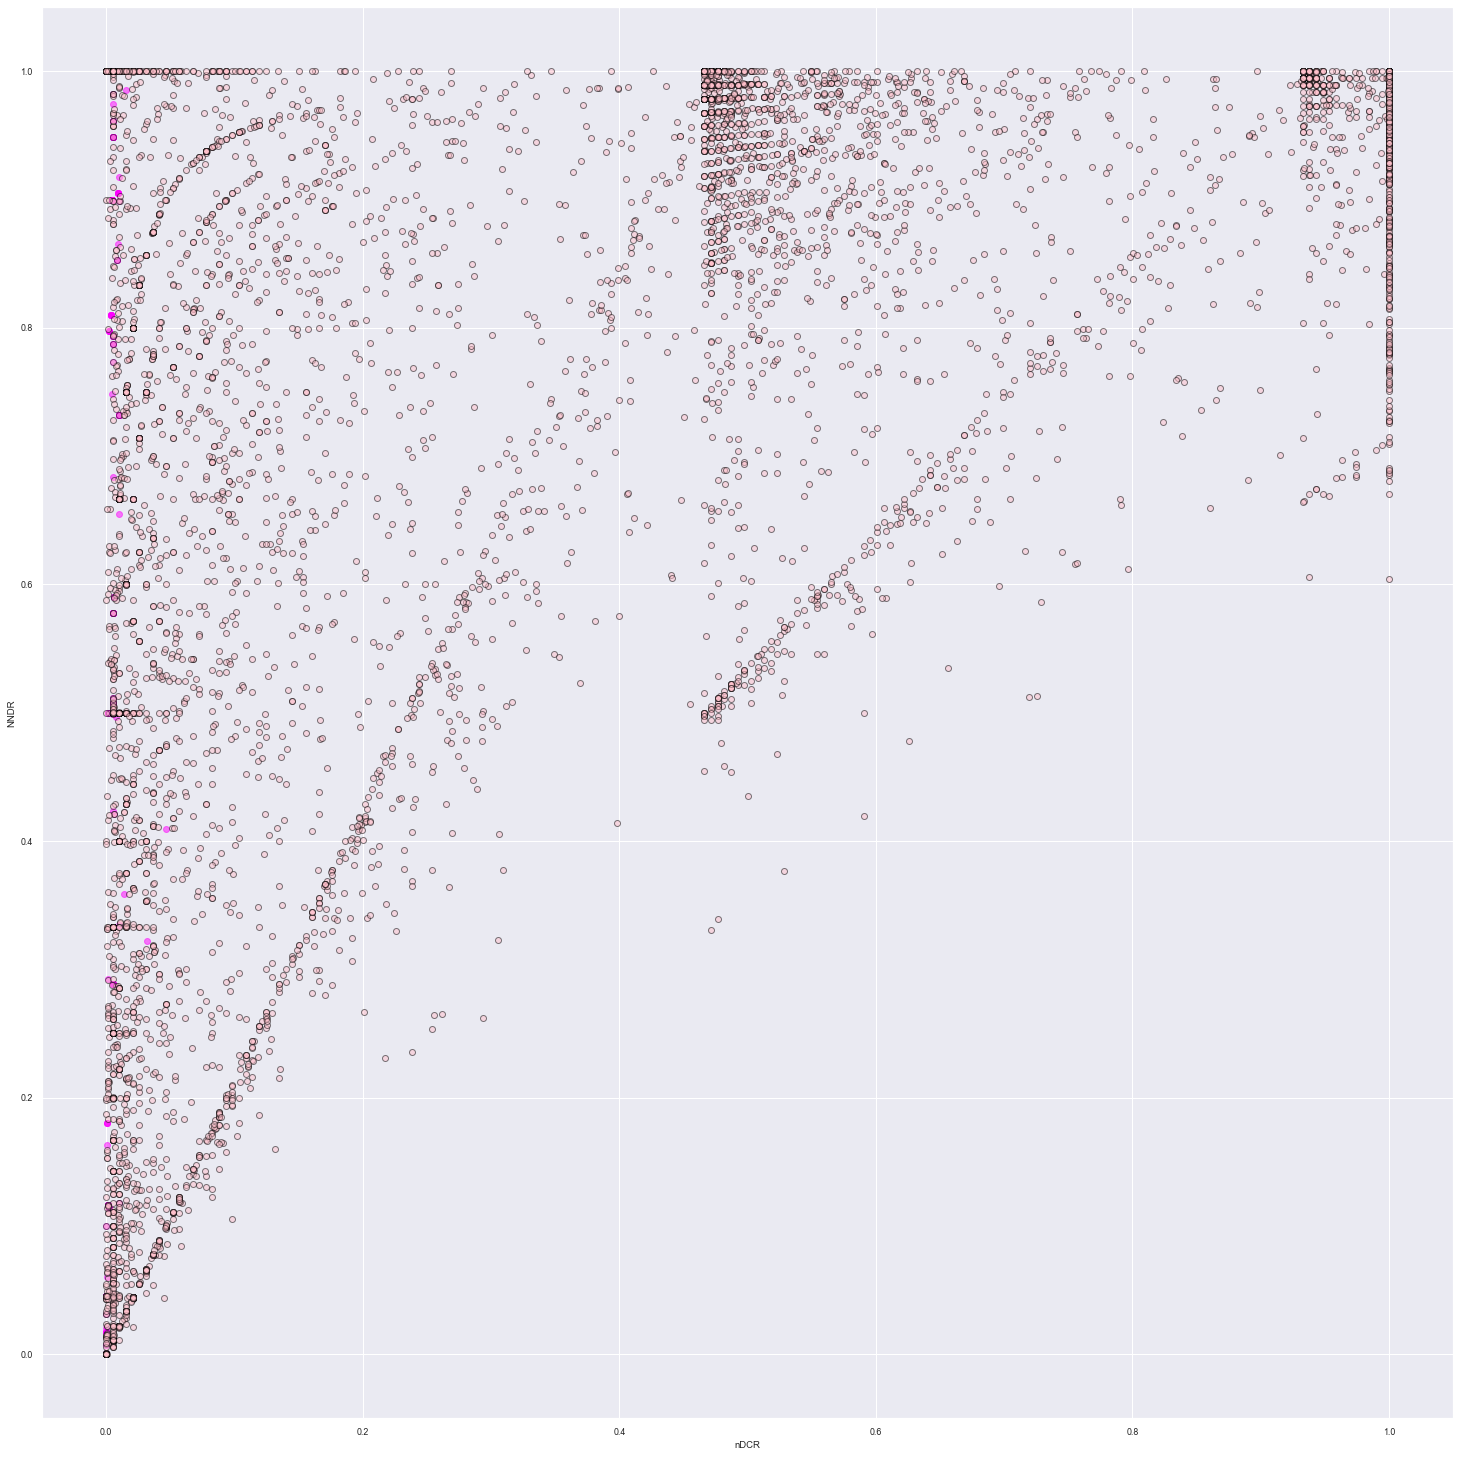

In [318]:
fig, ax = plt.subplots(figsize=(20, 20))
plt.xlabel("nDCR")
plt.ylabel("NNDR")
ax.scatter(dcr_synt_norm4, nndr_synt4, c='magenta', label='Phi1.5', alpha=0.5, edgecolors='magenta')
ax.scatter(dcr_real_norm, nndr_real, c='pink', label='Real', alpha=0.5, edgecolors='black')
plt.show()

In [319]:
calc_dcr_ratio(dcr_real_norm,dcr_synt_norm4)

0.00044464206313917296

In [320]:
calc_nndr_ratio(nndr_real,nndr_synt4)

0.07707036859741503

In [321]:
stat, p_value = mannwhitneyu(dcr_real_norm, dcr_synt_norm4)
print(f" Mann-Whitney U rank test for nDCR: statistic={stat:.8f}, p-value={p_value:.8f}")
stat, p_value = mannwhitneyu(nndr_real, nndr_synt4)
print(f" Mann-Whitney U rank test for NNDR: statistic={stat:.6f}, p-value={p_value:.6f}")
print ('')


print ('')
stat, p_value = ks_2samp(dcr_real_norm, dcr_synt_norm4)
print(f" Kolmogorov-Smirnov Test for nDCR: statistic={stat:.8f}, p-value={p_value:.8f}")
stat, p_value = ks_2samp(nndr_real, nndr_synt4)
print(f" Kolmogorov-Smirnov Test for NNDR: statistic={stat:.6f}, p-value={p_value:.6f}")

 Mann-Whitney U rank test for nDCR: statistic=66443213.00000000, p-value=0.00000000
 Mann-Whitney U rank test for NNDR: statistic=63333287.500000, p-value=0.000000


 Kolmogorov-Smirnov Test for nDCR: statistic=0.59022222, p-value=0.00000000
 Kolmogorov-Smirnov Test for NNDR: statistic=0.590222, p-value=0.000000


In [322]:
fig, ax = plt.subplots(figsize=(20, 20))
plt.xlabel("nDCR")
plt.ylabel("NNDR")
ax.scatter(dcr_synt_norm1, nndr_synt1, c='lightblue', label='DistilledGPT', alpha=0.5, edgecolors='lightblue')
ax.scatter(dcr_synt_norm2, nndr_synt2, c='lightgreen', label='GPT2xl', alpha=0.5, edgecolors='lightgreen')
ax.scatter(dcr_synt_norm3, nndr_synt3, c='cyan', label='Cerebras', alpha=0.5, edgecolors='cyan')
ax.scatter(dcr_synt_norm4, nndr_synt4, c='magenta', label='Phi-1.5', alpha=0.5, edgecolors='magenta')
ax.scatter(dcr_real_norm, nndr_real, c='pink', label='Real', alpha=0.5, edgecolors='black')
plt.show()

In [323]:
res_privacy = pd.DataFrame([['Phi1.5', bound4,
                        calc_dcr_ratio(dcr_real_norm,dcr_synt_norm4),
                        calc_nndr_ratio(nndr_real,nndr_synt4),
                        np.median(dcr_synt_norm4),
                        np.median(nndr_synt4),
                        dcr_synt_norm4.min()    ]],
                        columns=['Model','95% bound','DCRn ratio','NNDR ratio','DCRn median', 'NNDR median','Minimal distance'])

privacy_results = pd.concat([privacy_results, res_privacy],axis=0)

### Privacy calculation results 

In [324]:
privacy_results

Model  95% bound  DCRn ratio  NNDR ratio  DCRn median  NNDR median  \
0  Real dataset   2.144444    1.000000    1.000000     0.026871     0.507562   
0   DistillGPT2   0.222252    0.121635    0.263513     0.000000     0.000000   
0        GPT2xl   0.011111    0.000890    0.068122     0.000000     0.000000   
0      Cerebras   0.011111    0.000222    0.087350     0.000000     0.000000   
0        Phi1.5   0.011111    0.000445    0.077070     0.000000     0.000000   

   Minimal distance  
0               0.0  
0               0.0  
0               0.0  
0               0.0  
0               0.0

In [325]:
privacy_results.to_csv('privacy_results_shortincome_temp0.1.csv')